# Imports

In [5]:
# IMPORTS
import numpy as np
import pandas as pd
import scipy
import matplotlib
import seaborn as sns
import sklearn
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.utils import make_grid
import time
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import datetime
import os

# Fetch data

In [6]:
# @title Download the data

import os, requests, tarfile

fnames = ["kay_labels.npy", "kay_labels_val.npy", "kay_images.npz"]
urls = ["https://osf.io/r638s/download",
        "https://osf.io/yqb3e/download",
        "https://osf.io/ymnjv/download"]

for fname, url in zip(fnames, urls):
  if not os.path.isfile(fname):
    try:
      r = requests.get(url)
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        print(f"Downloading {fname}...")
        with open(fname, "wb") as fid:
          fid.write(r.content)
        print(f"Download {fname} completed!")

In [7]:
with np.load(fname) as dobj:
  dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

# Visualization and pre-processing

## Initial insight into data


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [8]:
print(labels[:, :4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [9]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [10]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [11]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [12]:
roi_count = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

print(roi_count)

{'Other': 0, 'V1': 1294, 'V2': 2083, 'V3': 1790, 'V3A': 484, 'V3B': 314, 'V4': 1535, 'LatOcc': 928}


Each stimulus is a 128 x 128 grayscale array:

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\3010978900.py:6: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


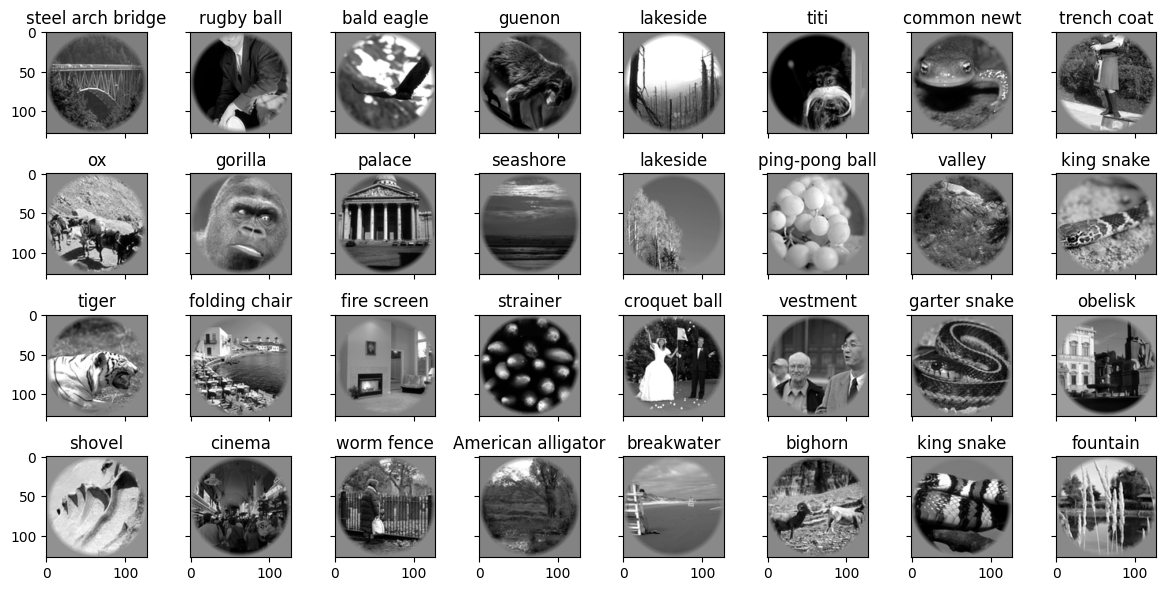

In [13]:
fig, axs = plt.subplots(4, 8, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli_test"], val_labels[-1, :]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
fig.tight_layout()
fig.show()

## Visualization

### Training data:

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\2625672689.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


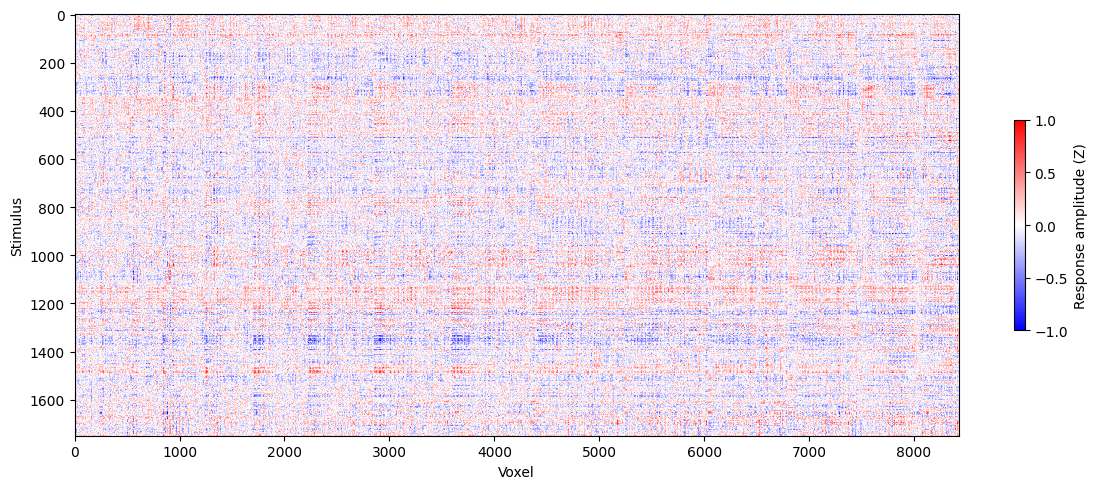

In [14]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Test data:

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\3850067406.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


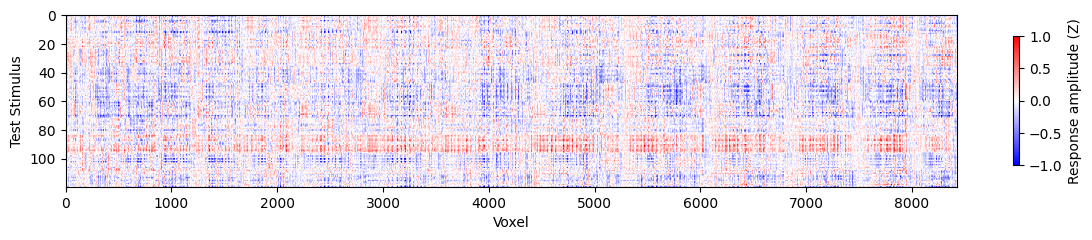

In [15]:
fig, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"],
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

### Other visualisations:

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\1498469230.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


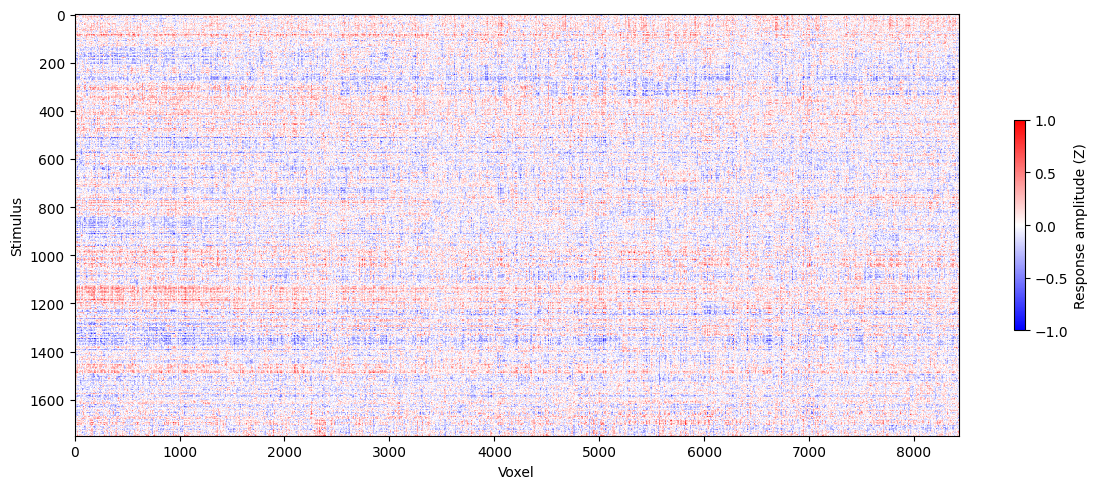

In [16]:
# Sort dat['roi'] ascending and use this order to sort dat['responses']
roi_order = np.argsort(dat['roi'])
sorted_roi = dat['roi'][roi_order]
sorted_responses = dat['responses'][:, roi_order]

# Plot the sorted responses
fig, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(sorted_responses,
                    aspect="auto", vmin=-1, vmax=1, cmap="bwr")
fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
fig.tight_layout()
fig.show()

In [17]:
# Split dat['responses'] by their corresponding category in labels

# Get the unique categories in labels
categories = np.unique(labels[0, :])
print("Unique categories:", categories)

# Split the responses by category (each category should have shape (num_img, 8428))
responses_by_category = [dat['responses'][labels[0, :] == category, :] for category in categories]

# Print shapes of responses_by_category
for category, category_responses in zip(categories, responses_by_category):
  print(f"Category {category} has shape {category_responses.shape}")

Unique categories: ['animal' 'artifact' 'entity' 'fruit' 'fungus' 'geological formation'
 'person' 'plant']
Category animal has shape (589, 8428)
Category artifact has shape (812, 8428)
Category entity has shape (72, 8428)
Category fruit has shape (77, 8428)
Category fungus has shape (5, 8428)
Category geological formation has shape (192, 8428)
Category person has shape (2, 8428)
Category plant has shape (1, 8428)


C:\Users\simon\AppData\Local\Temp\ipykernel_13492\1454581728.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


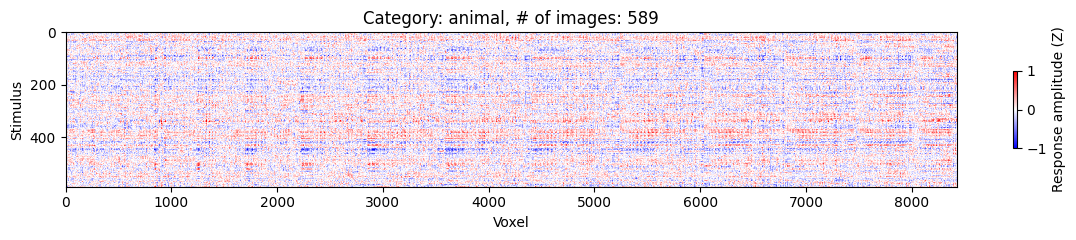

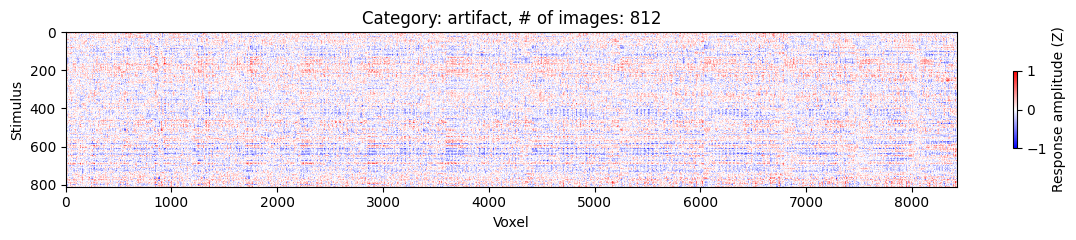

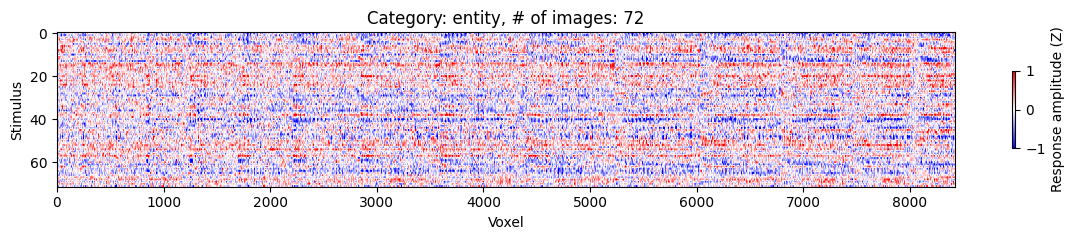

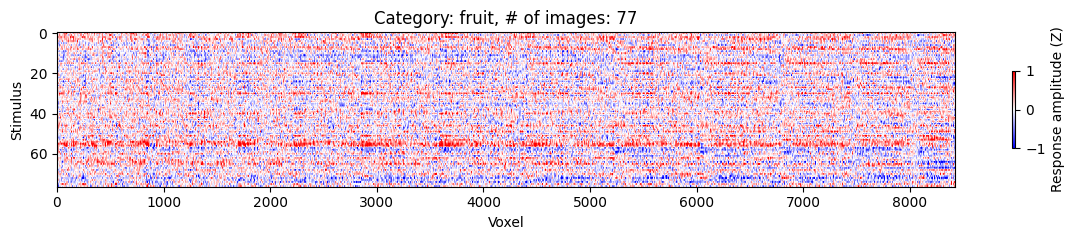

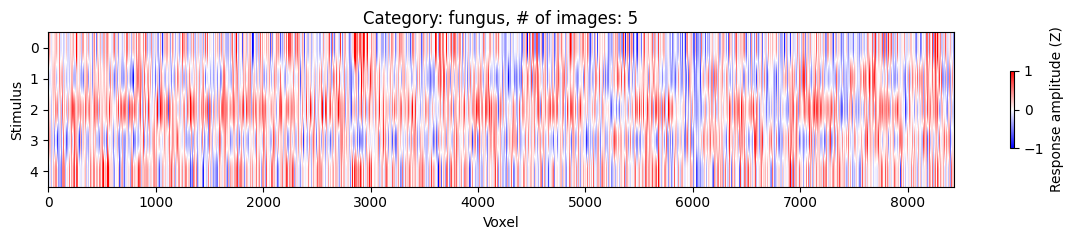

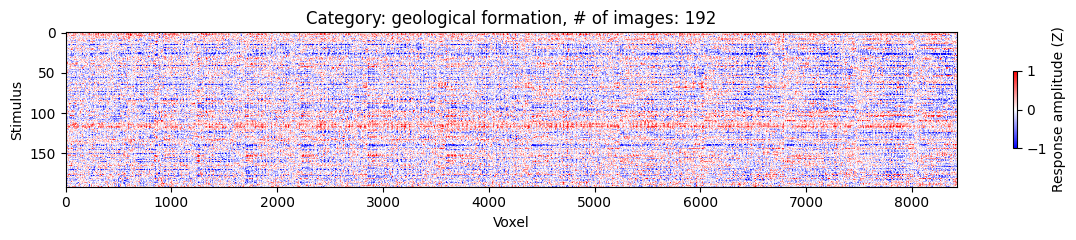

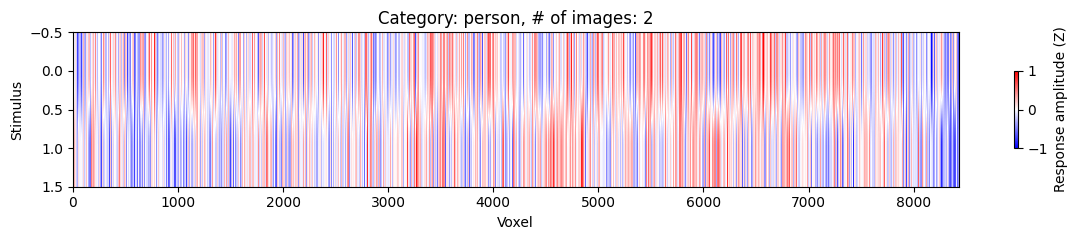

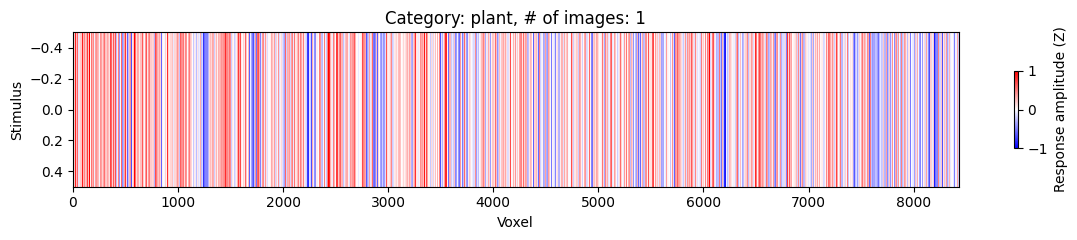

In [18]:
# Plot the responses for each category
for i in range(len(categories)):
    fig, ax = plt.subplots(figsize=(12, 2.5))
    ax.set_title(f"Category: {categories[i]}, # of images: {responses_by_category[i].shape[0]}")
    ax.set(xlabel="Voxel", ylabel="Stimulus")
    heatmap = ax.imshow(responses_by_category[i],
                        aspect="auto", vmin=-1, vmax=1, cmap="bwr")
    fig.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
    fig.tight_layout()
    fig.show()

### Visualization of the means for the ROIs, compared across different stimuli of the same category

In [19]:
# Functions for plotting barplots of the different ROI's means for a specific category

def compute_roi_bins(image_index):
    responses = dat["responses"]
    rois = dat["roi"]
    roi_names_count = np.bincount(rois)[1:]

    roi_bins = [0, 0, 0, 0, 0, 0, 0]
    # For one image, go through all voxels recorded
    for i in range(len(responses[0])):
        roi_index = rois[i] - 1
        roi_bins[roi_index] += responses[image_index][i]
    for i in range(len(roi_bins)):
        roi_bins[i] /= roi_names_count[i]
    
    return roi_bins

def compute_roi_distributions_from_category(category, category_hierarchy, count):
    index = 0
    graphs_xvalues = []
    graphs_specific_labels = []
    while len(graphs_xvalues) < count:
        #print(labels[category_hierarchy][index], '/', category)
        if labels[category_hierarchy][index] == category: # category hierachy level
            graphs_xvalues.append(compute_roi_bins(index))
            graphs_specific_labels.append(labels[3][index])
        index += 1

    return graphs_xvalues, graphs_specific_labels

def barplot_roi_distribution(category, graph_xvalues, graph_specific_labels, ylim=[-0.4, 0.4], plot_rows=3, plot_cols=4):
    figure, axis = plt.subplots(plot_rows, plot_cols, figsize=(12,8))
    figure.suptitle(category)
    for ax, im, lbl in zip(axis.flat, graph_xvalues, graph_specific_labels):
        ax.set_ylim(ylim)
        ax.bar(range(len(im)), im)
        ax.set_title(lbl)
    figure.tight_layout()
    figure.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\119951743.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


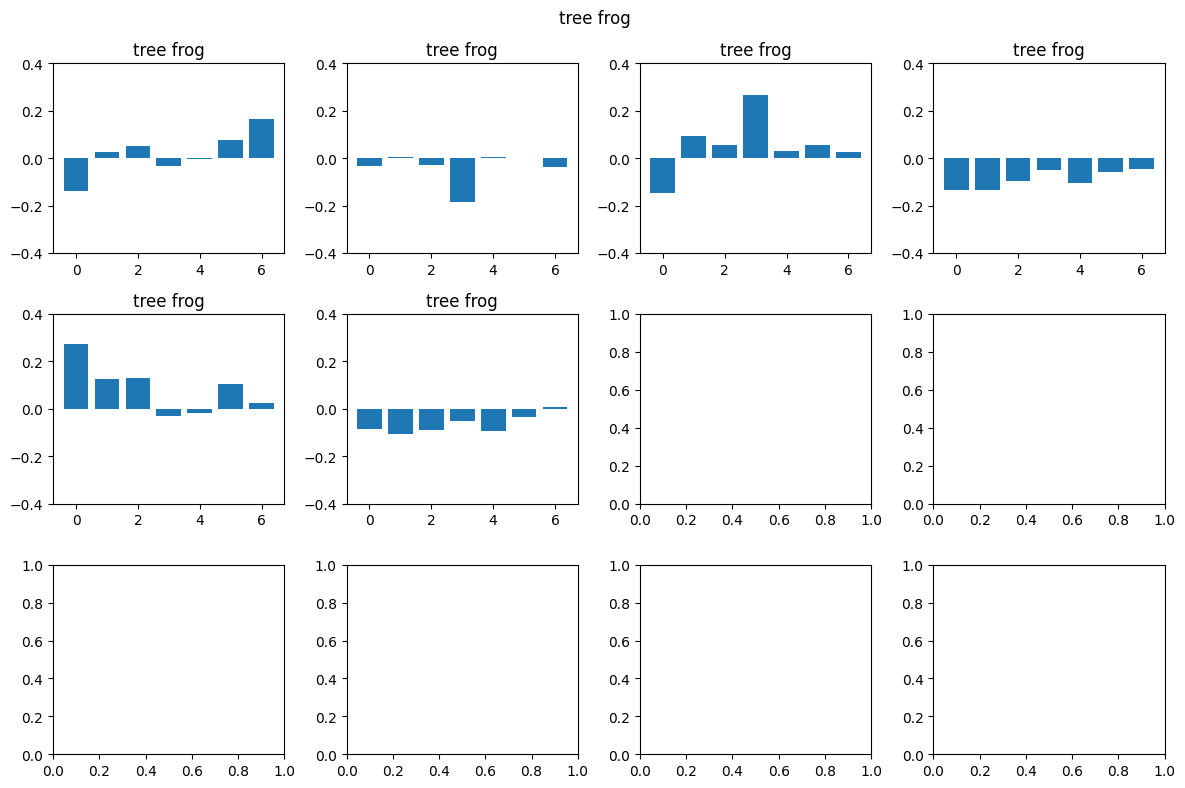

In [20]:
# Plot barplots of ROI distribution for a specified category
# Specify category name, it's hierarchy level, and how many stimili there is
category_name = 'tree frog'
category_hierarchy = 3
count = 6
roi_distributions_values, roi_distibutions_labels = compute_roi_distributions_from_category(category_name, category_hierarchy, count)
barplot_roi_distribution(category_name, roi_distributions_values, roi_distibutions_labels)

C:\Users\simon\AppData\Local\Temp\ipykernel_13492\119951743.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure.show()


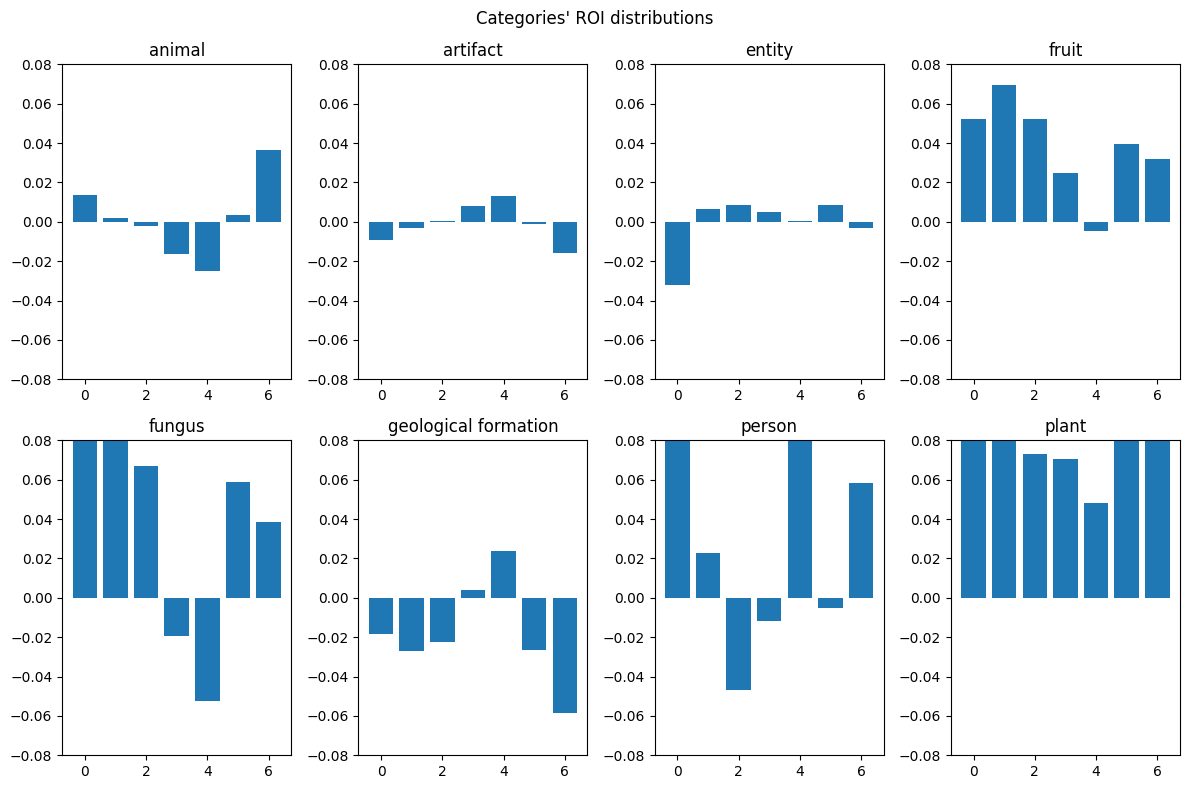

In [21]:
# Plot ROI distributions' means over all categories
# (Hardcoded to only work on category hierarchy 0 for now)

unique_labels = np.unique(labels[0, :])
# Lists to store values
total_roi_values = np.zeros((len(unique_labels), len(dat['roi_names']) - 1))
# (I didn't know how to get the sample count for each category?)
category_counts = [589, 812, 72, 77, 5, 192, 2, 1]

# Loop to go through each sample 
for i in range(len(labels[0])):
    # Loop to go through each unique label (category)
    for label in range(len(unique_labels)):
        # Assign computed ROI distribution to total ROI value list in correct index (hence the previous loop)
        if labels[0][i] == unique_labels[label]:
            total_roi_values[label] += compute_roi_bins(i)

# Loop to update total ROI value list to means
for label in range(len(total_roi_values)):
    total_roi_values[label] /= category_counts[label]

barplot_roi_distribution("Categories' ROI distributions", total_roi_values, unique_labels, ylim=[-0.08, 0.08], plot_rows=2, plot_cols=4)

## Pre-processing

### Removing categories with few samples

In [22]:
# Get indices for categories to remove (person, fungus, plant, instrumentality)
remove_indices_training = np.empty((0), dtype=int)
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'person')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[0, :] == 'fungus')[0])
remove_indices_training = np.append(remove_indices_training,  np.where(labels[0, :] == 'plant')[0])
remove_indices_training = np.append(remove_indices_training, np.where(labels[1, :] == 'instrumentality')[0])
remove_indices_test = np.empty((0), dtype=int)
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'person')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[0, :] == 'fungus')[0])
remove_indices_test = np.append(remove_indices_test,  np.where(val_labels[0, :] == 'plant')[0])
remove_indices_test = np.append(remove_indices_test, np.where(val_labels[1, :] == 'instrumentality')[0])

# Remove the data
# Training
training_inputs = np.delete(dat["stimuli"], remove_indices_training, axis=0)
training_outputs = np.delete(dat["responses"], remove_indices_training, axis=0)
training_labels = np.delete(labels, remove_indices_training, axis=1)
# Test
test_inputs = np.delete(dat["stimuli_test"], remove_indices_test, axis=0)
test_outputs = np.delete(dat["responses_test"], remove_indices_test, axis=0)
test_labels = np.delete(val_labels, remove_indices_test, axis=1)

print('Original training input size:', dat['stimuli'].shape)
print('Training input:', training_inputs.shape)
print('Training output:', training_outputs.shape)
print('Training labels:', training_labels.shape)
print('Original test input', dat['stimuli_test'].shape)
print('Test input:', test_inputs.shape)
print('Test output:', test_outputs.shape)
print('Test labels:', test_labels.shape)

Original training input size: (1750, 128, 128)
Training input: (1390, 128, 128)
Training output: (1390, 8428)
Training labels: (4, 1390)
Original test input (120, 128, 128)
Test input: (105, 128, 128)
Test output: (105, 8428)
Test labels: (4, 105)


### Reducing output size to number of ROI's instead of voxels

In [23]:
# Preprocess outputs to be the mean of each ROI instead of each voxel.
# This reduces the outputs to be predicted from 8428 to 7, hopefully not losing too much detail in the data in the process.
def reduce_outputs_to_ROIs(outputs):
    roi_count_dict = dict(zip(dat["roi_names"], np.bincount(dat["roi"])))
    roi_order = np.argsort(dat['roi'])
    sorted_responses = training_outputs[:, roi_order]

    training_outputs_reduced_to_ROIs = np.zeros((len(outputs), 7))
    for sample in range(len(training_outputs_reduced_to_ROIs)):
        oldValue = 0
        count = 0
        for key, value in roi_count_dict.items():
            if value > 0:
                response_values = sorted_responses[:, oldValue:oldValue+value]
                summed_roi = np.mean(response_values[sample])
                training_outputs_reduced_to_ROIs[sample][count] = summed_roi
                count += 1
            oldValue = value
    return training_outputs_reduced_to_ROIs

print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Example values:', reduce_outputs_to_ROIs(training_outputs)[0])

(1390, 7)
Example values: [-0.36620308 -0.36129435 -0.29608064 -0.34640159 -0.17965585 -0.37665786
 -0.32373576]


# Encoder model

In [24]:
# Variables
batch_size = 128
num_epochs = 500

## Implementation of AlexNet from scratch

In [25]:
# CNN model for voxel-wise encoding
class EncoderModel(nn.Module):
    def __init__(self, dimension_length, num_outputs):
        super(EncoderModel, self).__init__()

        # This model takes inspiration from: https://github.com/dansuh17/alexnet-pytorch/blob/master/model.py
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4),  # (b x 96 x 30 x 30)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),  # section 3.3
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 96 x 14 x 14)
            nn.Conv2d(96, 256, 5, padding=2),  # (b x 256 x 14 x 14)
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 6 x 6)
            nn.Conv2d(256, 384, 3, padding=1),  # (b x 384 x 6 x 6)
            nn.ReLU(),
            nn.Conv2d(384, 384, 3, padding=1),  # (b x 384 x 6 x 6)
            nn.ReLU(),
            nn.Conv2d(384, 256, 3, padding=1),  # (b x 256 x 6 x 6)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (b x 256 x 2 x 2)
        )
        # classifier is just a name for linear layers
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(in_features=4096, out_features=num_outputs),
        )


    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images

        x = self.net(x)
        x = x.view(-1, 256 * 2 * 2)  # reduce the dimensions for linear layer input
        return self.classifier(x)

    def forward_with_intermediate(self, x):
        outputs = {}  # Dictionary to store intermediate outputs

        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images
        for i, layer in enumerate(self.net):
            x = layer(x)
            outputs[f'net_{i}'] = x

        x = x.view(-1, 256 * 2 * 2)  # Flatten the output for the classifier
        for i, layer in enumerate(self.classifier):
            x = layer(x)
            outputs[f'classifier_{i}'] = x

        return x, outputs

## Implementation of AlexNet using PyTorch's pretrained model

In [30]:
import torch
import torch.nn as nn
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
import numpy as np

#optimixzer keyword parameter 
# Modify AlexNet
class ModifiedAlexNet(nn.Module):
    def __init__(self):
        super(ModifiedAlexNet, self).__init__()
        alexnet = models.alexnet(weights=True)
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 8428),  # Change to match the number of voxel values
        )

    def forward(self, x):
        
        x.unsqueeze_(1)
        #make grayscale to rgb
        x = torch.cat((x, x, x), dim=1)
        
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
    def forward_with_intermediate(self, x):
        outputs = {}  # Dictionary to store intermediate outputs

        x = x.unsqueeze(1)  # Add a channel dimension for grayscale images
        x = torch.cat((x, x, x), dim=1)
        
        for i, layer in enumerate(self.features):
            x = layer(x)
            outputs[f'features_{i}'] = x
            
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        
        for i, layer in enumerate(self.classifier):
            x = layer(x)
            outputs[f'classifier_{i}'] = x

        return x, outputs

## Model setup

In [31]:
def get_current_time():
    # Saving model - using time as unique identifier for name
    t = time.localtime()
    current_time = time.strftime("%D_%H_%M_%S", t)

    #make the day format have a - instead of /
    current_time = current_time.replace("/","_")

    #time as string
    timeString = str(current_time)

    return timeString

In [32]:
class Encoder():
    def __init__(self, input, output):
        self.input = input
        self.output = output
        self.losses = []
        self.best_loss = 1000000
    
    # Method for setting up model and needed elements for it to be trained
    def setup_model(self, batch_size):
        # Seperate data
        x_train = self.input
        y_train = self.output

        # Create tensor from training inputs and targets
        x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float()
        training_data_tensor = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
        # Create dataloader from tensor
        train_dataloader = torch.utils.data.DataLoader(training_data_tensor, batch_size, shuffle=True)

        # Create encoder model
        encoder_model = ModifiedAlexNet()
        
        # MSELoss instead of CrossEntropy beause it is more of a regression problem than classification
        criterion = nn.MSELoss()
        
        for name, param in encoder_model.named_parameters():
            if "classifier" in name:
                param.requires_grad = True
            else:
                param.requires_grad = False
        # Optimizer
        optimizer = optim.Adam(encoder_model.parameters(), lr=0.0001)
        
        
        #optimizer = optim.SGD(encoder_model.parameters(), lr=0.0001, momentum=0.9, weight_decay=1e-6, nesterov=True)

        return encoder_model, criterion, optimizer, train_dataloader

    # Method for training the model one epoch
    def train_one_epoch(self, train_dataloader, optimizer, criterion, encoder, epoch):
        train_running_loss = 0.0
        last_loss = 0.0

        # Put the model in training mode
        encoder = encoder.train()

        # Iterate through the data
        for i, data in enumerate(train_dataloader):
            inputs, targets = data

            outputs = encoder(inputs.float())
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()

            # Update model params
            optimizer.step()

            train_running_loss += loss.detach().item()
            last_loss = loss.detach().item()

            #if i % 100 == 0 and i != 0:
            #    print('Epoch: {}, Batch: {}, Loss: {}'.format(epoch, i, train_running_loss / 100))
            #    train_running_loss = 0.0
            
        return last_loss


    # Method for training the model fully
    def train(self, batch_size, num_epochs):
        timestamp = get_current_time()
        
        # Setup model
        encoder_model, criterion, optimizer, train_dataloader = self.setup_model(batch_size)
        
        # Training
        train_running_loss = 0.0
        for epoch in range(num_epochs):
            train_running_loss = self.train_one_epoch(train_dataloader, optimizer, criterion, encoder_model, epoch)
            self.losses.append(train_running_loss)

            if train_running_loss < self.best_loss:
                self.best_loss = train_running_loss
                best_model = encoder_model.state_dict()
                torch.save(best_model, os.path.join('./trained_models/', 'trainedmodel_{}.pth'.format(timestamp)))

            # Print loss value after each epoch
            print('Epoch: {} | Loss: {}'.format(epoch, train_running_loss))
        
            if (epoch+1) % 10 == 0:
                # Plot loss curve
                plt.figure(figsize=(10, 5))
                plt.title(f'Encoder Loss')
                plt.plot(self.losses, label="Encoder Loss")
                plt.xlabel("Iterations")
                plt.ylabel("Epoch")
                plt.legend()

                if epoch == num_epochs - 1:
                    save_dir = './loss_plots/'

                    # Check if the directory exists
                    if not os.path.exists(save_dir):
                        os.makedirs(save_dir)  # Create the directory if it does not exist

                    # Save plot of loss curve. Format: loss_{num_epochs}_{timestamp].png
                    plt.savefig(os.path.join(save_dir, f'loss_{num_epochs}_{timestamp}.png'))

                plt.show()

        return encoder_model

# Training the model

Original input data shape: (1390, 128, 128)
Original outputs data shape: (1390, 8428)
Epoch: 0 | Loss: 0.9955892562866211
Epoch: 1 | Loss: 0.9676281809806824
Epoch: 2 | Loss: 0.991463840007782
Epoch: 3 | Loss: 1.007439374923706
Epoch: 4 | Loss: 0.9812920689582825
Epoch: 5 | Loss: 1.046243667602539
Epoch: 6 | Loss: 0.9757615327835083
Epoch: 7 | Loss: 0.975167453289032
Epoch: 8 | Loss: 0.9689182639122009
Epoch: 9 | Loss: 0.9674505591392517


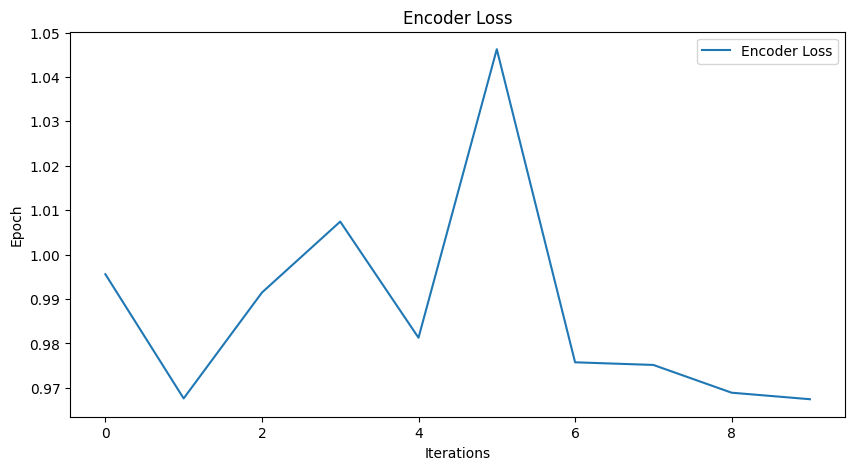

Epoch: 10 | Loss: 0.9840322732925415
Epoch: 11 | Loss: 0.9894561171531677
Epoch: 12 | Loss: 0.9495288133621216
Epoch: 13 | Loss: 0.9677593111991882
Epoch: 14 | Loss: 0.9463999271392822
Epoch: 15 | Loss: 0.9783633947372437
Epoch: 16 | Loss: 0.9353497624397278
Epoch: 17 | Loss: 0.9425964951515198
Epoch: 18 | Loss: 0.9468680620193481
Epoch: 19 | Loss: 0.9069687724113464


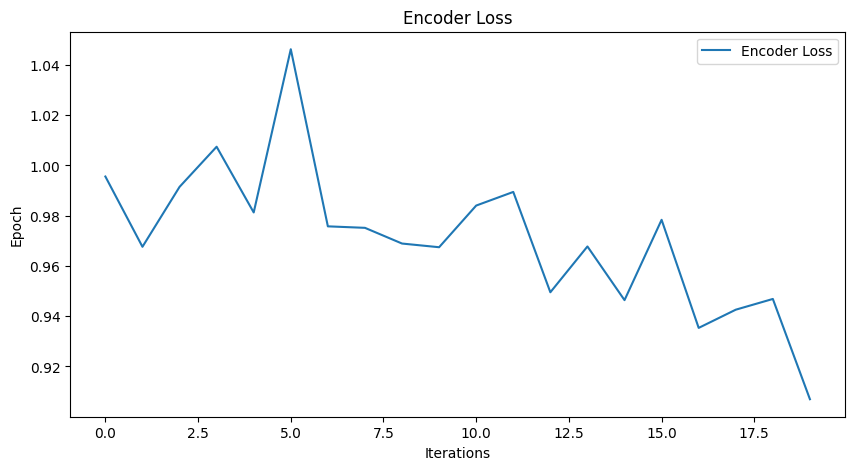

Epoch: 20 | Loss: 0.942870020866394
Epoch: 21 | Loss: 0.8969745635986328
Epoch: 22 | Loss: 0.9264735579490662
Epoch: 23 | Loss: 0.9125384092330933
Epoch: 24 | Loss: 0.8989749550819397
Epoch: 25 | Loss: 0.8861832022666931
Epoch: 26 | Loss: 0.8777552843093872
Epoch: 27 | Loss: 0.8862742185592651
Epoch: 28 | Loss: 0.8829194903373718
Epoch: 29 | Loss: 0.8443589210510254


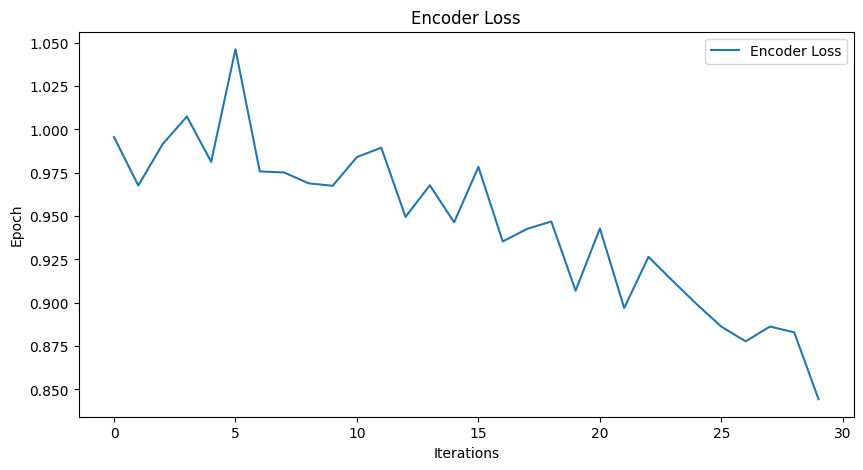

Epoch: 30 | Loss: 0.848432719707489
Epoch: 31 | Loss: 0.8472585082054138
Epoch: 32 | Loss: 0.8671525716781616
Epoch: 33 | Loss: 0.8301007151603699
Epoch: 34 | Loss: 0.8319498896598816
Epoch: 35 | Loss: 0.8698428273200989
Epoch: 36 | Loss: 0.8274602293968201
Epoch: 37 | Loss: 0.8114998936653137
Epoch: 38 | Loss: 0.8186542987823486
Epoch: 39 | Loss: 0.8059076070785522


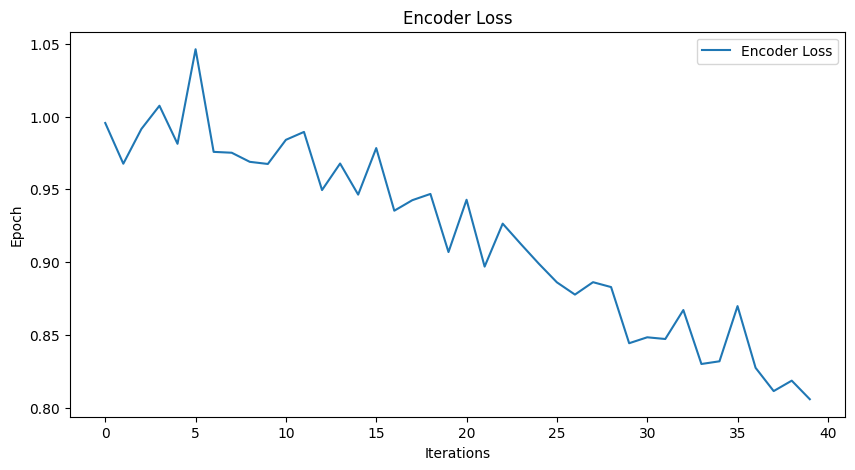

Epoch: 40 | Loss: 0.7991122603416443
Epoch: 41 | Loss: 0.7920620441436768
Epoch: 42 | Loss: 0.7815346121788025
Epoch: 43 | Loss: 0.7960190773010254
Epoch: 44 | Loss: 0.7729895710945129
Epoch: 45 | Loss: 0.7698219418525696
Epoch: 46 | Loss: 0.7695873975753784
Epoch: 47 | Loss: 0.7782690525054932
Epoch: 48 | Loss: 0.7700802683830261
Epoch: 49 | Loss: 0.7583844661712646


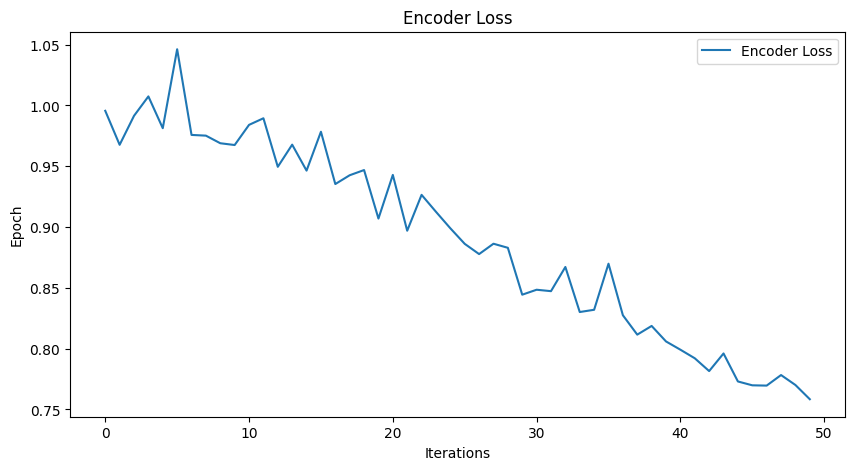

Epoch: 50 | Loss: 0.7534085512161255
Epoch: 51 | Loss: 0.7496142387390137
Epoch: 52 | Loss: 0.7515608072280884
Epoch: 53 | Loss: 0.7427526712417603
Epoch: 54 | Loss: 0.716679036617279
Epoch: 55 | Loss: 0.6994872093200684
Epoch: 56 | Loss: 0.6836506128311157
Epoch: 57 | Loss: 0.7023324966430664
Epoch: 58 | Loss: 0.6849380135536194
Epoch: 59 | Loss: 0.6958991289138794


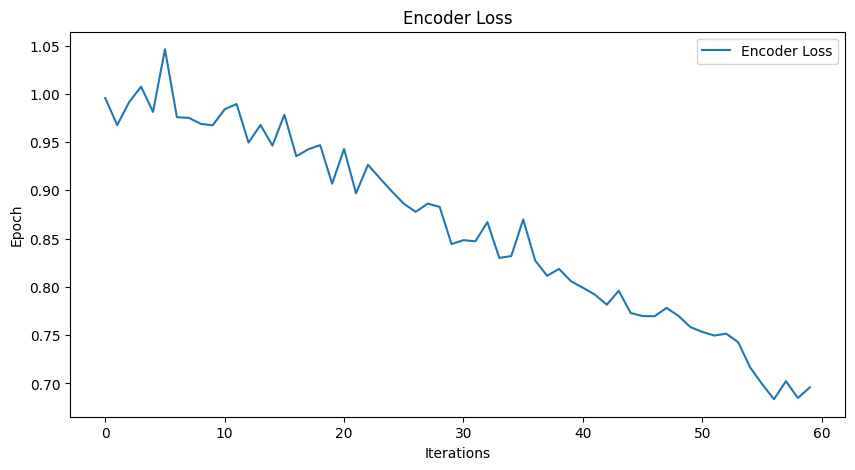

Epoch: 60 | Loss: 0.6986441016197205
Epoch: 61 | Loss: 0.6649765372276306
Epoch: 62 | Loss: 0.6727616786956787
Epoch: 63 | Loss: 0.6834362745285034
Epoch: 64 | Loss: 0.6560633182525635
Epoch: 65 | Loss: 0.6543500423431396
Epoch: 66 | Loss: 0.6795321106910706
Epoch: 67 | Loss: 0.6388992667198181
Epoch: 68 | Loss: 0.6570308804512024
Epoch: 69 | Loss: 0.6348109841346741


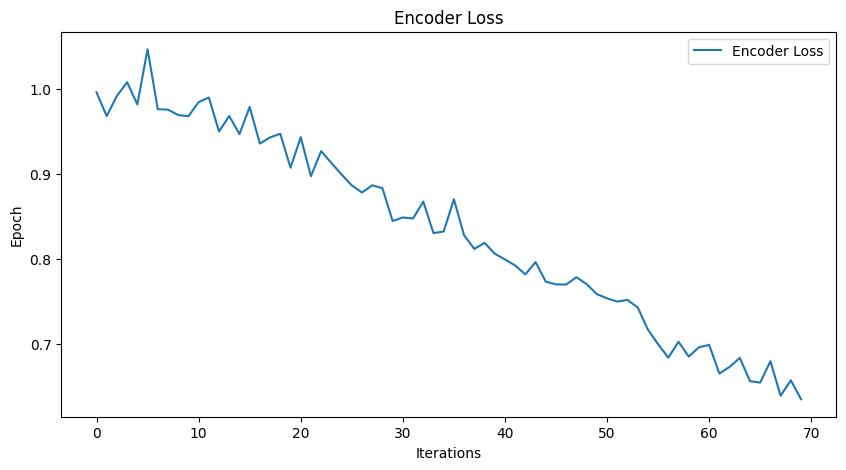

Epoch: 70 | Loss: 0.6379733681678772
Epoch: 71 | Loss: 0.6240319609642029
Epoch: 72 | Loss: 0.6271596550941467
Epoch: 73 | Loss: 0.6160933971405029
Epoch: 74 | Loss: 0.6044467091560364
Epoch: 75 | Loss: 0.6150490641593933
Epoch: 76 | Loss: 0.5854743123054504
Epoch: 77 | Loss: 0.6067773699760437
Epoch: 78 | Loss: 0.5633706450462341
Epoch: 79 | Loss: 0.5918548703193665


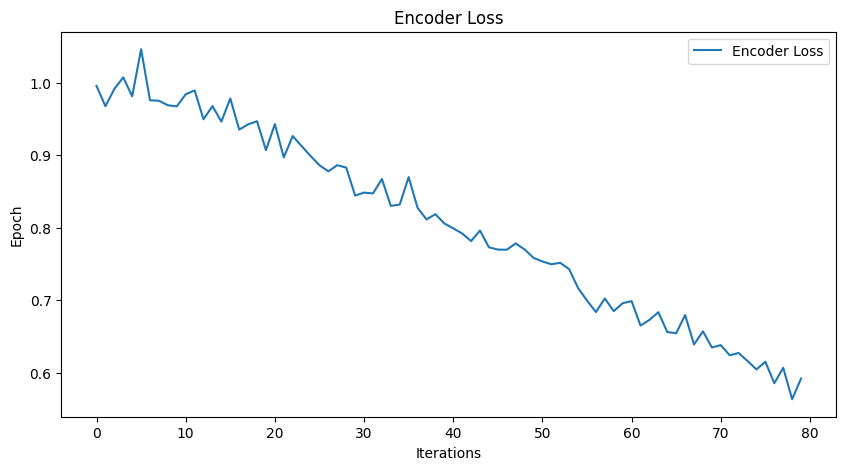

Epoch: 80 | Loss: 0.5659753084182739
Epoch: 81 | Loss: 0.565331220626831
Epoch: 82 | Loss: 0.5748558640480042
Epoch: 83 | Loss: 0.557963490486145
Epoch: 84 | Loss: 0.5398561954498291
Epoch: 85 | Loss: 0.5327896475791931
Epoch: 86 | Loss: 0.550569474697113
Epoch: 87 | Loss: 0.5323389768600464
Epoch: 88 | Loss: 0.5325450897216797
Epoch: 89 | Loss: 0.5273592472076416


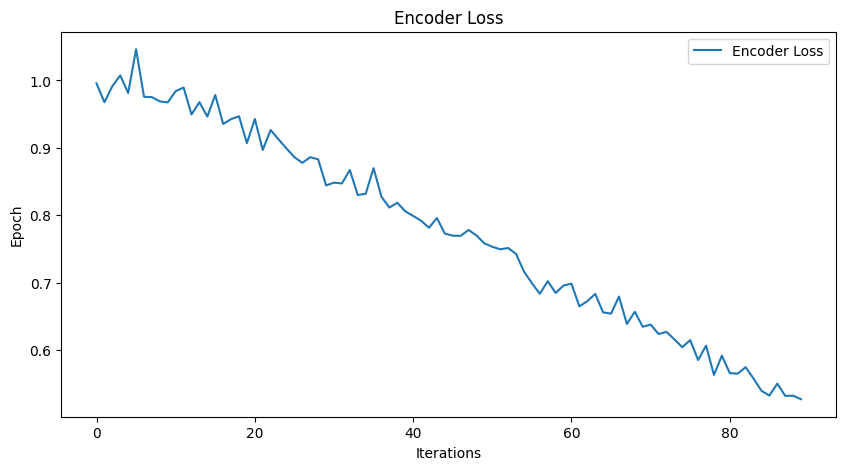

Epoch: 90 | Loss: 0.5282356142997742
Epoch: 91 | Loss: 0.5475631356239319
Epoch: 92 | Loss: 0.5163255929946899
Epoch: 93 | Loss: 0.5141144394874573
Epoch: 94 | Loss: 0.5127528309822083
Epoch: 95 | Loss: 0.49941426515579224
Epoch: 96 | Loss: 0.4976978003978729
Epoch: 97 | Loss: 0.49507051706314087
Epoch: 98 | Loss: 0.4727950394153595
Epoch: 99 | Loss: 0.4925065338611603


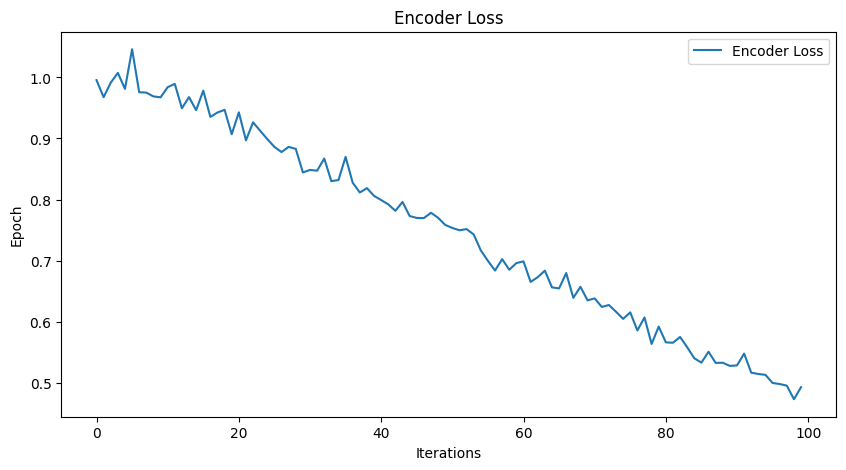

Epoch: 100 | Loss: 0.47907721996307373
Epoch: 101 | Loss: 0.4512486457824707
Epoch: 102 | Loss: 0.44333985447883606
Epoch: 103 | Loss: 0.48107942938804626
Epoch: 104 | Loss: 0.45176205039024353
Epoch: 105 | Loss: 0.44105225801467896
Epoch: 106 | Loss: 0.4578598141670227
Epoch: 107 | Loss: 0.4446764588356018
Epoch: 108 | Loss: 0.4585394859313965
Epoch: 109 | Loss: 0.4223300516605377


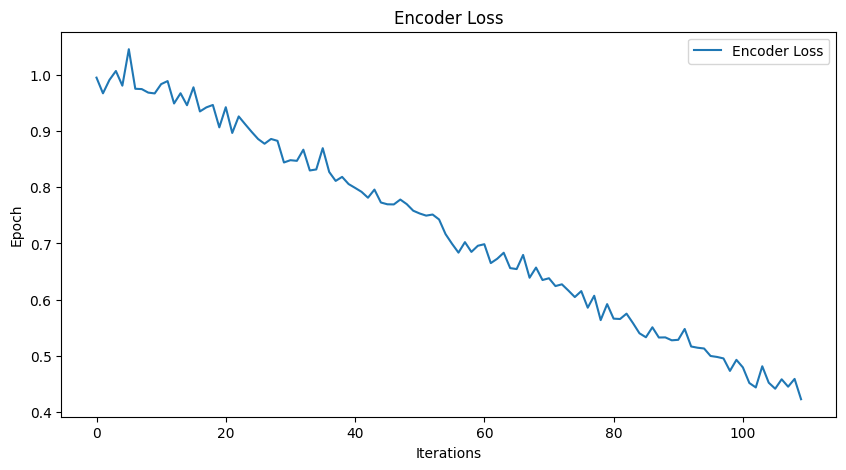

Epoch: 110 | Loss: 0.45718345046043396
Epoch: 111 | Loss: 0.4253743588924408
Epoch: 112 | Loss: 0.432729572057724
Epoch: 113 | Loss: 0.43010616302490234
Epoch: 114 | Loss: 0.40976762771606445
Epoch: 115 | Loss: 0.4132644832134247
Epoch: 116 | Loss: 0.40501120686531067
Epoch: 117 | Loss: 0.40199655294418335
Epoch: 118 | Loss: 0.4006548225879669
Epoch: 119 | Loss: 0.39569759368896484


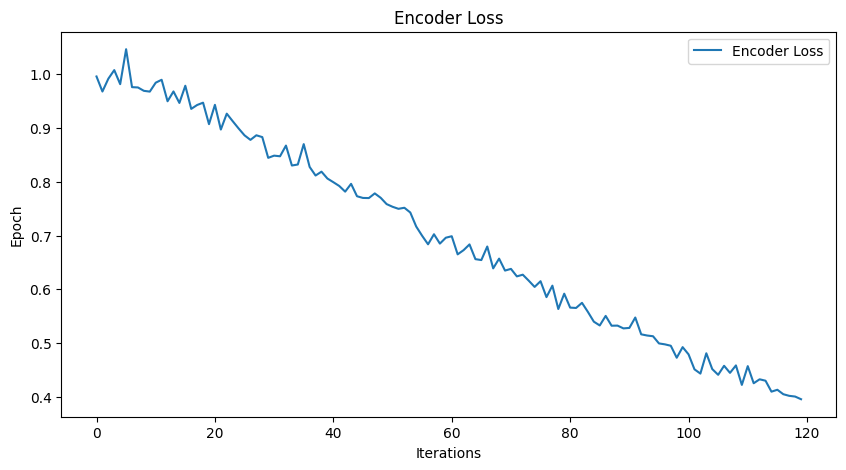

Epoch: 120 | Loss: 0.3999845087528229
Epoch: 121 | Loss: 0.4144536256790161
Epoch: 122 | Loss: 0.37119990587234497
Epoch: 123 | Loss: 0.39574238657951355
Epoch: 124 | Loss: 0.3578307628631592
Epoch: 125 | Loss: 0.38631004095077515
Epoch: 126 | Loss: 0.35630303621292114
Epoch: 127 | Loss: 0.4026290774345398
Epoch: 128 | Loss: 0.35599592328071594
Epoch: 129 | Loss: 0.3689614534378052


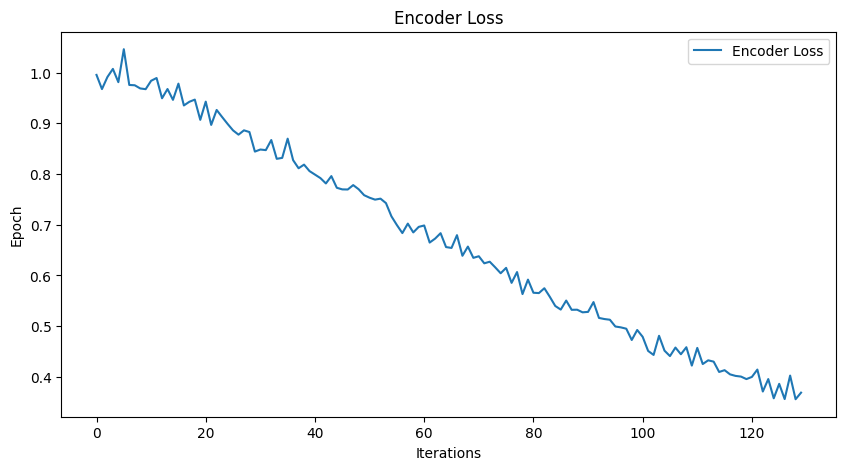

Epoch: 130 | Loss: 0.34566640853881836
Epoch: 131 | Loss: 0.3402583599090576
Epoch: 132 | Loss: 0.3527567982673645
Epoch: 133 | Loss: 0.3488484025001526
Epoch: 134 | Loss: 0.3311057388782501
Epoch: 135 | Loss: 0.3500675559043884
Epoch: 136 | Loss: 0.3214138150215149
Epoch: 137 | Loss: 0.3220921754837036
Epoch: 138 | Loss: 0.32635021209716797
Epoch: 139 | Loss: 0.32046499848365784


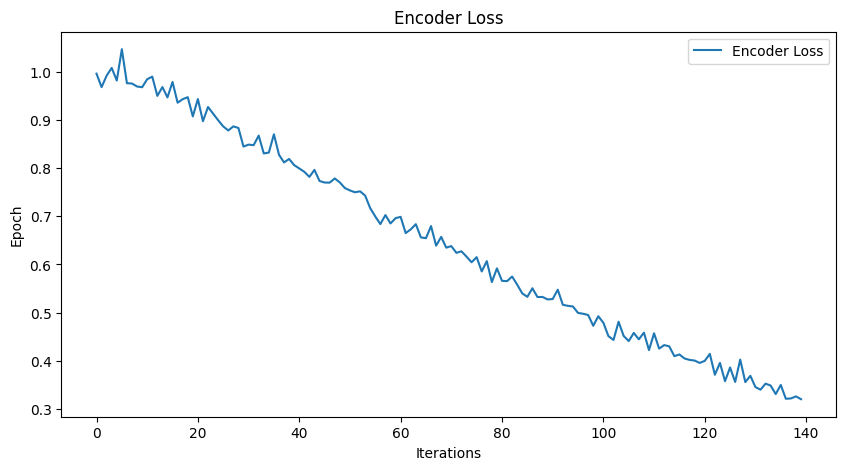

Epoch: 140 | Loss: 0.3311532437801361
Epoch: 141 | Loss: 0.3157815635204315
Epoch: 142 | Loss: 0.32223042845726013
Epoch: 143 | Loss: 0.3096642792224884
Epoch: 144 | Loss: 0.32729366421699524
Epoch: 145 | Loss: 0.3178521394729614
Epoch: 146 | Loss: 0.31179556250572205
Epoch: 147 | Loss: 0.3117702901363373
Epoch: 148 | Loss: 0.3148336112499237
Epoch: 149 | Loss: 0.3031439185142517


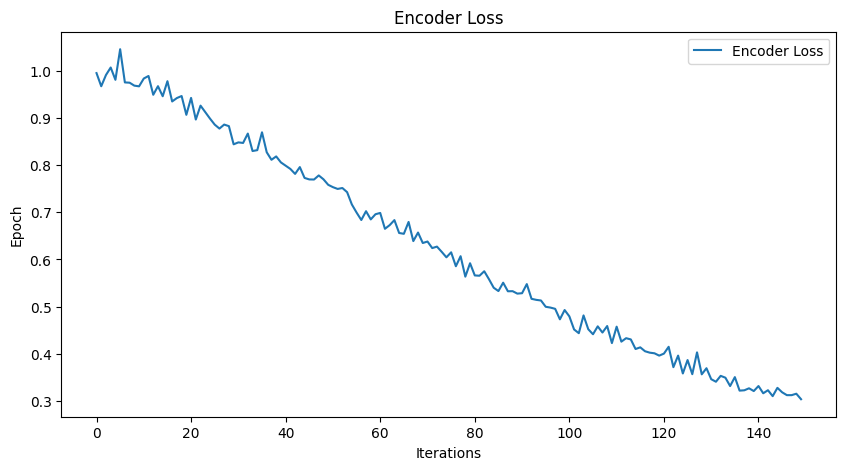

Epoch: 150 | Loss: 0.3053589165210724
Epoch: 151 | Loss: 0.2926274240016937
Epoch: 152 | Loss: 0.2979074716567993
Epoch: 153 | Loss: 0.3062381148338318
Epoch: 154 | Loss: 0.27674606442451477
Epoch: 155 | Loss: 0.27681297063827515
Epoch: 156 | Loss: 0.2783447504043579
Epoch: 157 | Loss: 0.2945294678211212
Epoch: 158 | Loss: 0.269346684217453
Epoch: 159 | Loss: 0.27955976128578186


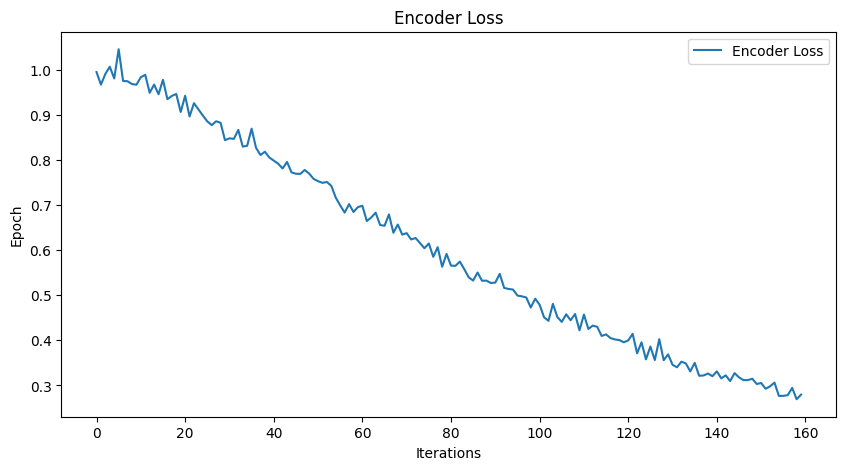

Epoch: 160 | Loss: 0.2636041045188904
Epoch: 161 | Loss: 0.2770598232746124
Epoch: 162 | Loss: 0.26224789023399353
Epoch: 163 | Loss: 0.27676627039909363
Epoch: 164 | Loss: 0.27398377656936646
Epoch: 165 | Loss: 0.2527160346508026
Epoch: 166 | Loss: 0.2570367157459259
Epoch: 167 | Loss: 0.25883686542510986
Epoch: 168 | Loss: 0.25542768836021423
Epoch: 169 | Loss: 0.25906258821487427


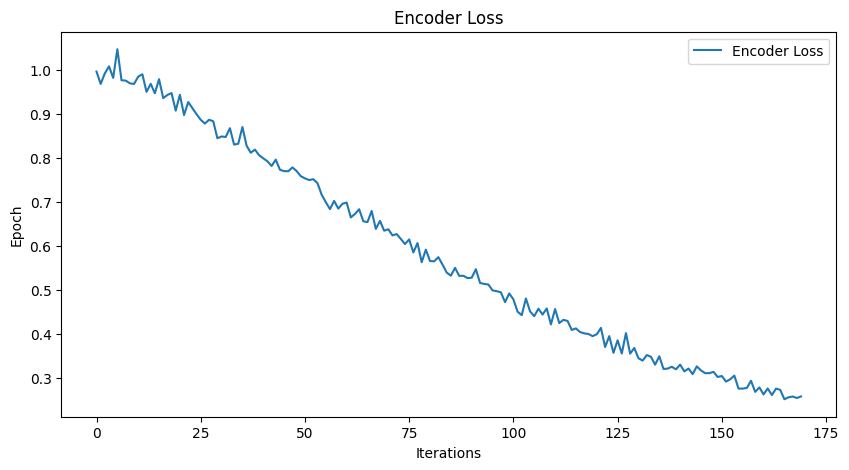

Epoch: 170 | Loss: 0.27031242847442627
Epoch: 171 | Loss: 0.261356920003891
Epoch: 172 | Loss: 0.25570836663246155
Epoch: 173 | Loss: 0.255113422870636
Epoch: 174 | Loss: 0.244567409157753
Epoch: 175 | Loss: 0.2432393580675125
Epoch: 176 | Loss: 0.23442967236042023
Epoch: 177 | Loss: 0.24101464450359344
Epoch: 178 | Loss: 0.22993998229503632
Epoch: 179 | Loss: 0.22363115847110748


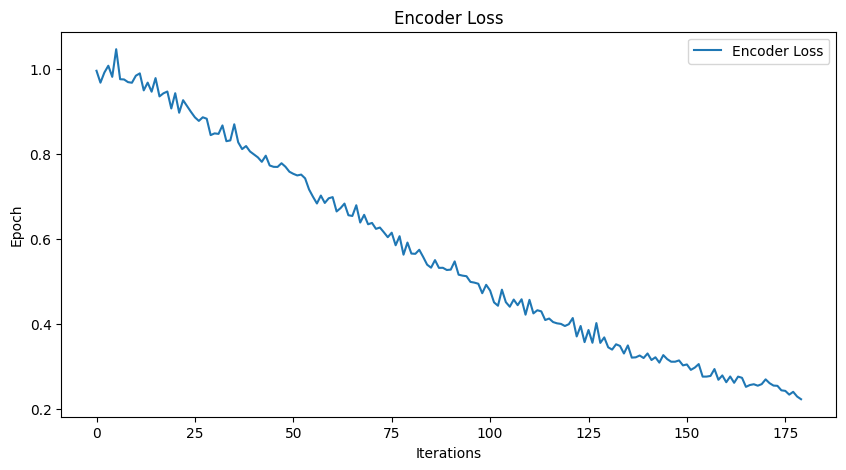

Epoch: 180 | Loss: 0.24324685335159302
Epoch: 181 | Loss: 0.2261292189359665
Epoch: 182 | Loss: 0.23277956247329712
Epoch: 183 | Loss: 0.23193056881427765
Epoch: 184 | Loss: 0.23082992434501648
Epoch: 185 | Loss: 0.2157953530550003
Epoch: 186 | Loss: 0.2142784297466278
Epoch: 187 | Loss: 0.2114190310239792
Epoch: 188 | Loss: 0.22139640152454376
Epoch: 189 | Loss: 0.22690702974796295


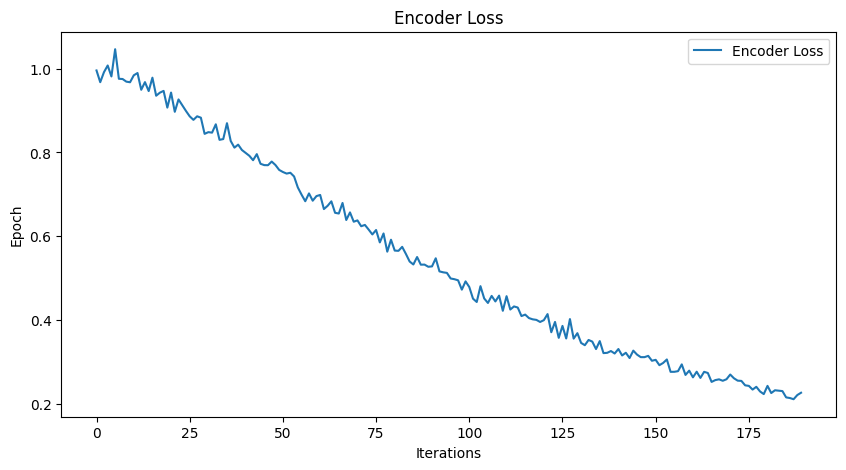

Epoch: 190 | Loss: 0.2208021879196167
Epoch: 191 | Loss: 0.20989039540290833
Epoch: 192 | Loss: 0.23172619938850403
Epoch: 193 | Loss: 0.2113388329744339
Epoch: 194 | Loss: 0.20100268721580505
Epoch: 195 | Loss: 0.20641957223415375
Epoch: 196 | Loss: 0.19504715502262115
Epoch: 197 | Loss: 0.2088724970817566
Epoch: 198 | Loss: 0.18996258080005646
Epoch: 199 | Loss: 0.2044263631105423


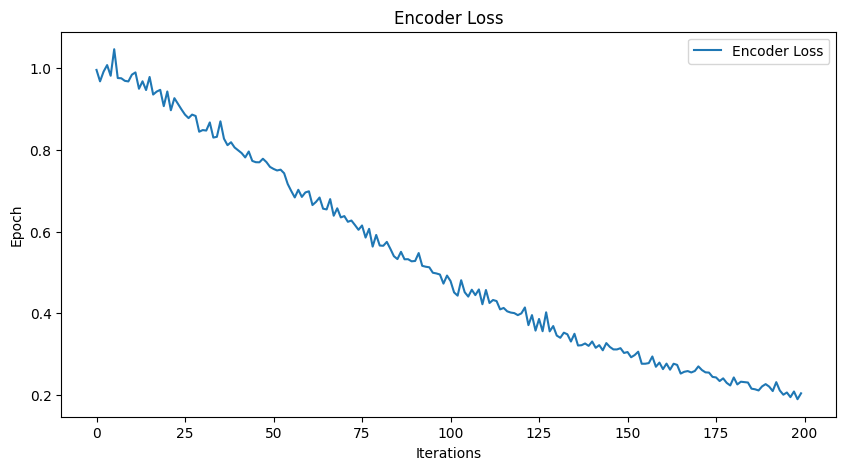

Epoch: 200 | Loss: 0.20944346487522125
Epoch: 201 | Loss: 0.1983899027109146
Epoch: 202 | Loss: 0.19710280001163483
Epoch: 203 | Loss: 0.18965153396129608
Epoch: 204 | Loss: 0.19585555791854858
Epoch: 205 | Loss: 0.17959341406822205
Epoch: 206 | Loss: 0.19285574555397034
Epoch: 207 | Loss: 0.18394164741039276
Epoch: 208 | Loss: 0.19801555573940277
Epoch: 209 | Loss: 0.19311818480491638


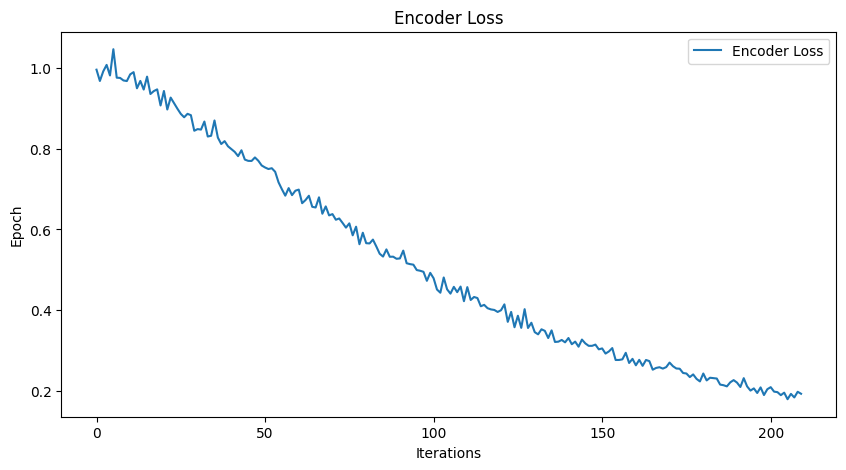

Epoch: 210 | Loss: 0.18735520541667938
Epoch: 211 | Loss: 0.18945670127868652
Epoch: 212 | Loss: 0.18309015035629272
Epoch: 213 | Loss: 0.1814812570810318
Epoch: 214 | Loss: 0.17480836808681488
Epoch: 215 | Loss: 0.17015887796878815
Epoch: 216 | Loss: 0.18222633004188538
Epoch: 217 | Loss: 0.1818435937166214
Epoch: 218 | Loss: 0.18022054433822632
Epoch: 219 | Loss: 0.18013544380664825


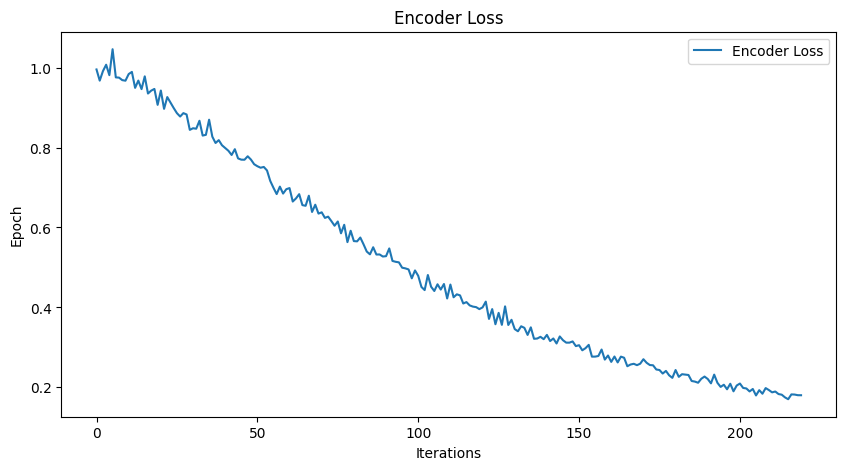

Epoch: 220 | Loss: 0.18160703778266907
Epoch: 221 | Loss: 0.1697428673505783
Epoch: 222 | Loss: 0.16873683035373688
Epoch: 223 | Loss: 0.17778587341308594
Epoch: 224 | Loss: 0.16244225203990936
Epoch: 225 | Loss: 0.1691005825996399
Epoch: 226 | Loss: 0.1686352640390396
Epoch: 227 | Loss: 0.1824178397655487
Epoch: 228 | Loss: 0.1739957481622696
Epoch: 229 | Loss: 0.17200370132923126


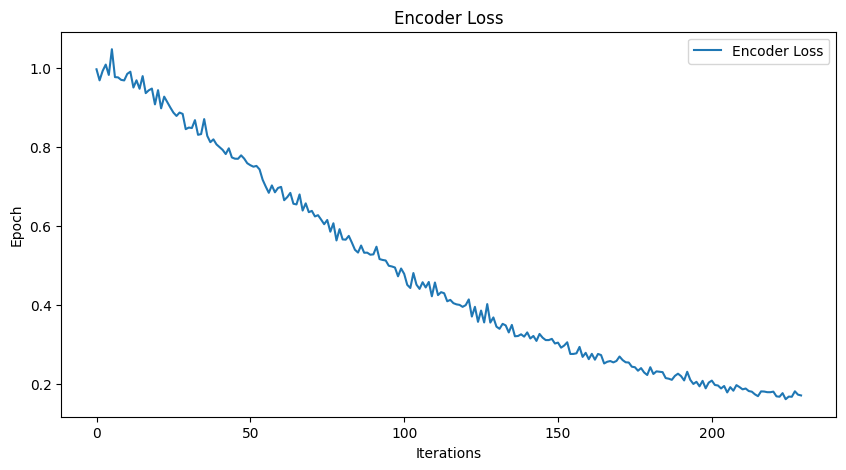

Epoch: 230 | Loss: 0.17296914756298065
Epoch: 231 | Loss: 0.15638482570648193
Epoch: 232 | Loss: 0.15554262697696686
Epoch: 233 | Loss: 0.16224735975265503
Epoch: 234 | Loss: 0.16143018007278442
Epoch: 235 | Loss: 0.15687870979309082
Epoch: 236 | Loss: 0.1582072526216507
Epoch: 237 | Loss: 0.15153421461582184
Epoch: 238 | Loss: 0.16243976354599
Epoch: 239 | Loss: 0.1452263444662094


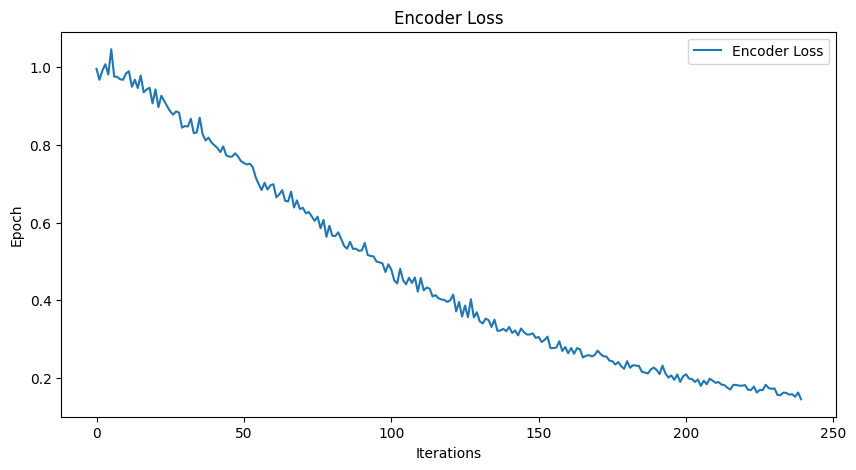

Epoch: 240 | Loss: 0.17365027964115143
Epoch: 241 | Loss: 0.15872733294963837
Epoch: 242 | Loss: 0.1686723679304123
Epoch: 243 | Loss: 0.1465628296136856
Epoch: 244 | Loss: 0.14399462938308716
Epoch: 245 | Loss: 0.14624527096748352
Epoch: 246 | Loss: 0.15144340693950653
Epoch: 247 | Loss: 0.14517377316951752
Epoch: 248 | Loss: 0.1415892392396927
Epoch: 249 | Loss: 0.15150195360183716


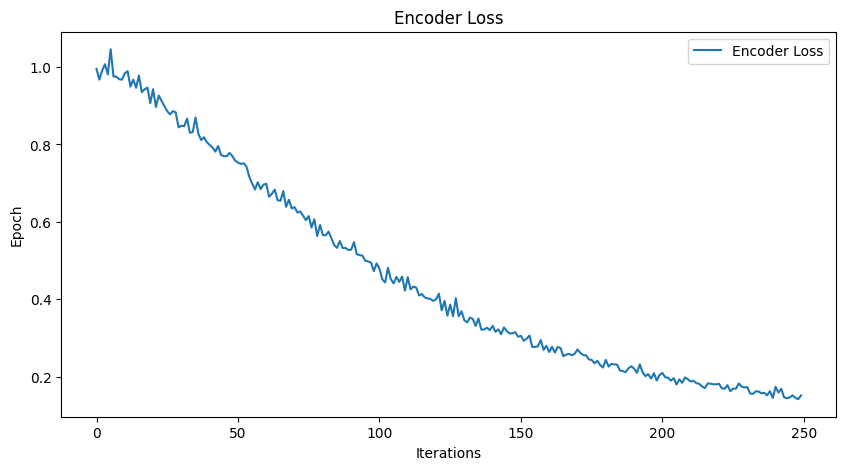

Epoch: 250 | Loss: 0.1500275433063507
Epoch: 251 | Loss: 0.1435307115316391
Epoch: 252 | Loss: 0.15541689097881317
Epoch: 253 | Loss: 0.15955081582069397
Epoch: 254 | Loss: 0.14014765620231628
Epoch: 255 | Loss: 0.14033980667591095
Epoch: 256 | Loss: 0.14030729234218597
Epoch: 257 | Loss: 0.15516945719718933
Epoch: 258 | Loss: 0.14845876395702362
Epoch: 259 | Loss: 0.1399742066860199


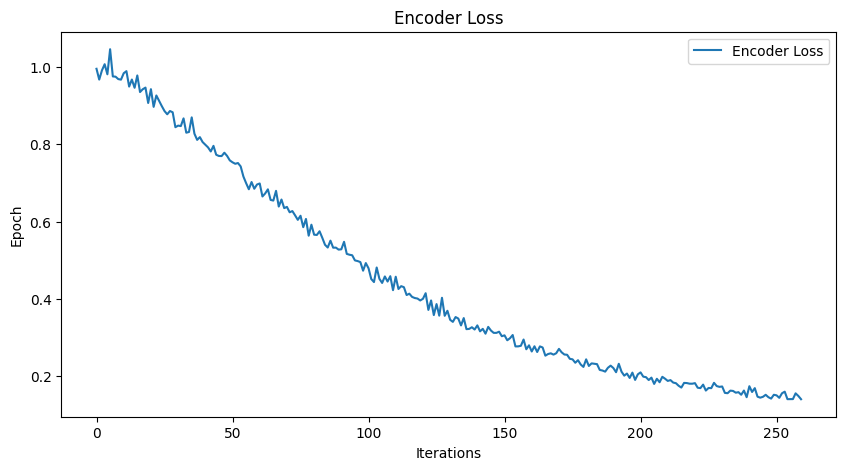

Epoch: 260 | Loss: 0.14564335346221924
Epoch: 261 | Loss: 0.13928773999214172
Epoch: 262 | Loss: 0.1458388864994049
Epoch: 263 | Loss: 0.14393536746501923
Epoch: 264 | Loss: 0.13948659598827362
Epoch: 265 | Loss: 0.1311039924621582
Epoch: 266 | Loss: 0.1385042816400528
Epoch: 267 | Loss: 0.1519484966993332
Epoch: 268 | Loss: 0.1427566558122635
Epoch: 269 | Loss: 0.14285999536514282


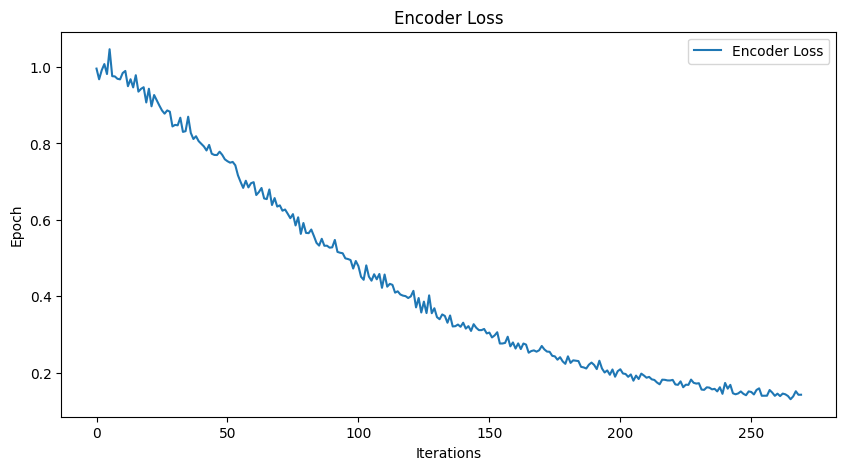

Epoch: 270 | Loss: 0.14041434228420258
Epoch: 271 | Loss: 0.14563842117786407
Epoch: 272 | Loss: 0.145143523812294
Epoch: 273 | Loss: 0.13175639510154724
Epoch: 274 | Loss: 0.14571431279182434
Epoch: 275 | Loss: 0.1348794847726822
Epoch: 276 | Loss: 0.13102518022060394
Epoch: 277 | Loss: 0.1336880475282669
Epoch: 278 | Loss: 0.1273900419473648
Epoch: 279 | Loss: 0.13619522750377655


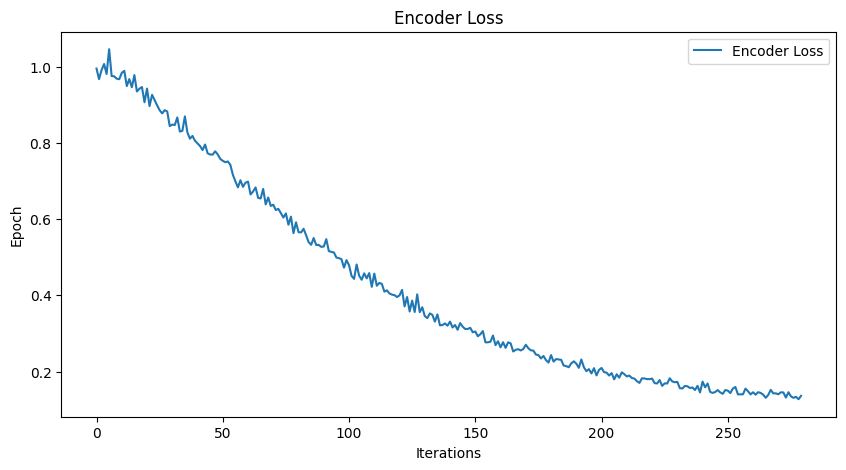

Epoch: 280 | Loss: 0.12978456914424896
Epoch: 281 | Loss: 0.1322685033082962
Epoch: 282 | Loss: 0.13971272110939026
Epoch: 283 | Loss: 0.13635244965553284
Epoch: 284 | Loss: 0.13229404389858246
Epoch: 285 | Loss: 0.13846243917942047
Epoch: 286 | Loss: 0.13289989531040192
Epoch: 287 | Loss: 0.129636749625206
Epoch: 288 | Loss: 0.13291247189044952
Epoch: 289 | Loss: 0.12839879095554352


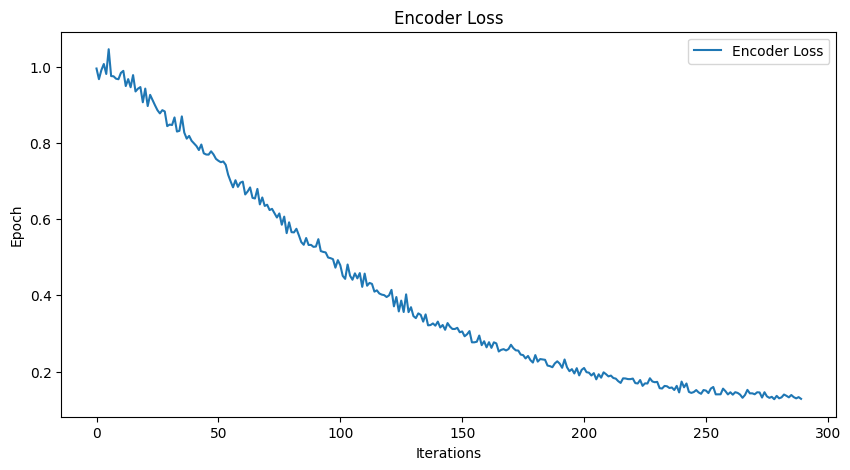

Epoch: 290 | Loss: 0.11858425289392471
Epoch: 291 | Loss: 0.12769995629787445
Epoch: 292 | Loss: 0.1221189945936203
Epoch: 293 | Loss: 0.1250699907541275
Epoch: 294 | Loss: 0.12537014484405518
Epoch: 295 | Loss: 0.12324678152799606
Epoch: 296 | Loss: 0.1297418475151062
Epoch: 297 | Loss: 0.13085143268108368
Epoch: 298 | Loss: 0.12529198825359344
Epoch: 299 | Loss: 0.11566793918609619


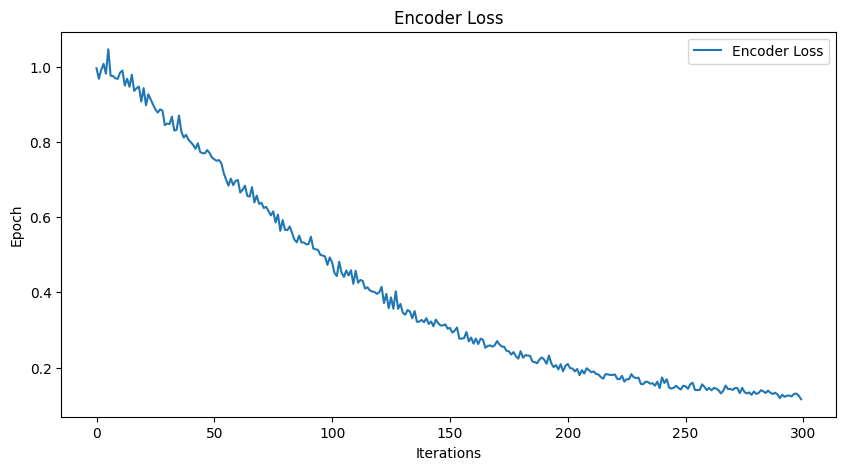

Epoch: 300 | Loss: 0.12030094861984253
Epoch: 301 | Loss: 0.12763996422290802
Epoch: 302 | Loss: 0.12220591306686401
Epoch: 303 | Loss: 0.13435202836990356
Epoch: 304 | Loss: 0.12076184153556824
Epoch: 305 | Loss: 0.12560604512691498
Epoch: 306 | Loss: 0.12771470844745636
Epoch: 307 | Loss: 0.12230685353279114
Epoch: 308 | Loss: 0.11143758893013
Epoch: 309 | Loss: 0.11475733667612076


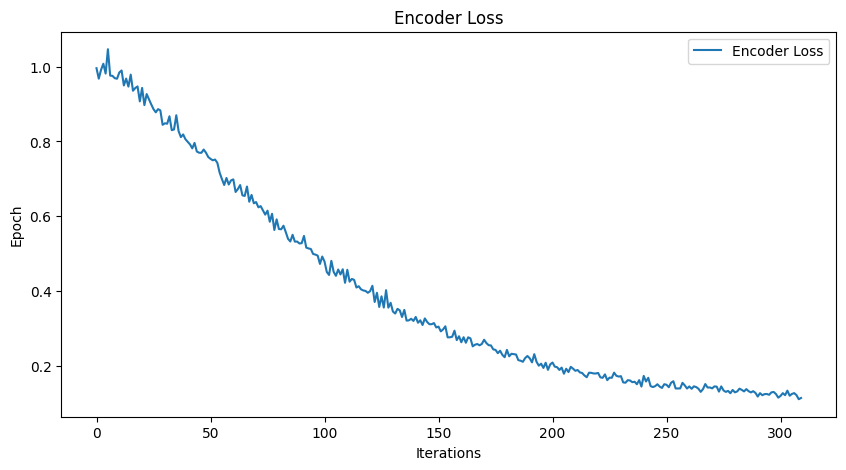

Epoch: 310 | Loss: 0.12410572171211243
Epoch: 311 | Loss: 0.11608193814754486
Epoch: 312 | Loss: 0.12266532331705093
Epoch: 313 | Loss: 0.12431732565164566
Epoch: 314 | Loss: 0.1188046932220459
Epoch: 315 | Loss: 0.12581133842468262
Epoch: 316 | Loss: 0.11995140463113785
Epoch: 317 | Loss: 0.11948556452989578
Epoch: 318 | Loss: 0.12192074954509735
Epoch: 319 | Loss: 0.10480859875679016


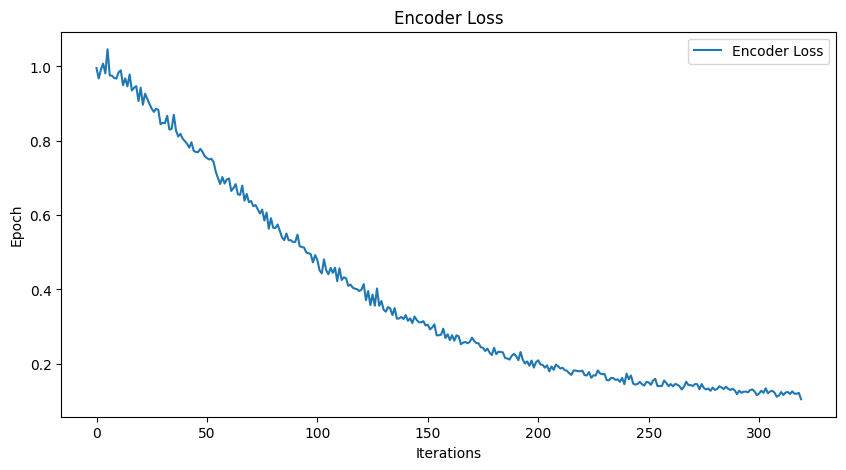

Epoch: 320 | Loss: 0.1221926361322403
Epoch: 321 | Loss: 0.11851271241903305
Epoch: 322 | Loss: 0.11070115119218826
Epoch: 323 | Loss: 0.11002108454704285
Epoch: 324 | Loss: 0.12500563263893127
Epoch: 325 | Loss: 0.10551991313695908
Epoch: 326 | Loss: 0.11853278428316116
Epoch: 327 | Loss: 0.11026172339916229
Epoch: 328 | Loss: 0.11379536986351013
Epoch: 329 | Loss: 0.11789143830537796


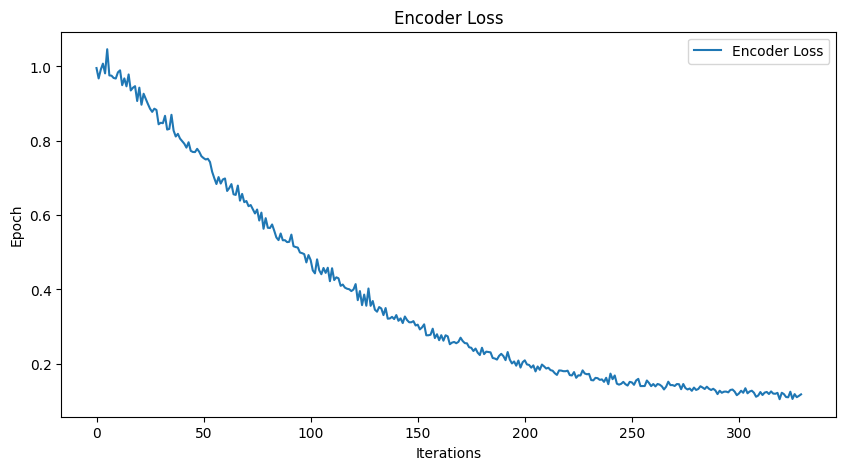

Epoch: 330 | Loss: 0.11336356401443481
Epoch: 331 | Loss: 0.11471419036388397
Epoch: 332 | Loss: 0.1022367998957634
Epoch: 333 | Loss: 0.11430342495441437
Epoch: 334 | Loss: 0.1077004224061966
Epoch: 335 | Loss: 0.11322221159934998
Epoch: 336 | Loss: 0.1195179671049118
Epoch: 337 | Loss: 0.1151956096291542
Epoch: 338 | Loss: 0.11494293808937073
Epoch: 339 | Loss: 0.10626004636287689


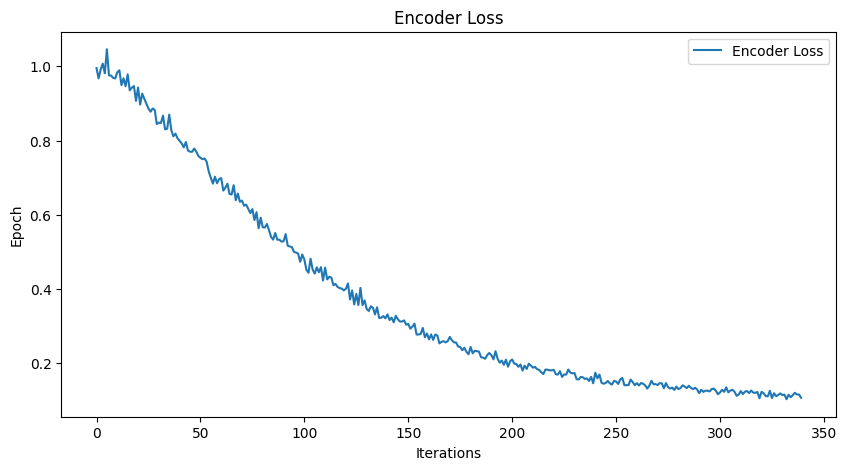

Epoch: 340 | Loss: 0.11073474586009979
Epoch: 341 | Loss: 0.11087362468242645
Epoch: 342 | Loss: 0.11194110661745071
Epoch: 343 | Loss: 0.1184198409318924
Epoch: 344 | Loss: 0.10302527248859406
Epoch: 345 | Loss: 0.11282926052808762
Epoch: 346 | Loss: 0.09973937273025513
Epoch: 347 | Loss: 0.10169719904661179
Epoch: 348 | Loss: 0.10107477009296417
Epoch: 349 | Loss: 0.10877594351768494


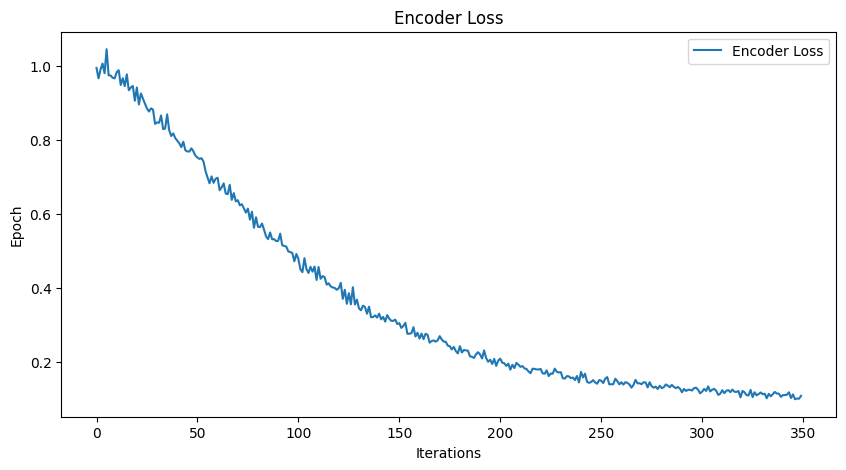

Epoch: 350 | Loss: 0.10408176481723785
Epoch: 351 | Loss: 0.09922529011964798
Epoch: 352 | Loss: 0.10321122407913208
Epoch: 353 | Loss: 0.0977233275771141
Epoch: 354 | Loss: 0.11232936382293701
Epoch: 355 | Loss: 0.11287132650613785
Epoch: 356 | Loss: 0.10355927050113678
Epoch: 357 | Loss: 0.11047089844942093
Epoch: 358 | Loss: 0.10034634172916412
Epoch: 359 | Loss: 0.10707082599401474


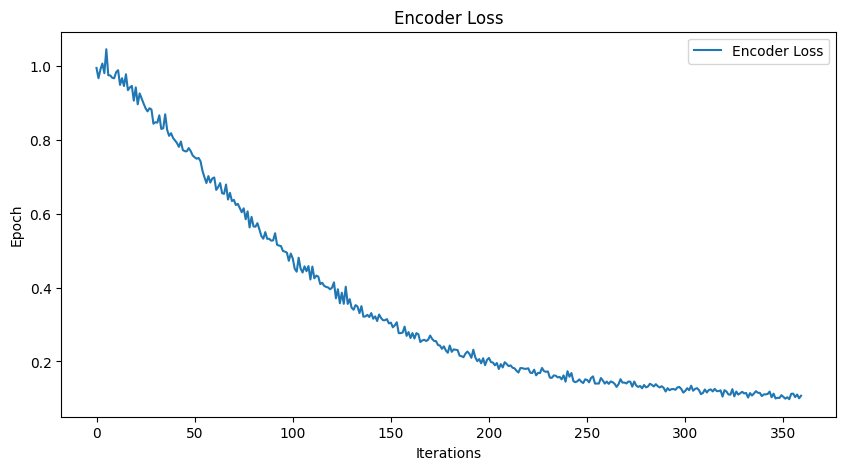

Epoch: 360 | Loss: 0.11347099393606186
Epoch: 361 | Loss: 0.105190210044384
Epoch: 362 | Loss: 0.09748616069555283
Epoch: 363 | Loss: 0.11388323456048965
Epoch: 364 | Loss: 0.11015233397483826
Epoch: 365 | Loss: 0.09953118860721588
Epoch: 366 | Loss: 0.09713296592235565
Epoch: 367 | Loss: 0.11359710991382599
Epoch: 368 | Loss: 0.10020335763692856
Epoch: 369 | Loss: 0.10180220007896423


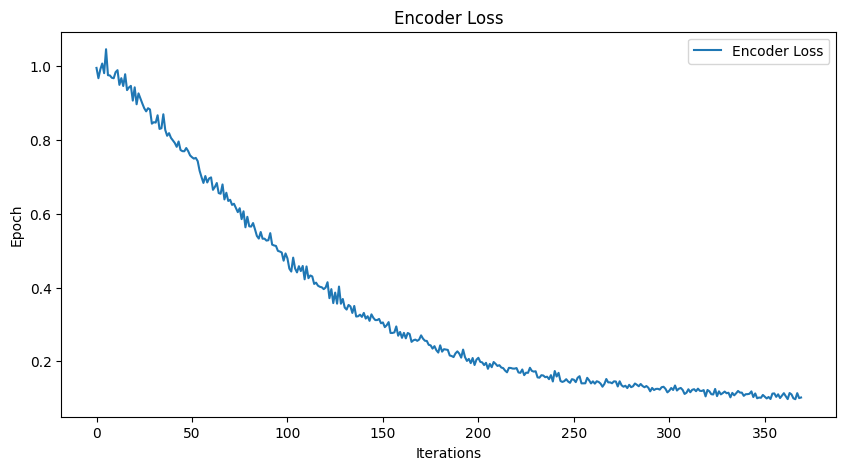

Epoch: 370 | Loss: 0.10358171164989471
Epoch: 371 | Loss: 0.10233443975448608
Epoch: 372 | Loss: 0.0986054465174675
Epoch: 373 | Loss: 0.099152110517025
Epoch: 374 | Loss: 0.10511868447065353
Epoch: 375 | Loss: 0.10041533410549164
Epoch: 376 | Loss: 0.0963476225733757
Epoch: 377 | Loss: 0.10625027120113373
Epoch: 378 | Loss: 0.10063198953866959
Epoch: 379 | Loss: 0.10077078640460968


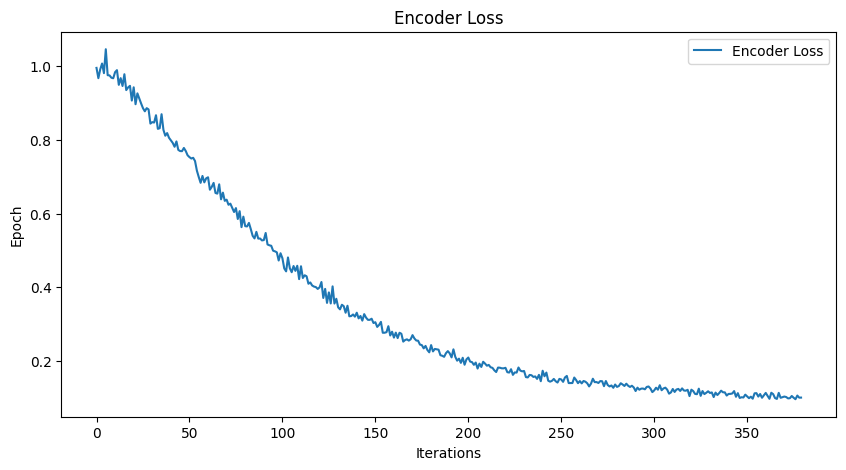

Epoch: 380 | Loss: 0.10455293208360672
Epoch: 381 | Loss: 0.0969611406326294
Epoch: 382 | Loss: 0.10189125686883926
Epoch: 383 | Loss: 0.10646338760852814
Epoch: 384 | Loss: 0.10485894232988358
Epoch: 385 | Loss: 0.09613911062479019
Epoch: 386 | Loss: 0.09767349809408188
Epoch: 387 | Loss: 0.09210634231567383
Epoch: 388 | Loss: 0.09928646683692932
Epoch: 389 | Loss: 0.10192612558603287


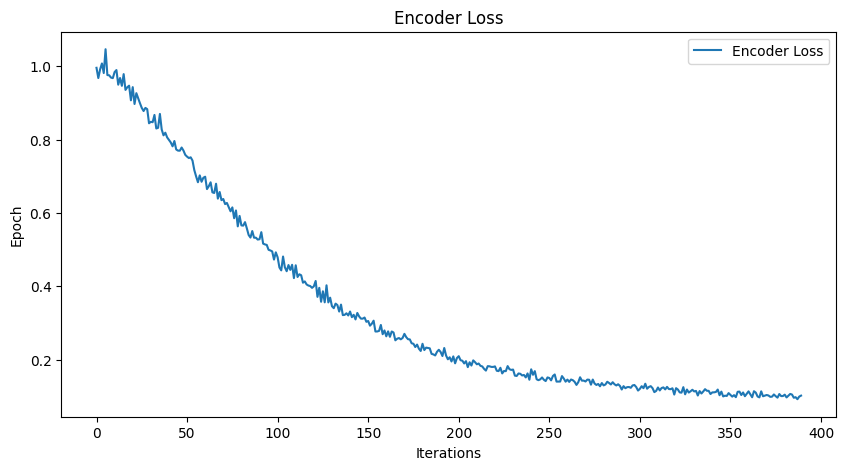

Epoch: 390 | Loss: 0.10511982440948486
Epoch: 391 | Loss: 0.10499505698680878
Epoch: 392 | Loss: 0.09681902825832367
Epoch: 393 | Loss: 0.09184347093105316
Epoch: 394 | Loss: 0.10569869726896286
Epoch: 395 | Loss: 0.08921128511428833
Epoch: 396 | Loss: 0.10538899898529053
Epoch: 397 | Loss: 0.0921693965792656
Epoch: 398 | Loss: 0.11157555878162384
Epoch: 399 | Loss: 0.08758513629436493


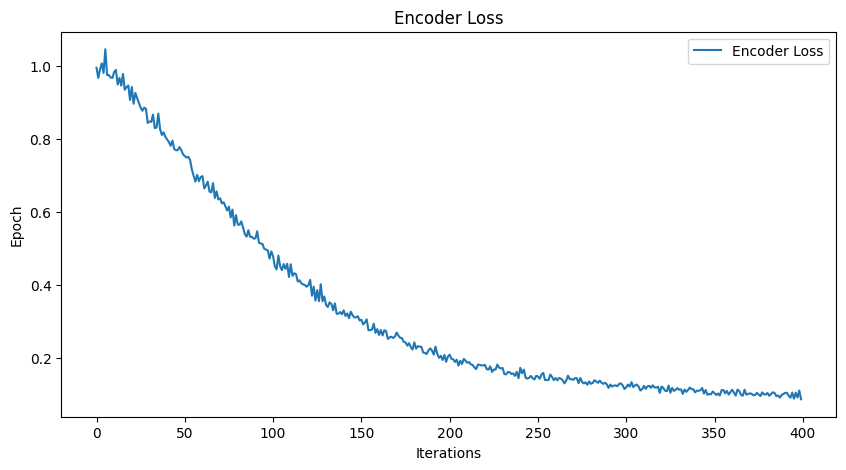

Epoch: 400 | Loss: 0.09102646261453629
Epoch: 401 | Loss: 0.09197838604450226
Epoch: 402 | Loss: 0.09620247036218643
Epoch: 403 | Loss: 0.0946340560913086
Epoch: 404 | Loss: 0.10417024791240692
Epoch: 405 | Loss: 0.09637539833784103
Epoch: 406 | Loss: 0.10236943513154984
Epoch: 407 | Loss: 0.09411896020174026
Epoch: 408 | Loss: 0.09366824477910995
Epoch: 409 | Loss: 0.09494377672672272


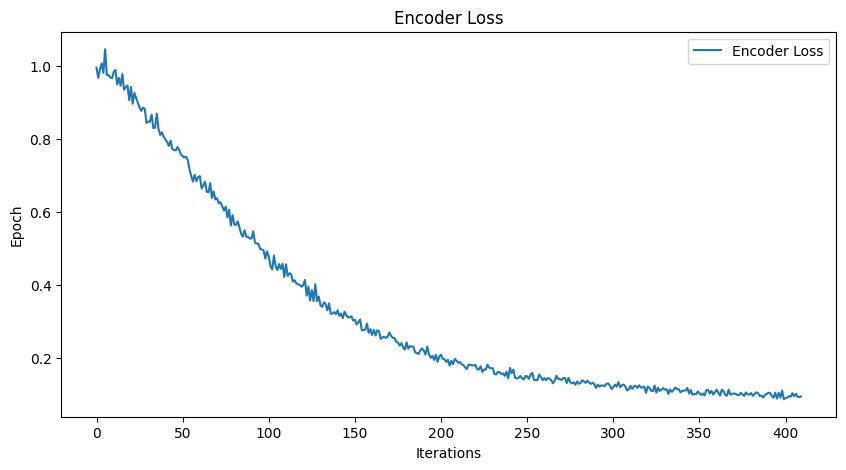

Epoch: 410 | Loss: 0.08983666449785233
Epoch: 411 | Loss: 0.09511452168226242
Epoch: 412 | Loss: 0.09289916604757309
Epoch: 413 | Loss: 0.10101843625307083
Epoch: 414 | Loss: 0.09449039399623871
Epoch: 415 | Loss: 0.10401053726673126
Epoch: 416 | Loss: 0.10481966286897659
Epoch: 417 | Loss: 0.10285567492246628
Epoch: 418 | Loss: 0.08946342766284943
Epoch: 419 | Loss: 0.1006026640534401


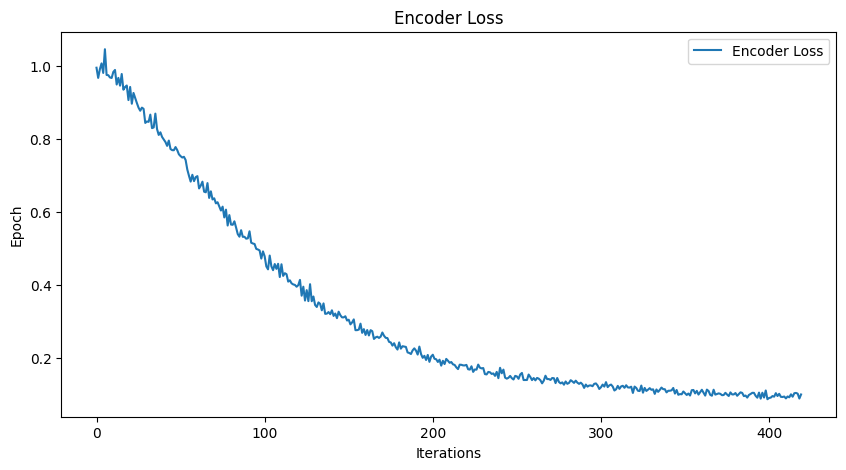

Epoch: 420 | Loss: 0.0965859591960907
Epoch: 421 | Loss: 0.0964307188987732
Epoch: 422 | Loss: 0.09813029319047928
Epoch: 423 | Loss: 0.10465316474437714
Epoch: 424 | Loss: 0.10425266623497009
Epoch: 425 | Loss: 0.088497593998909
Epoch: 426 | Loss: 0.08660329133272171
Epoch: 427 | Loss: 0.09385260194540024
Epoch: 428 | Loss: 0.09813839197158813
Epoch: 429 | Loss: 0.08780740201473236


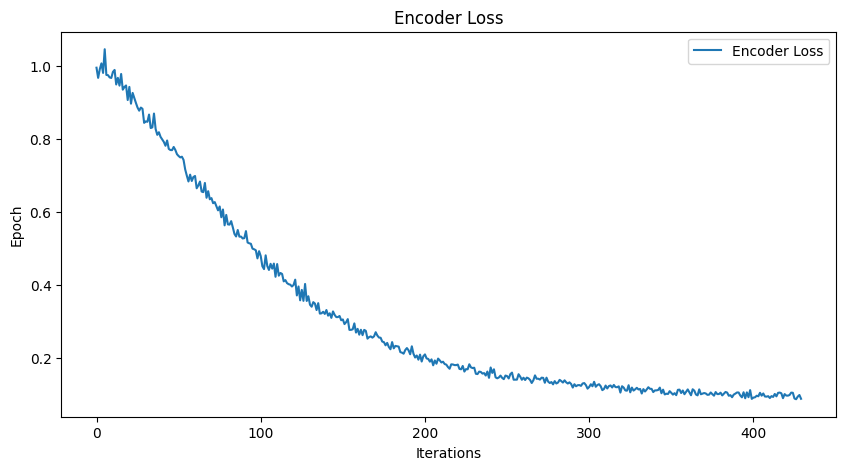

Epoch: 430 | Loss: 0.09490650147199631
Epoch: 431 | Loss: 0.09504679590463638
Epoch: 432 | Loss: 0.08175649493932724
Epoch: 433 | Loss: 0.08912273496389389
Epoch: 434 | Loss: 0.09561929851770401
Epoch: 435 | Loss: 0.0904974490404129
Epoch: 436 | Loss: 0.0899198055267334
Epoch: 437 | Loss: 0.09399405121803284
Epoch: 438 | Loss: 0.0937439426779747
Epoch: 439 | Loss: 0.10284268110990524


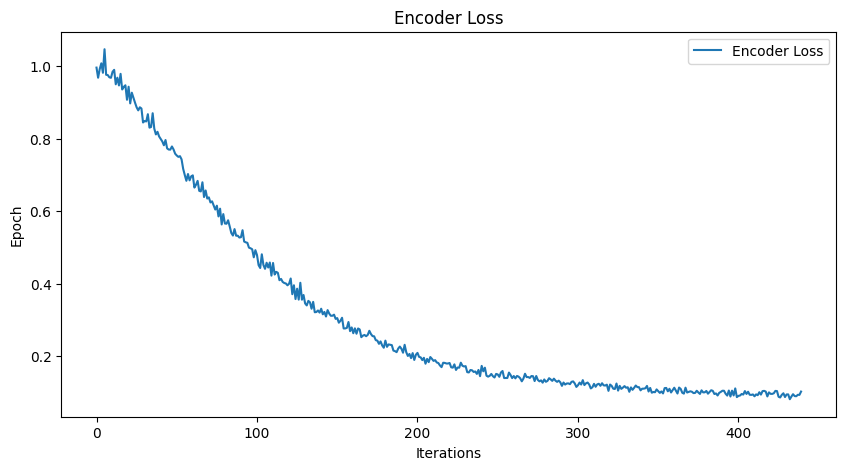

Epoch: 440 | Loss: 0.08588611334562302
Epoch: 441 | Loss: 0.1041550263762474
Epoch: 442 | Loss: 0.0938435047864914
Epoch: 443 | Loss: 0.0881412923336029
Epoch: 444 | Loss: 0.09229787439107895
Epoch: 445 | Loss: 0.09069174528121948
Epoch: 446 | Loss: 0.09263543039560318
Epoch: 447 | Loss: 0.09920258820056915
Epoch: 448 | Loss: 0.0830656960606575
Epoch: 449 | Loss: 0.08898799121379852


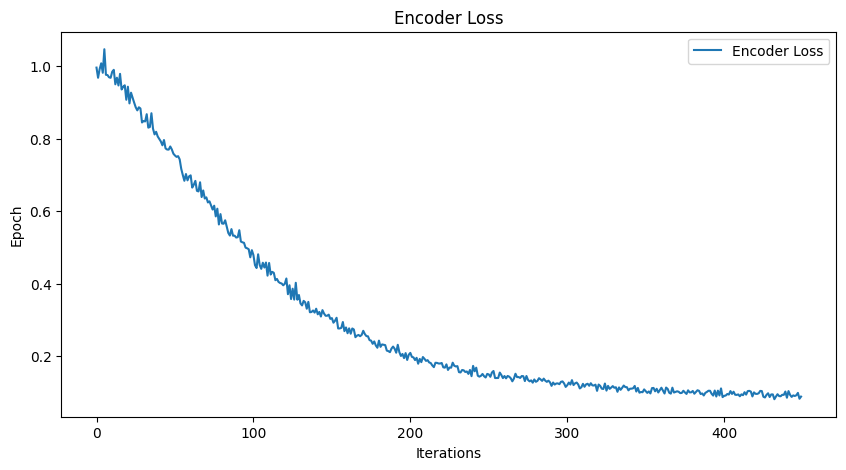

Epoch: 450 | Loss: 0.09540452063083649
Epoch: 451 | Loss: 0.09086877852678299
Epoch: 452 | Loss: 0.09088071435689926
Epoch: 453 | Loss: 0.09306807816028595
Epoch: 454 | Loss: 0.08374082297086716
Epoch: 455 | Loss: 0.08499572426080704
Epoch: 456 | Loss: 0.07958114147186279
Epoch: 457 | Loss: 0.08454243093729019
Epoch: 458 | Loss: 0.09074508398771286
Epoch: 459 | Loss: 0.09138139337301254


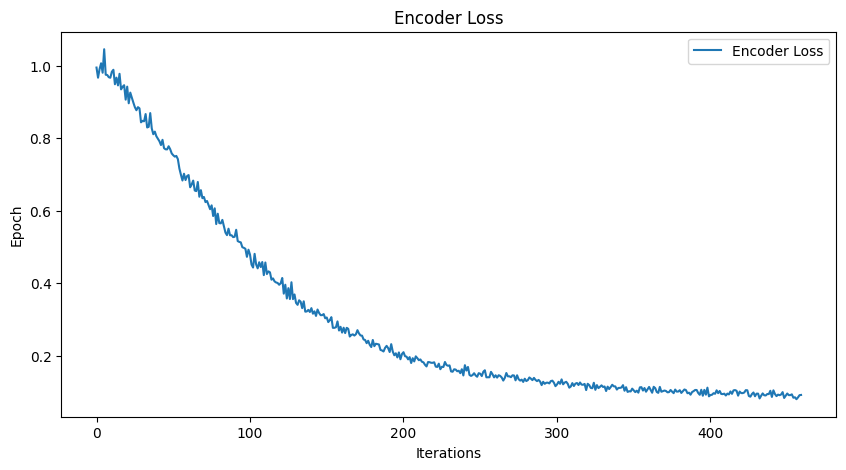

Epoch: 460 | Loss: 0.08611486852169037
Epoch: 461 | Loss: 0.08723969012498856
Epoch: 462 | Loss: 0.08693232387304306
Epoch: 463 | Loss: 0.09326761960983276
Epoch: 464 | Loss: 0.08588749170303345
Epoch: 465 | Loss: 0.08831262588500977
Epoch: 466 | Loss: 0.07661264389753342
Epoch: 467 | Loss: 0.08655159175395966
Epoch: 468 | Loss: 0.07949887216091156
Epoch: 469 | Loss: 0.08095178753137589


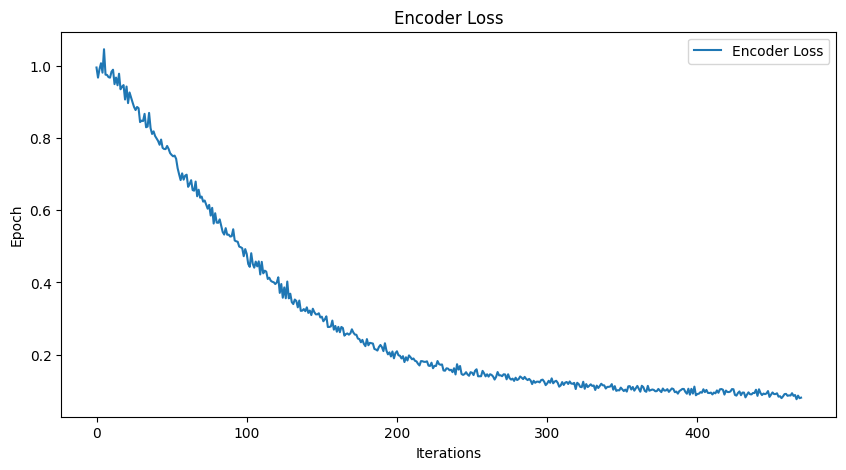

Epoch: 470 | Loss: 0.09195230156183243
Epoch: 471 | Loss: 0.08016354590654373
Epoch: 472 | Loss: 0.08484551310539246
Epoch: 473 | Loss: 0.08412881195545197
Epoch: 474 | Loss: 0.07920260727405548
Epoch: 475 | Loss: 0.08487037569284439
Epoch: 476 | Loss: 0.08670051395893097
Epoch: 477 | Loss: 0.08896506577730179
Epoch: 478 | Loss: 0.0926462858915329
Epoch: 479 | Loss: 0.08584748208522797


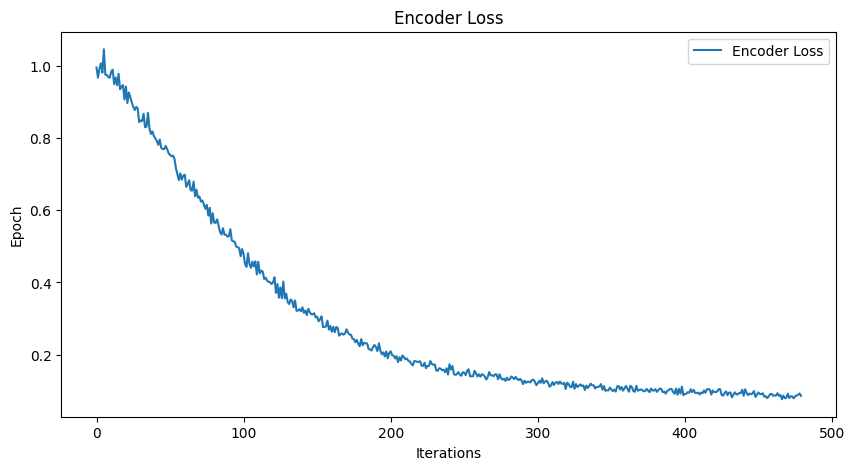

Epoch: 480 | Loss: 0.08327700197696686
Epoch: 481 | Loss: 0.0812186524271965
Epoch: 482 | Loss: 0.08779467642307281
Epoch: 483 | Loss: 0.0901934951543808
Epoch: 484 | Loss: 0.07981759309768677
Epoch: 485 | Loss: 0.09396393597126007
Epoch: 486 | Loss: 0.07877793908119202
Epoch: 487 | Loss: 0.08825501799583435
Epoch: 488 | Loss: 0.08110880851745605
Epoch: 489 | Loss: 0.09102848172187805


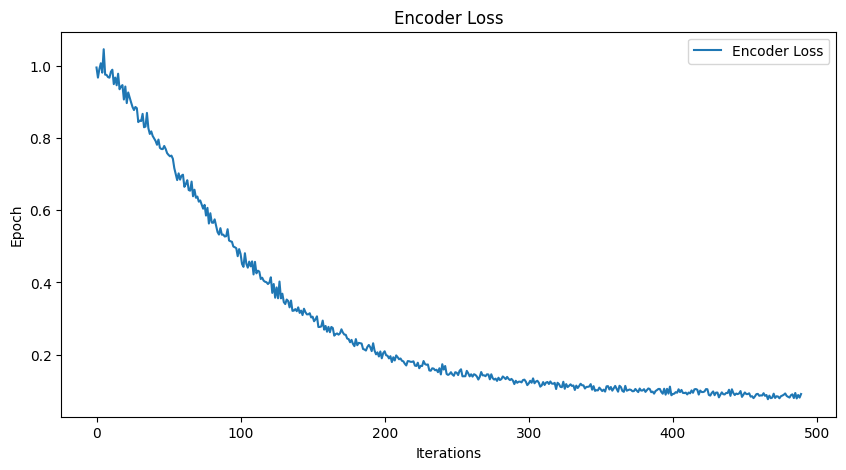

Epoch: 490 | Loss: 0.090455062687397
Epoch: 491 | Loss: 0.10113037377595901
Epoch: 492 | Loss: 0.09064384549856186
Epoch: 493 | Loss: 0.08165007084608078
Epoch: 494 | Loss: 0.07642646878957748
Epoch: 495 | Loss: 0.07600493729114532
Epoch: 496 | Loss: 0.08604321628808975
Epoch: 497 | Loss: 0.08514714986085892
Epoch: 498 | Loss: 0.08712103217840195
Epoch: 499 | Loss: 0.082986980676651


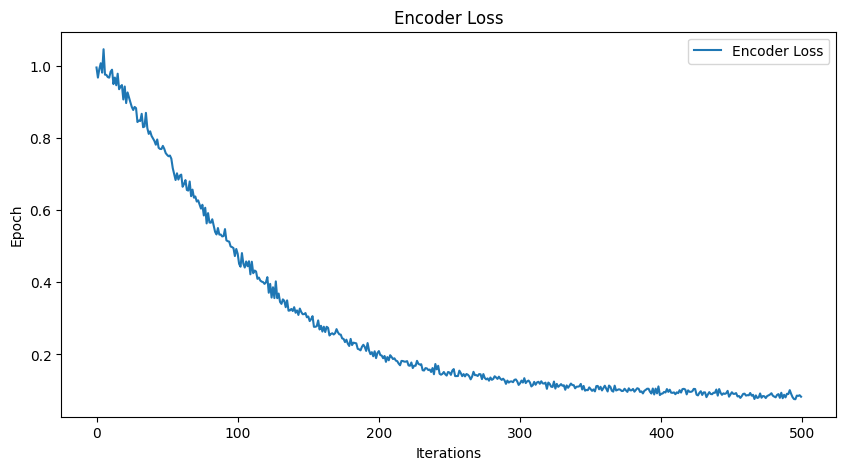

In [33]:
print('Original input data shape:', training_inputs.shape)
print('Original outputs data shape:', training_outputs.shape)

# Setup model and train it
encoder = Encoder(training_inputs, training_outputs)
trained_model = encoder.train(batch_size=batch_size, num_epochs=num_epochs)


# Testing the model

In [41]:
# Try model predicting data from a dataloader
def predicted_actual_values(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    all_preds = []
    all_actual = []
    model.eval()
    with torch.no_grad():
        for data, targets in dataloader:
            # Ensure data is on the same device as the model
            data = data.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)

            outputs = model(data)
            all_preds.extend(outputs.cpu().numpy())
            all_actual.extend(targets.cpu().numpy())

    return np.array(all_preds), np.array(all_actual)

# Compute accuracy of model predictions based on predictions and actual values
def compute_rmse(predictions, actual):
    rmse = mean_squared_error(actual, predictions, squared=False)
    return rmse

# Plot a confusion matrix, visualising the model's predictions compared to the true labels
def plot_confusion_matrix(predictions, actual):
    cm = confusion_matrix(actual, predictions)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Try running trained model on test data
def test_trained_model(model, batch_size):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    x_test = test_inputs
    y_test = test_outputs

    # Create tensor from training inputs and targets
    x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float()
    test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)
    # Create dataloader from tensor
    test_dataloader = torch.utils.data.DataLoader(test_data_tensor, batch_size, shuffle=True)
    
    # Plot confusion matrix and get predicted/actual results
    predicted_results, actual_results = predicted_actual_values(model, test_dataloader)
    print('Predictions:')
    print(predicted_results[0][0:10])
    print('Actual:')
    print(actual_results[0][0:10])

    rmse = compute_rmse(predicted_results, actual_results)
    print('Achieved RMSE:', "%.2f" % rmse)
    
    #plot_confusion_matrix(predicted_results, actual_results)

In [42]:
# Load model
print('Input training shape:', training_inputs.shape)
#print(reduce_outputs_to_ROIs(training_outputs).shape)
print('Input test shape:', test_inputs.shape)
#print(reduce_outputs_to_ROIs(test_outputs).shape)

model = ModifiedAlexNet()

model.load_state_dict(torch.load('./trained_models/trainedmodel_11_29_23_18_20_59.pth'))

# Test model
test_trained_model(model=model, batch_size=batch_size)

Input training shape: (1390, 128, 128)
Input test shape: (105, 128, 128)


d:\Users\Simon\ITU\MSc\ADMAL\ADMAL-Project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Predictions:
[-0.13123974  0.412797   -0.04191406 -0.18285981  0.25868553  0.2977059
  0.01566989  0.23268731  0.21442176  0.45112365]
Actual:
[-0.13184871 -0.32432845  0.5984662   0.14602901 -0.00967172  0.10134874
 -0.06827882  0.13302396  0.43024874  0.4339053 ]
Achieved RMSE: 0.52


# Visualize the intermediate outputs

In [ ]:
x_test_tensor = torch.from_numpy(test_inputs).float()


y_test_tensor = torch.from_numpy(test_outputs).float()
#test_data_tensor = torch.utils.data.TensorDataset(x_test_tensor, y_test_tensor)

final_output, intermediate_outputs = model.forward_with_intermediate(x_test_tensor)

print(intermediate_outputs.keys())

print(intermediate_outputs['features_0'].shape)

print(intermediate_outputs['features_0'][6])


dict_keys(['features_0', 'features_1', 'features_2', 'features_3', 'features_4', 'features_5', 'features_6', 'features_7', 'features_8', 'features_9', 'features_10', 'features_11', 'features_12', 'classifier_0', 'classifier_1', 'classifier_2', 'classifier_3', 'classifier_4', 'classifier_5', 'classifier_6'])
torch.Size([105, 64, 31, 31])
tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000

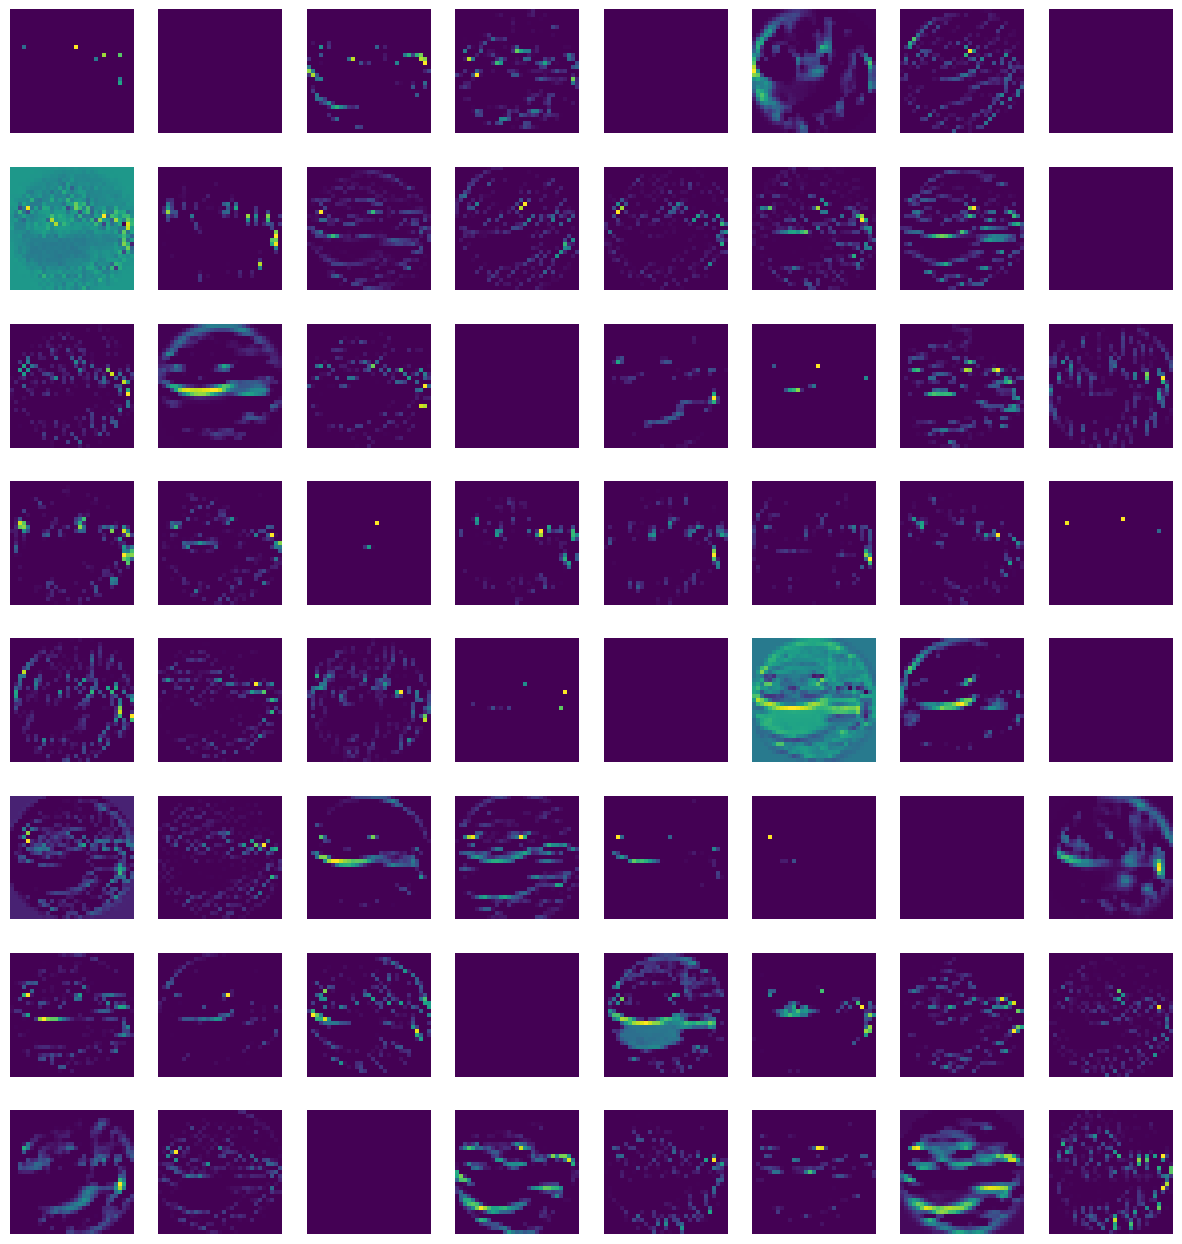

In [ ]:
import matplotlib.pyplot as plt

# Assuming intermediate_outputs is the dictionary you obtained
feature_maps = intermediate_outputs['features_0'][6]  # 7th sample, first layer
n_maps = feature_maps.shape[0]  # Number of feature maps

# Plotting
fig, axes = plt.subplots(int(n_maps / 8), 8, figsize=(15, int(n_maps / 4)))
for i, ax in enumerate(axes.flat):
    if i < n_maps:
        ax.imshow(feature_maps[i].detach().cpu(), cmap='viridis')
        ax.axis('off')
plt.show()


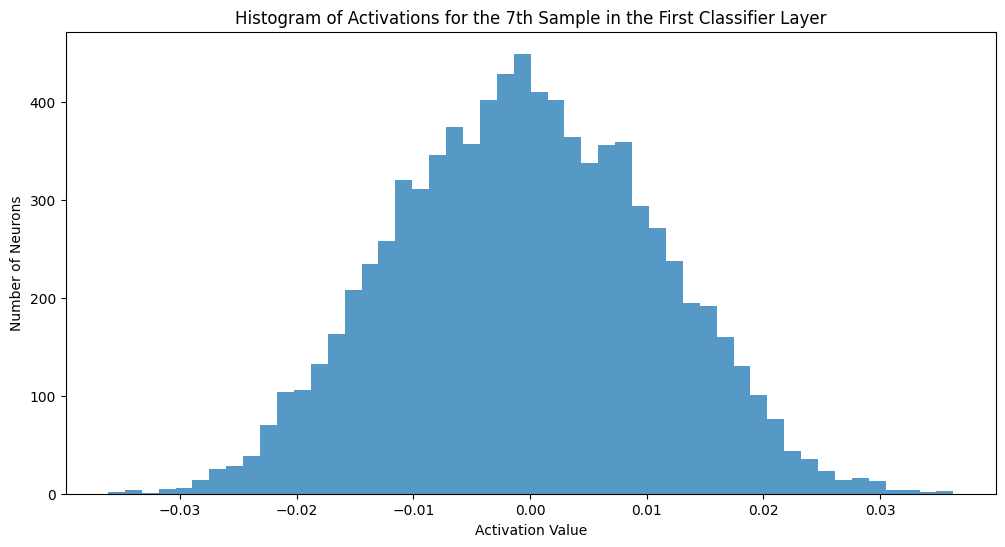

In [ ]:
import matplotlib.pyplot as plt

# Get the activations for the 7th sample
activations = intermediate_outputs['classifier_6'][6].detach().cpu().numpy()

# Create a histogram of the activation values
plt.figure(figsize=(12, 6))
plt.hist(activations, bins=50, alpha=0.75)
plt.title('Histogram of Activations for the 7th Sample in the First Classifier Layer')
plt.xlabel('Activation Value')
plt.ylabel('Number of Neurons')
plt.show()


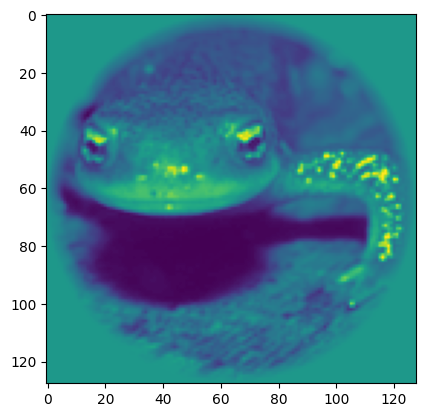

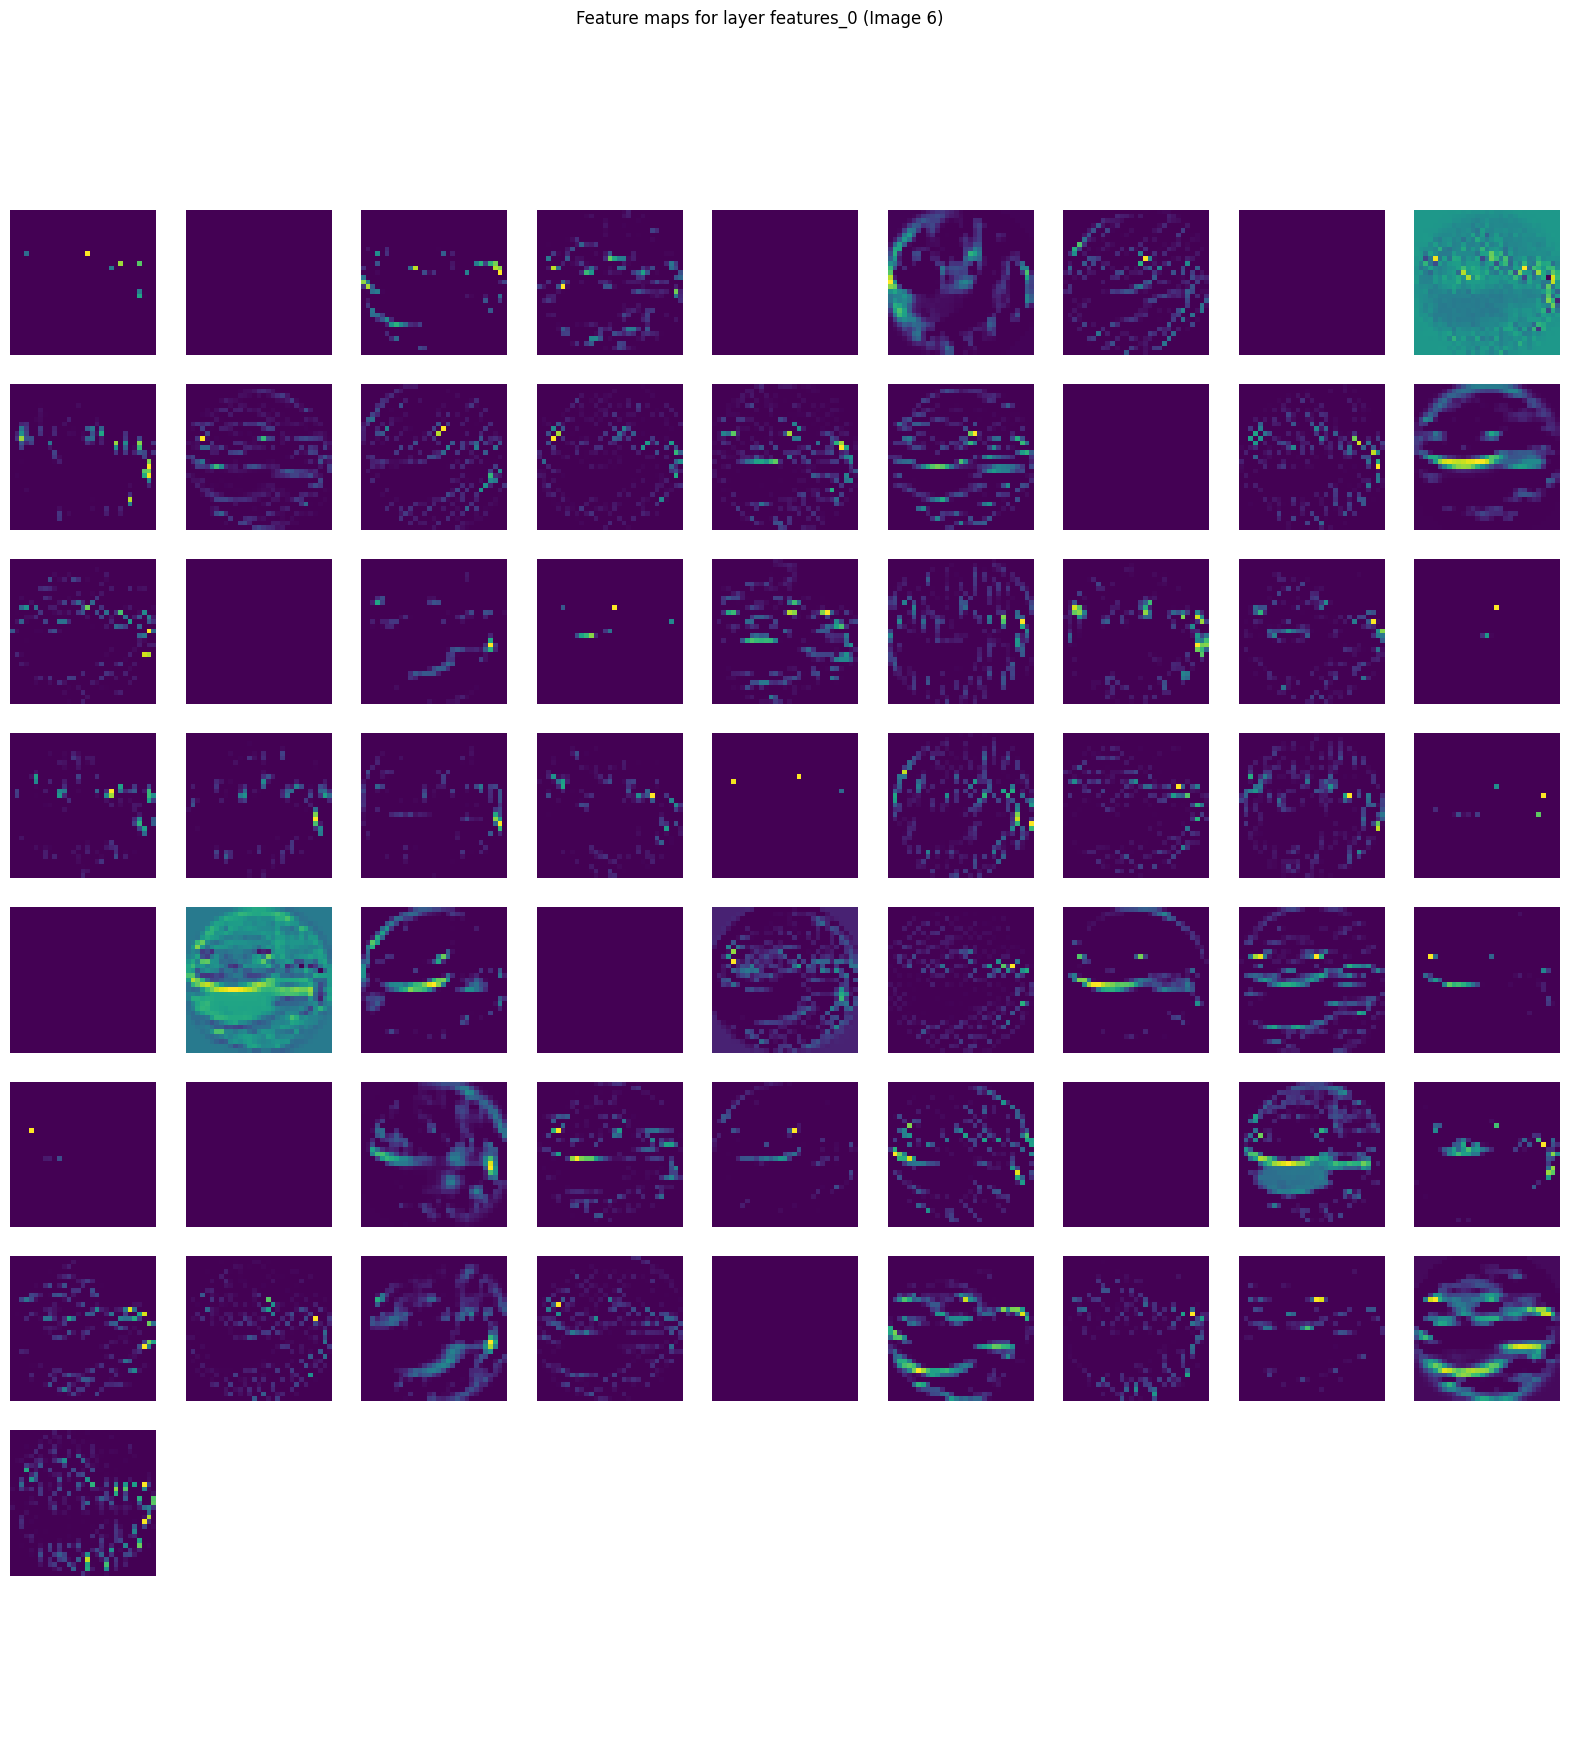

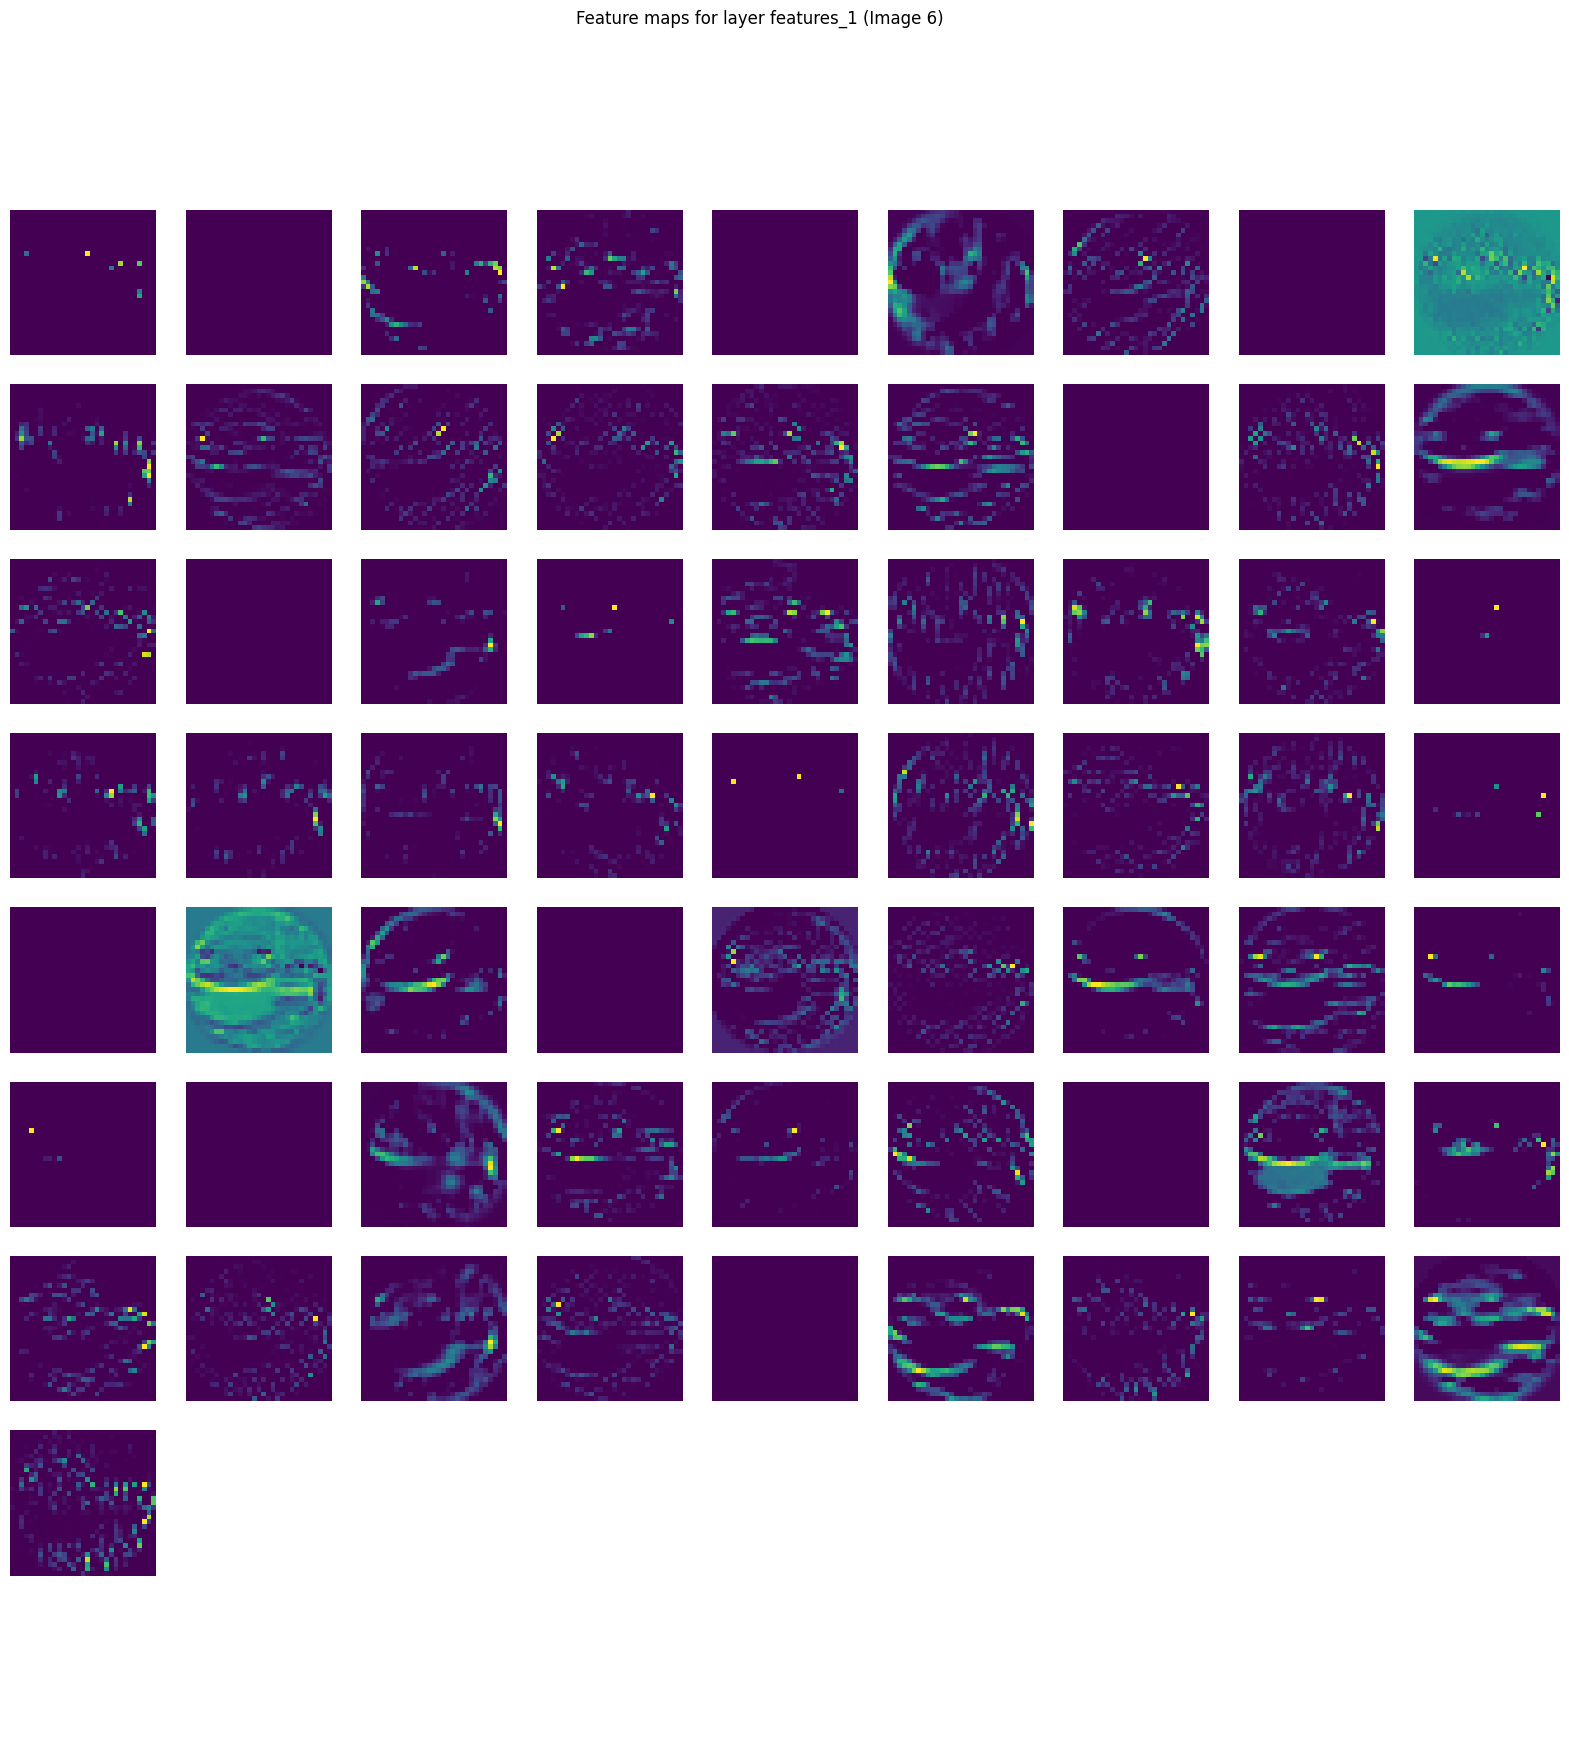

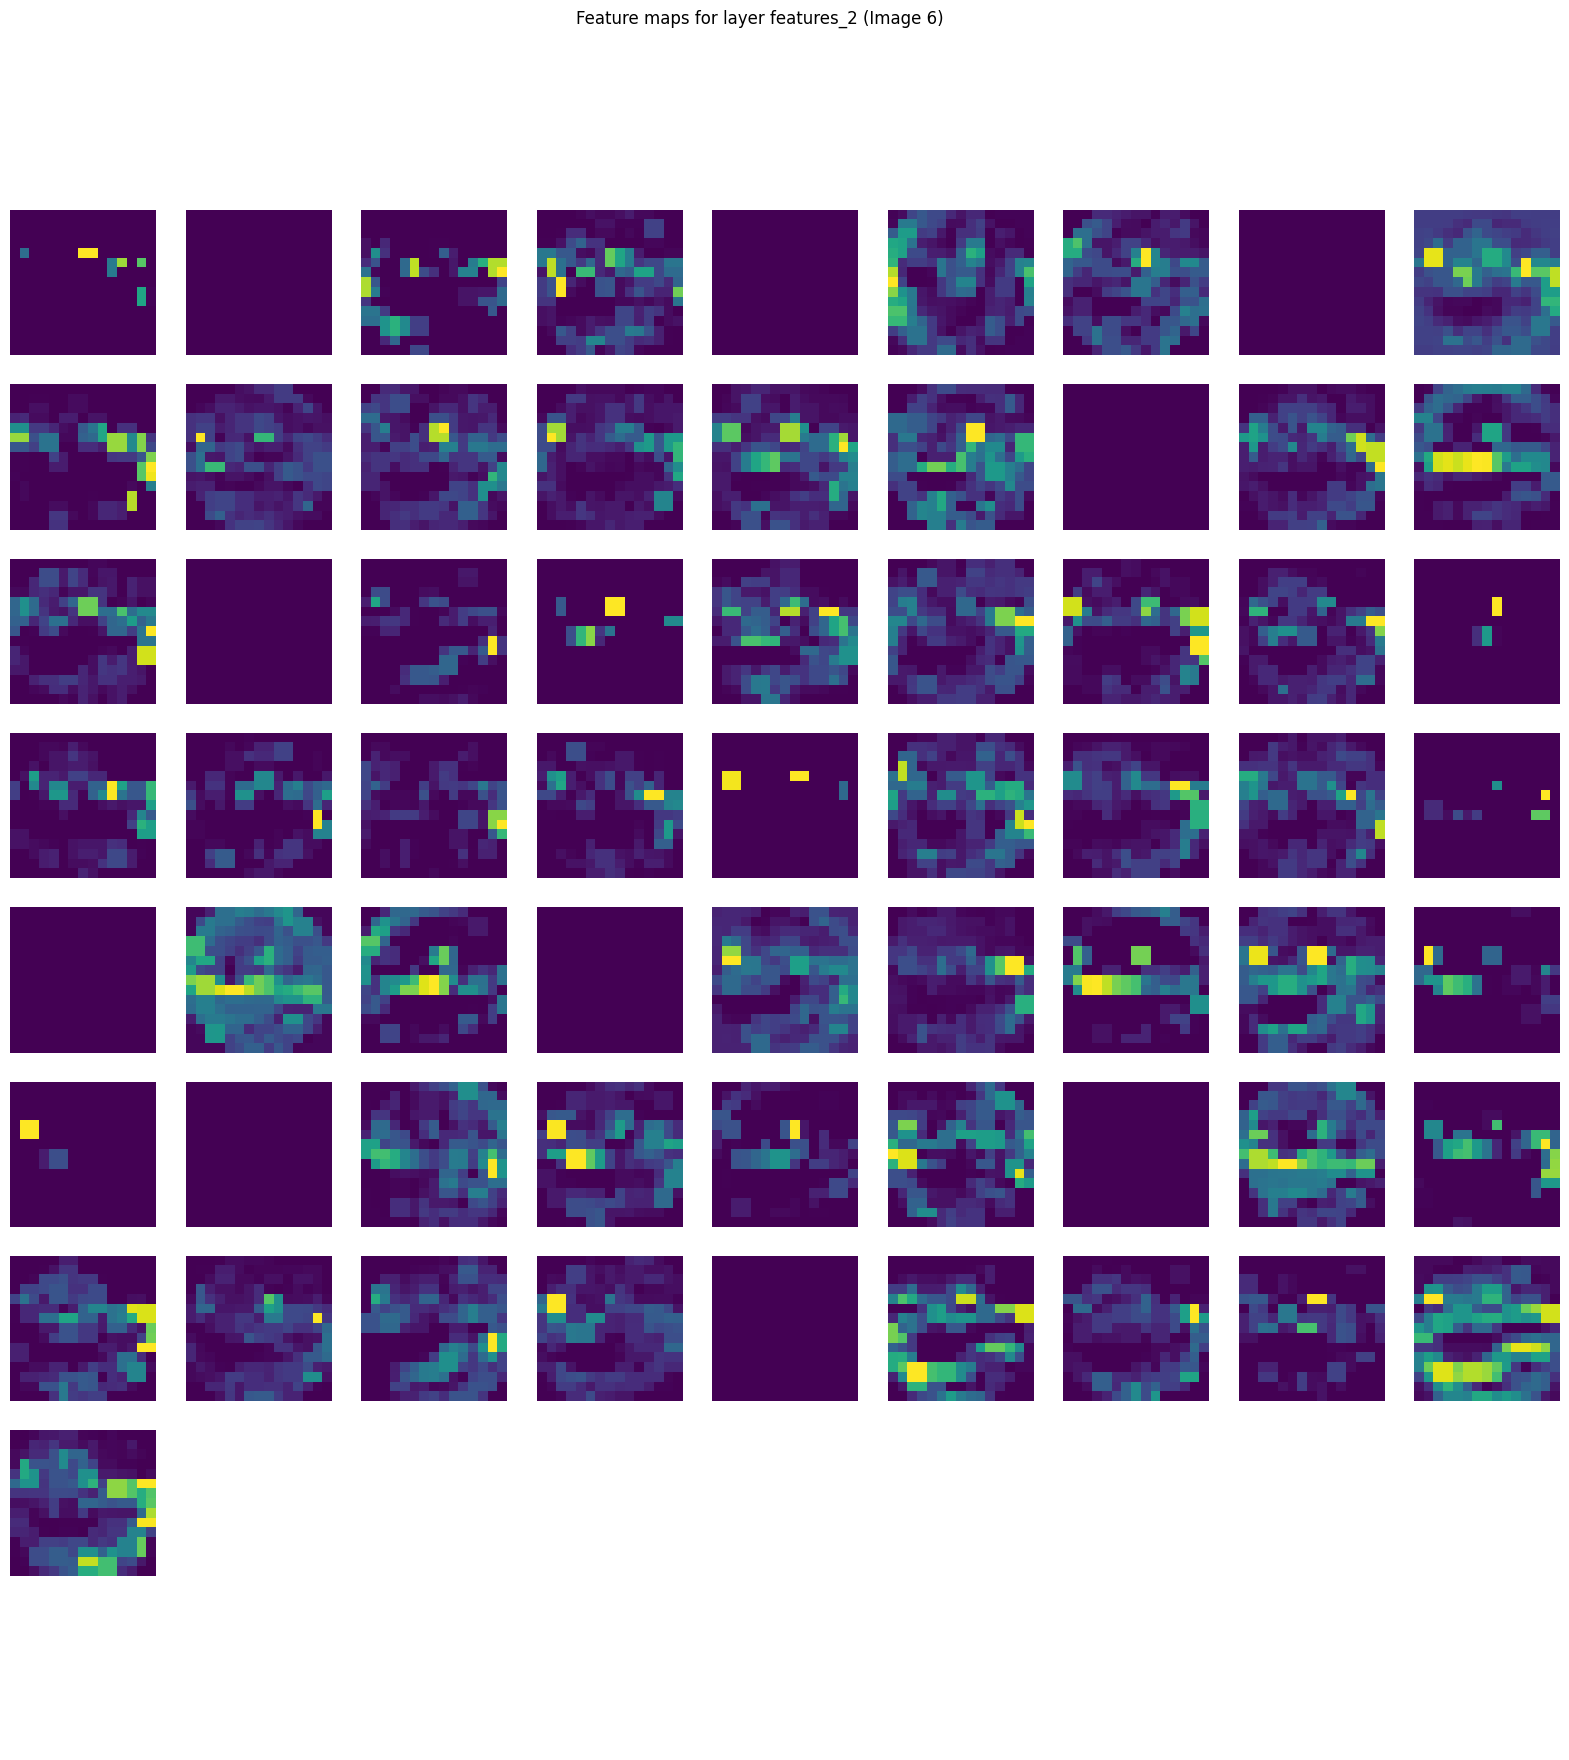

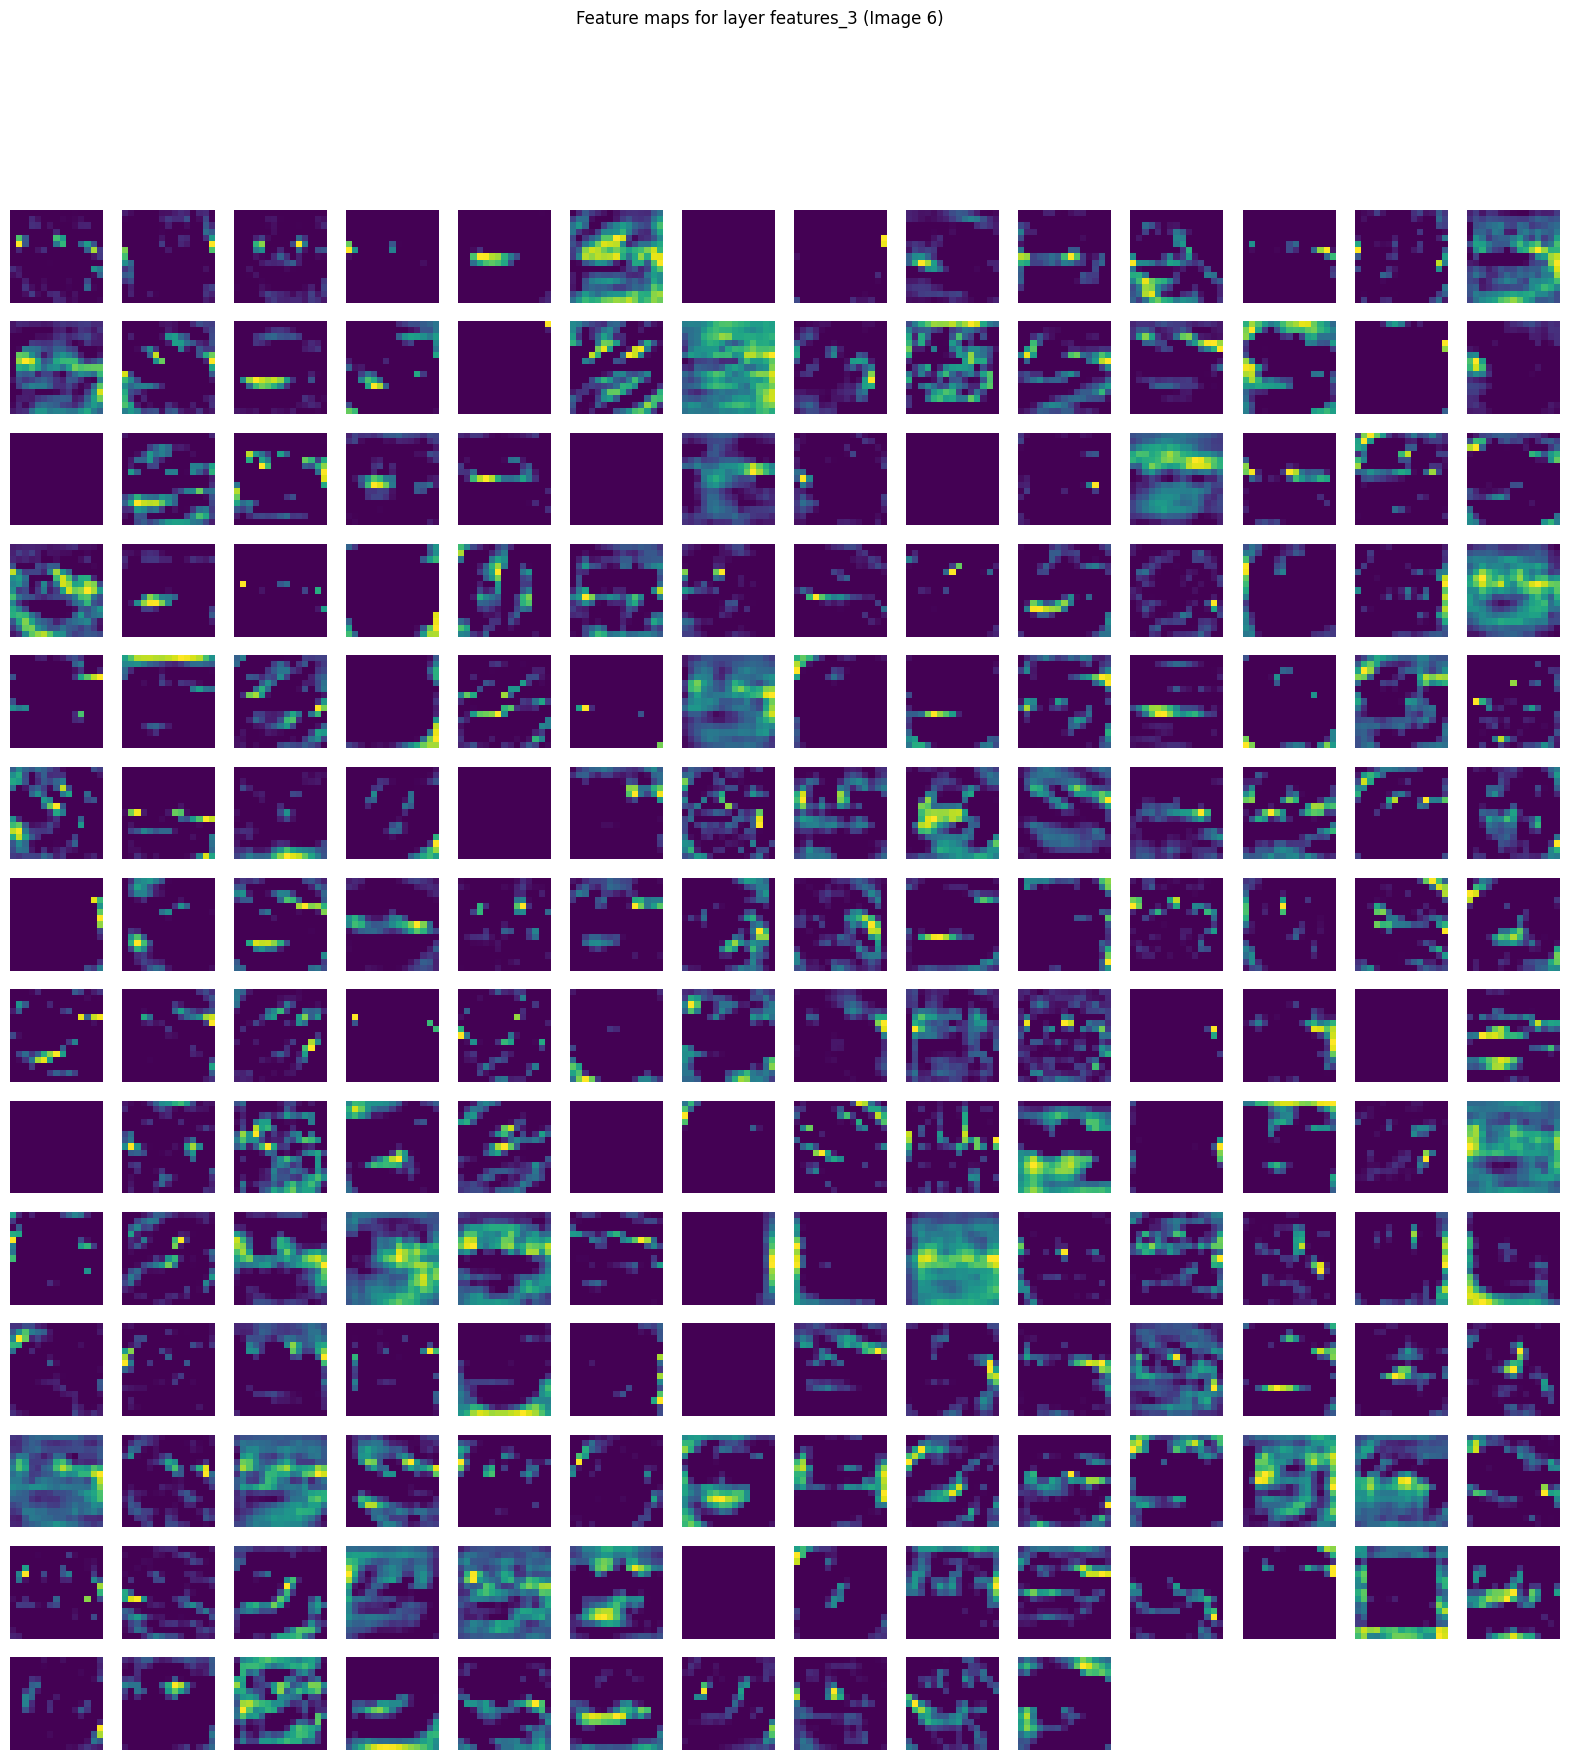

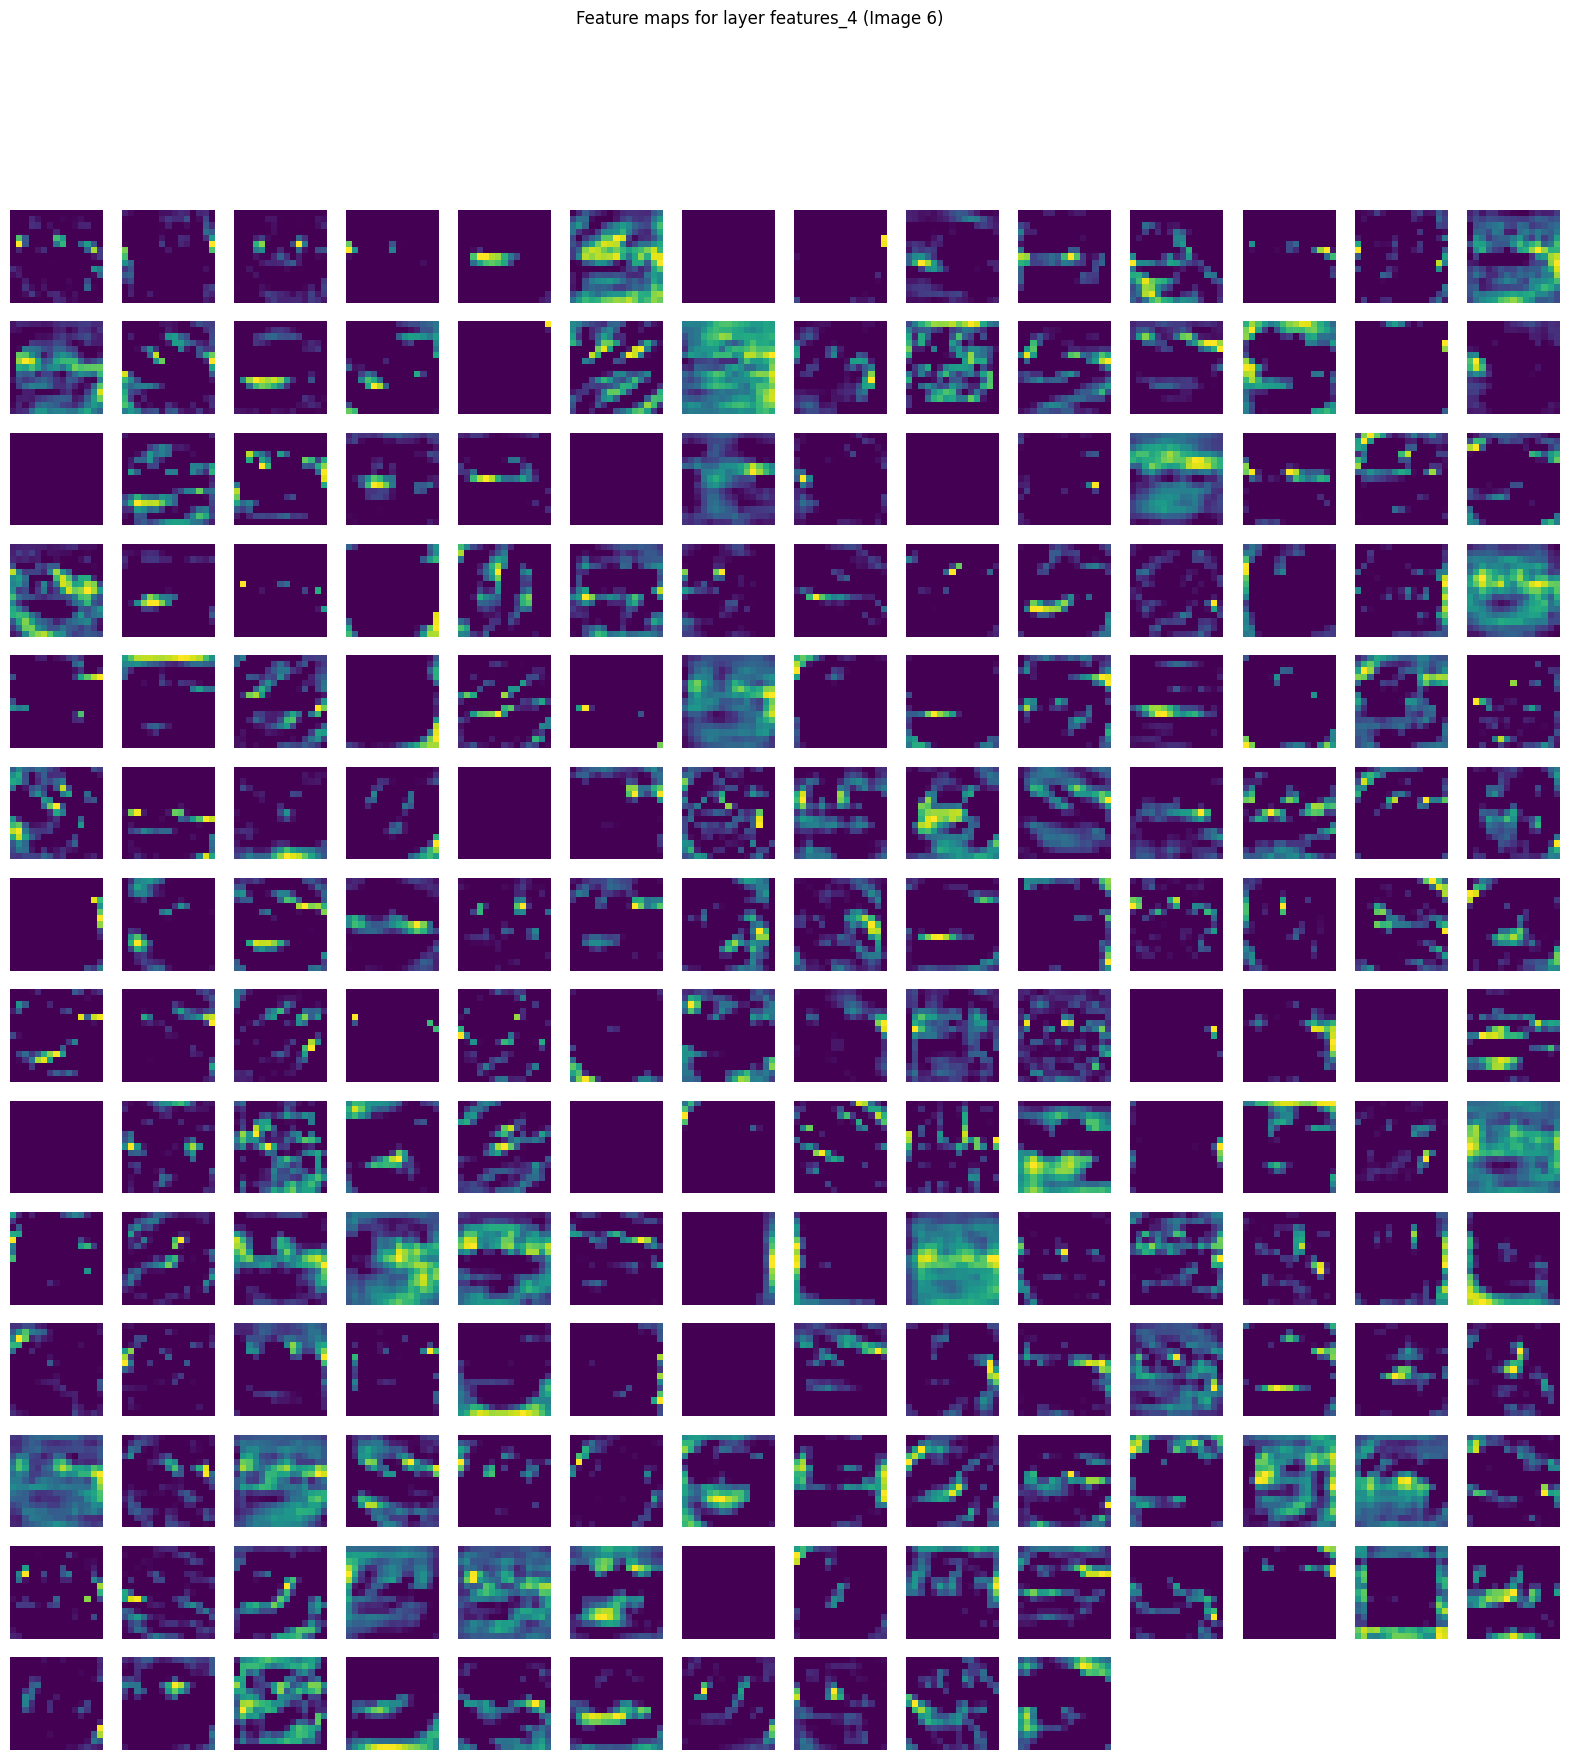

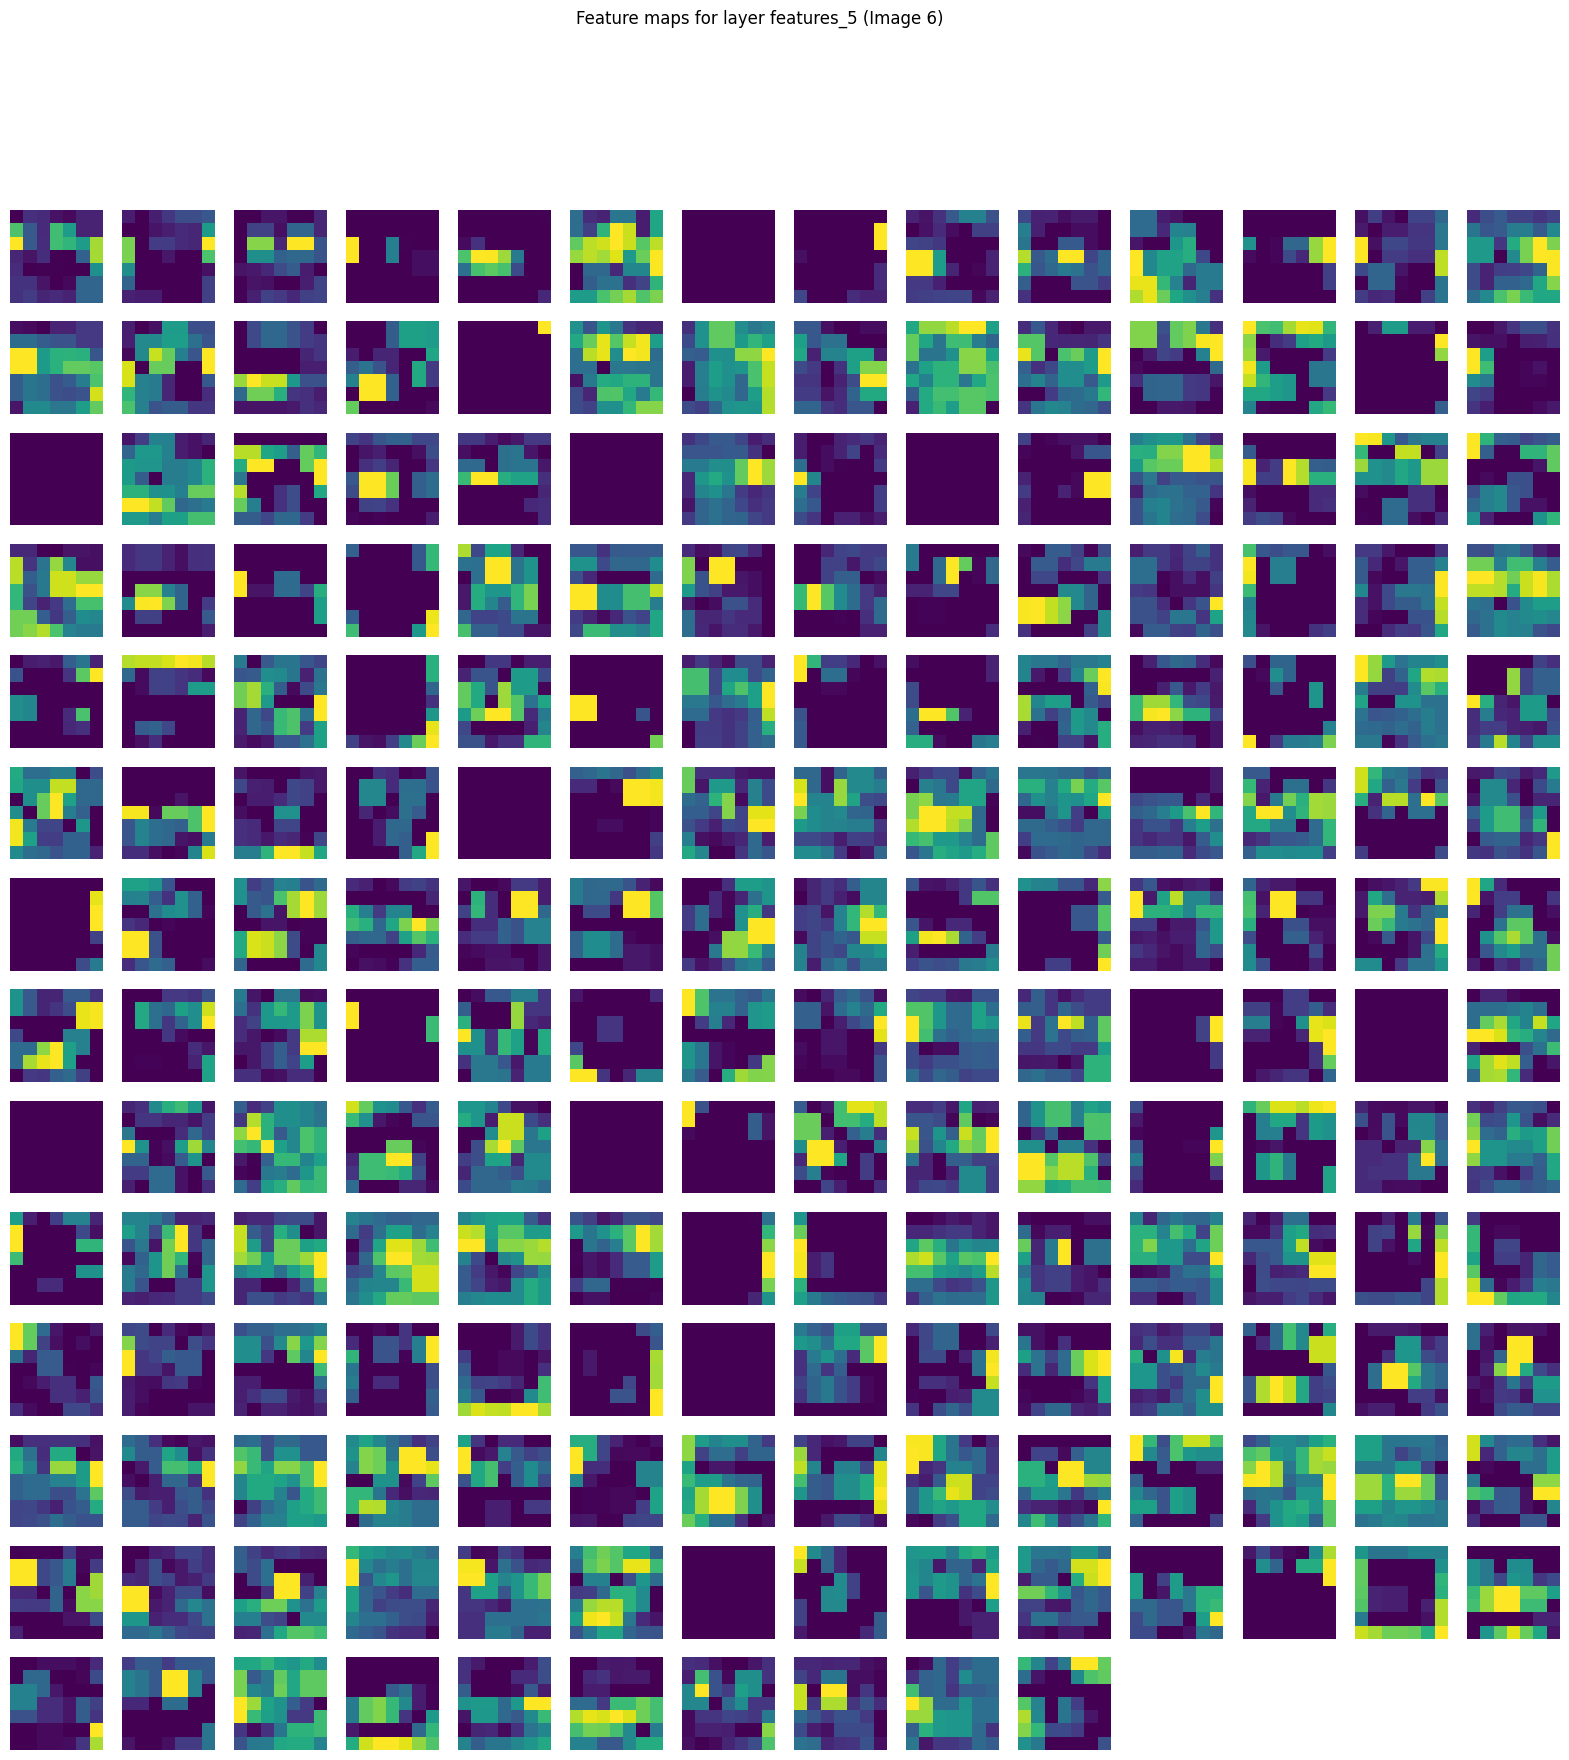

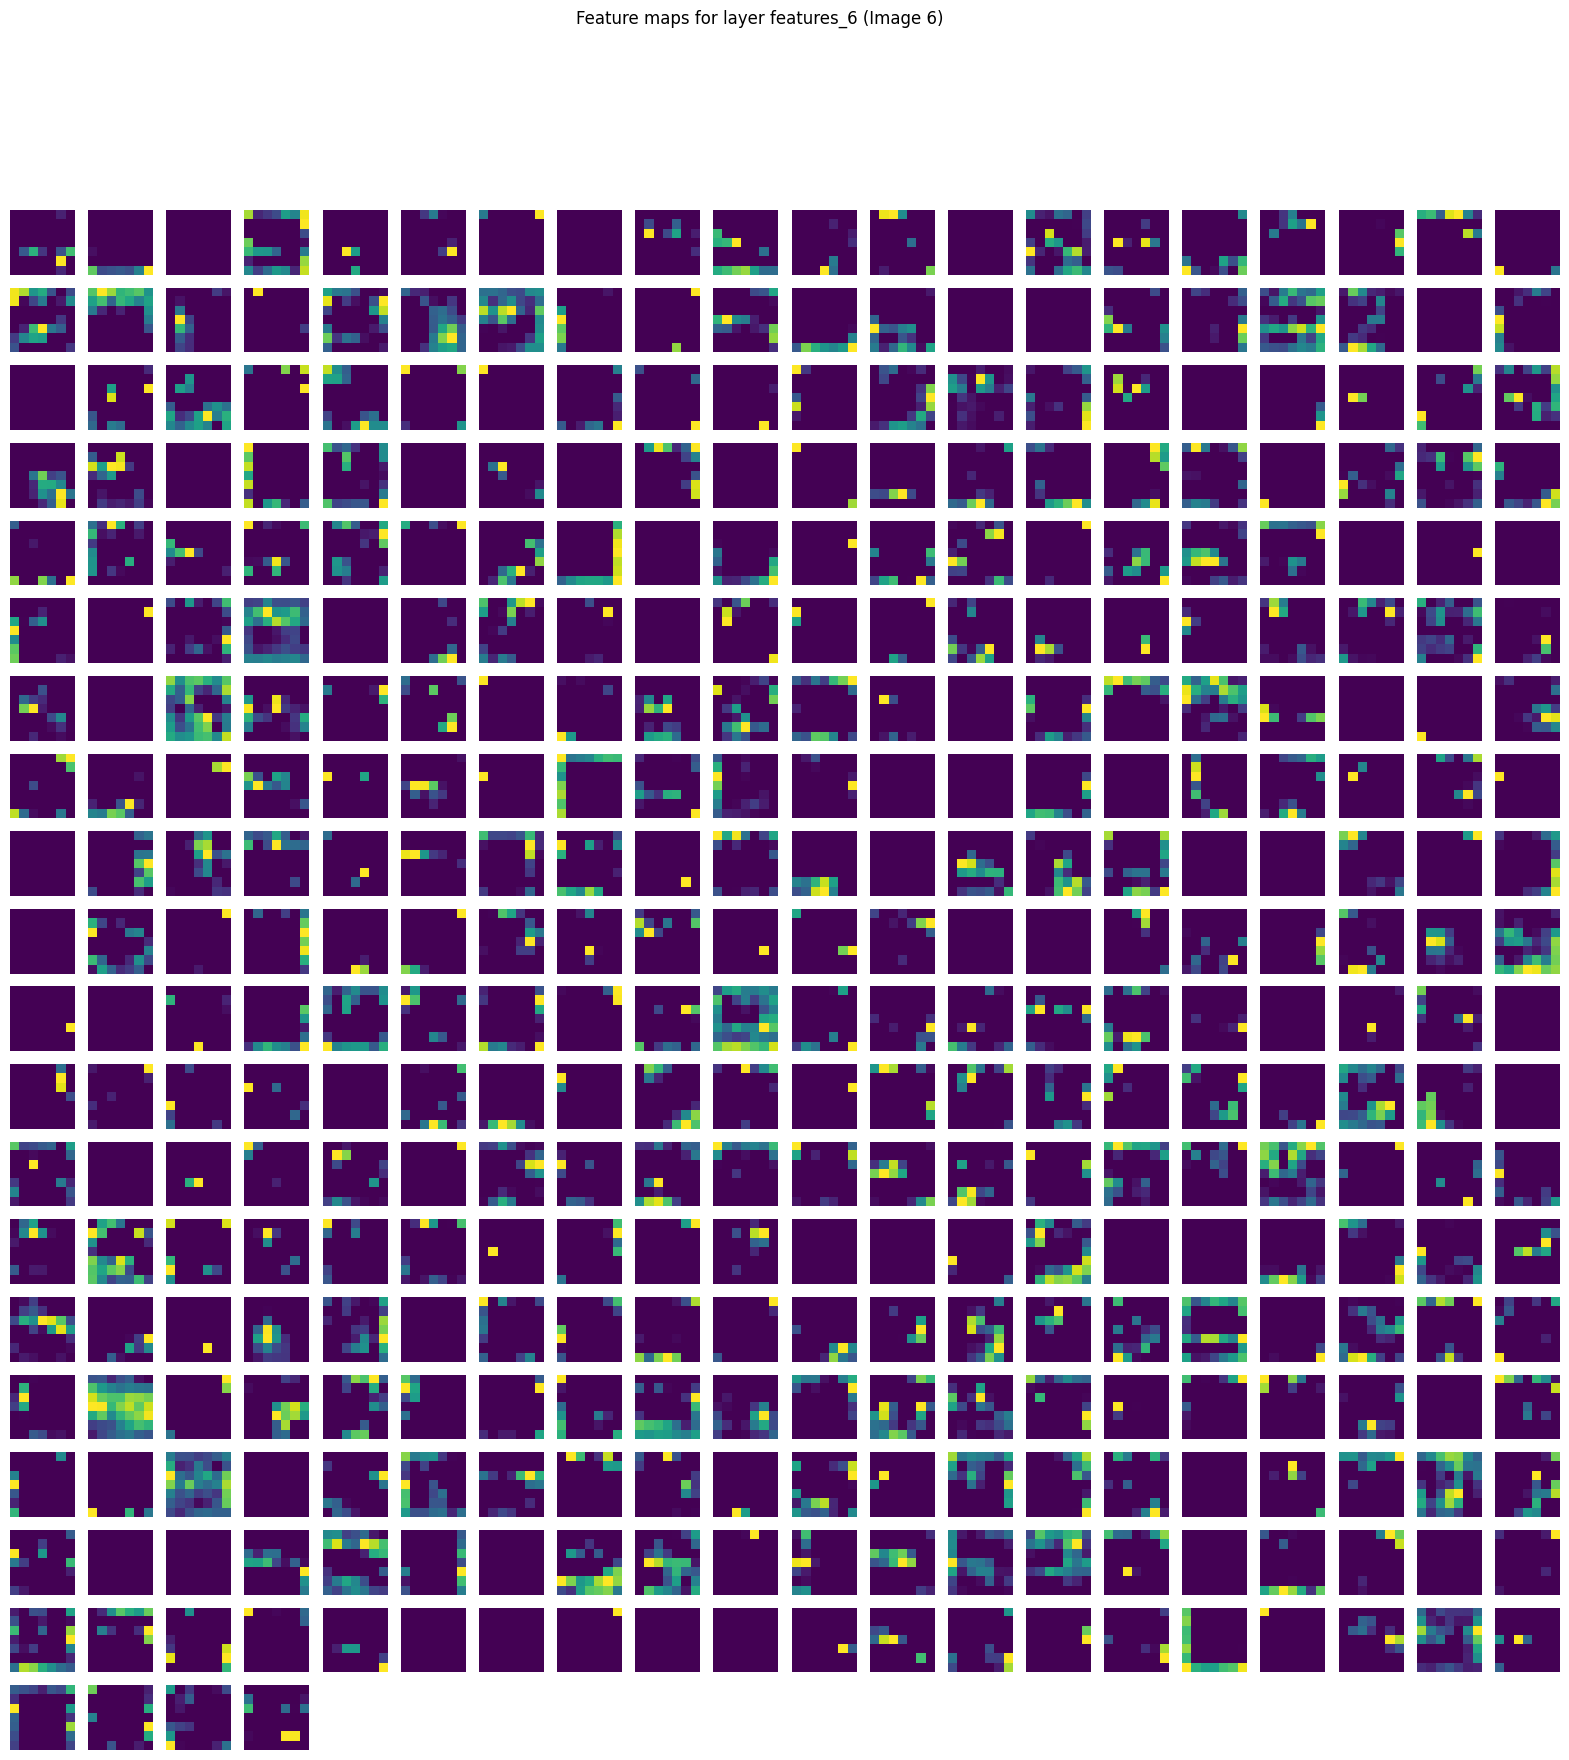

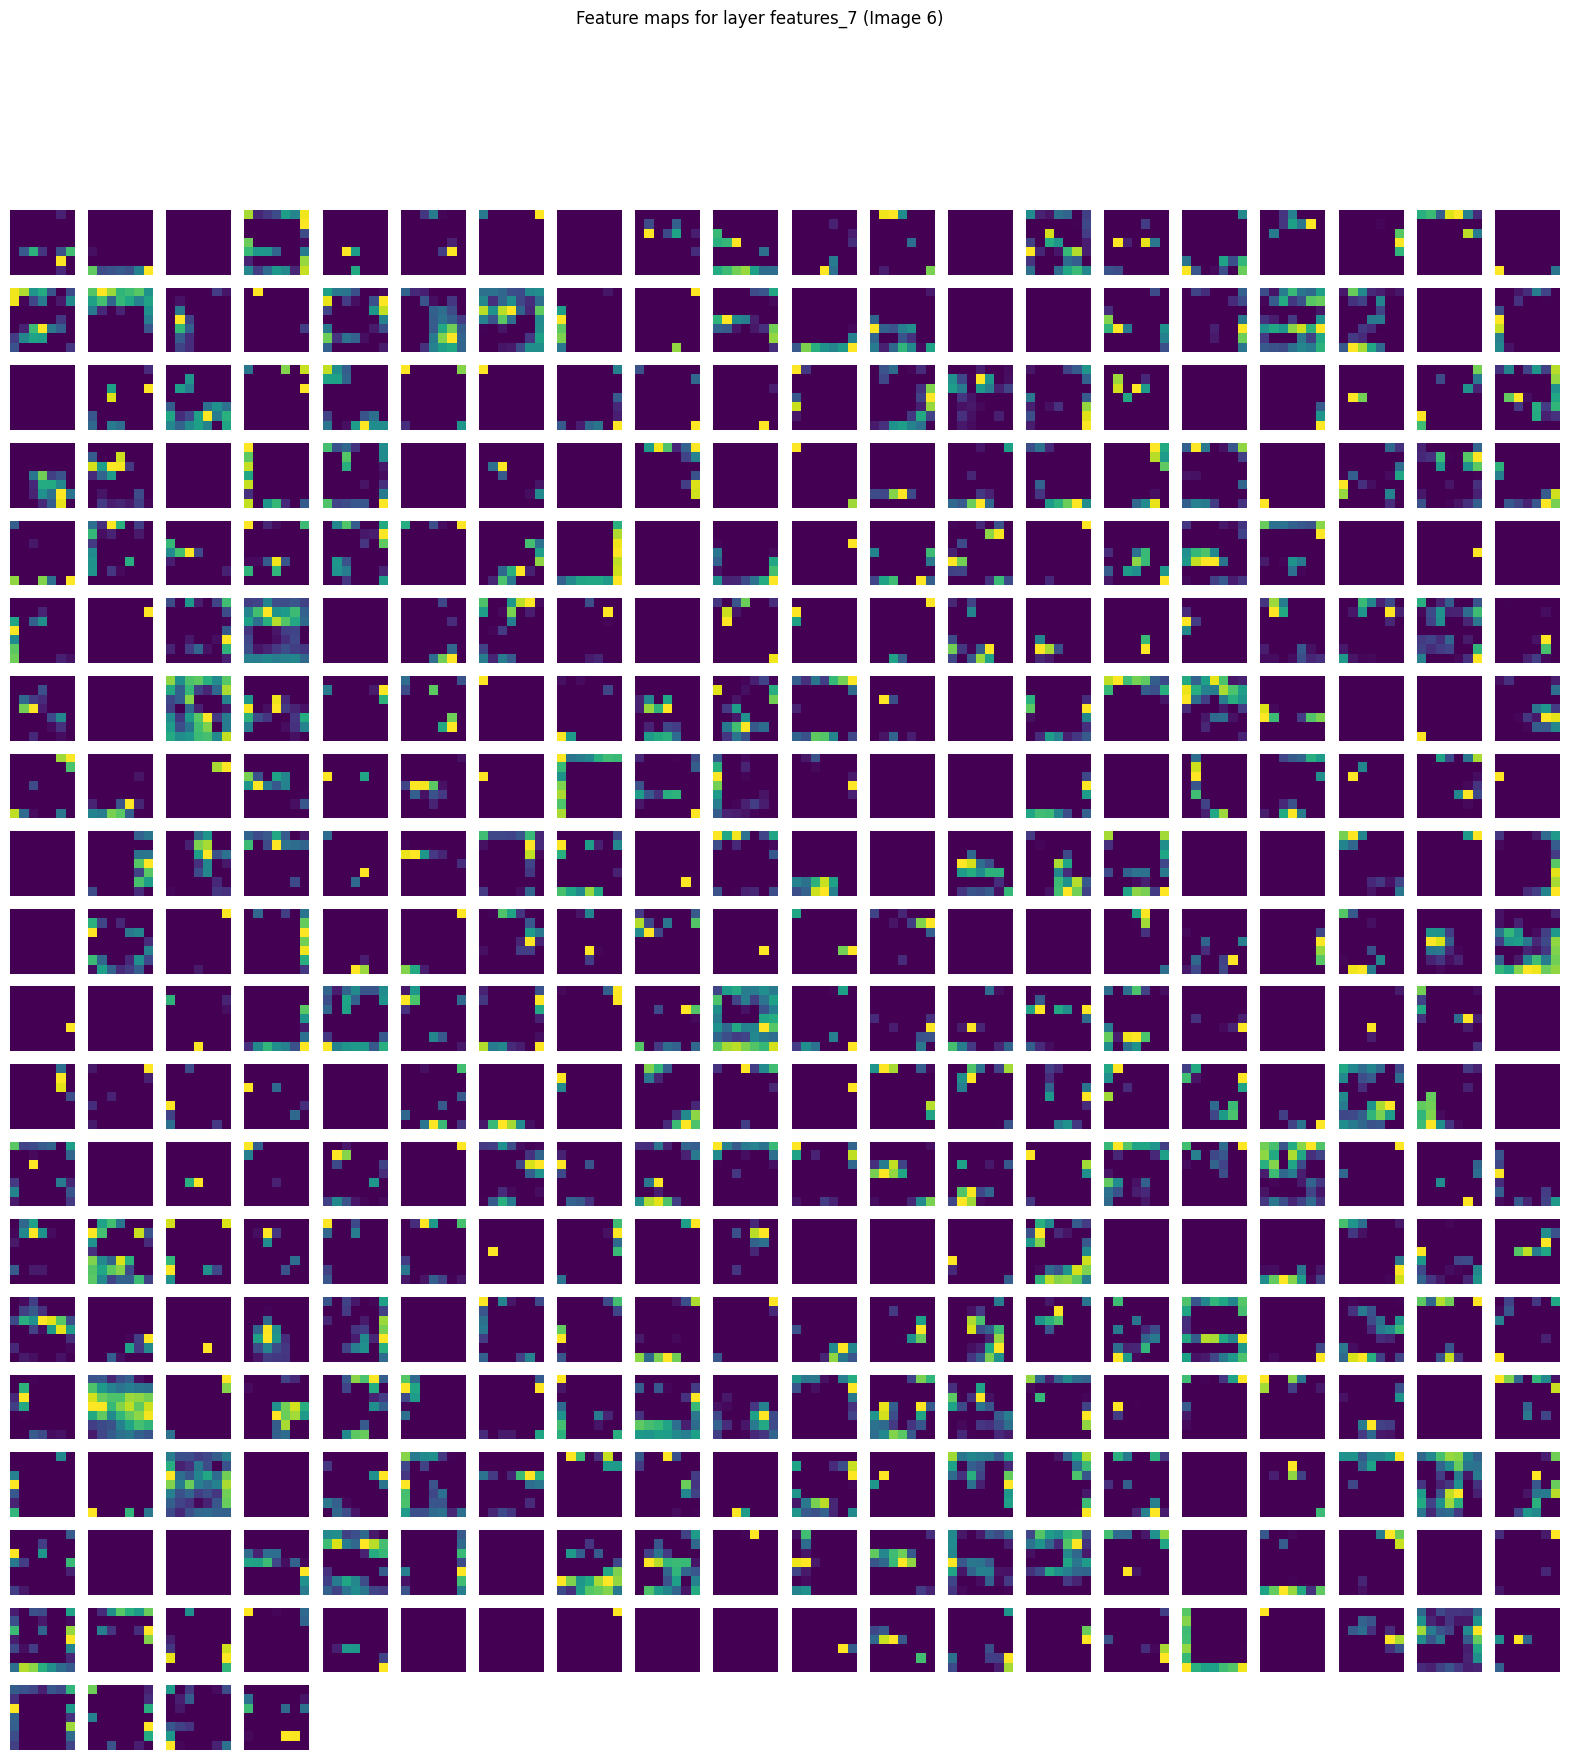

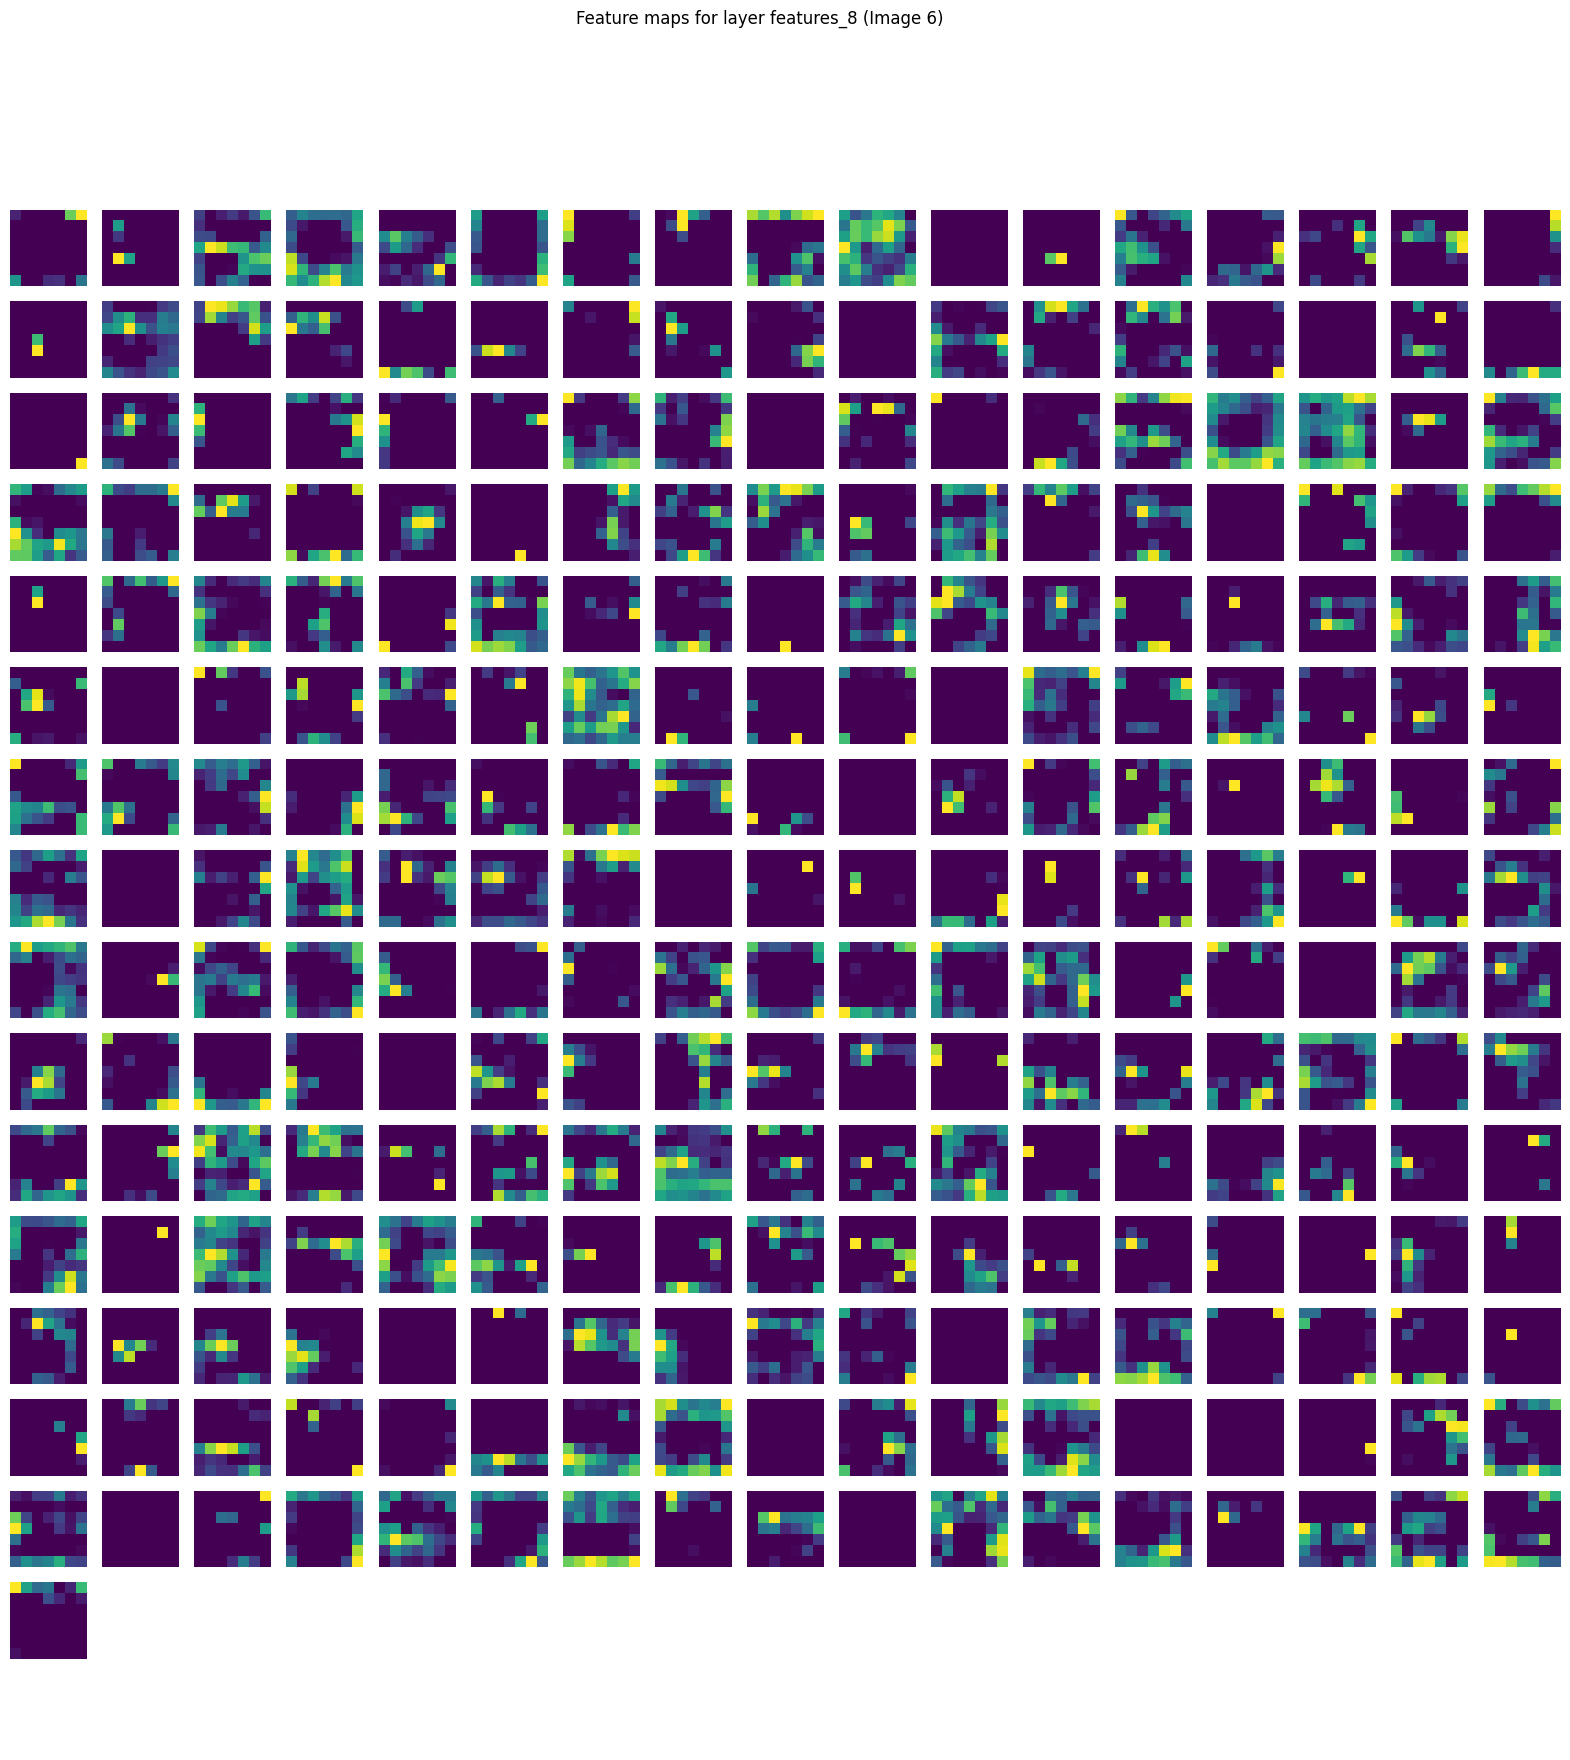

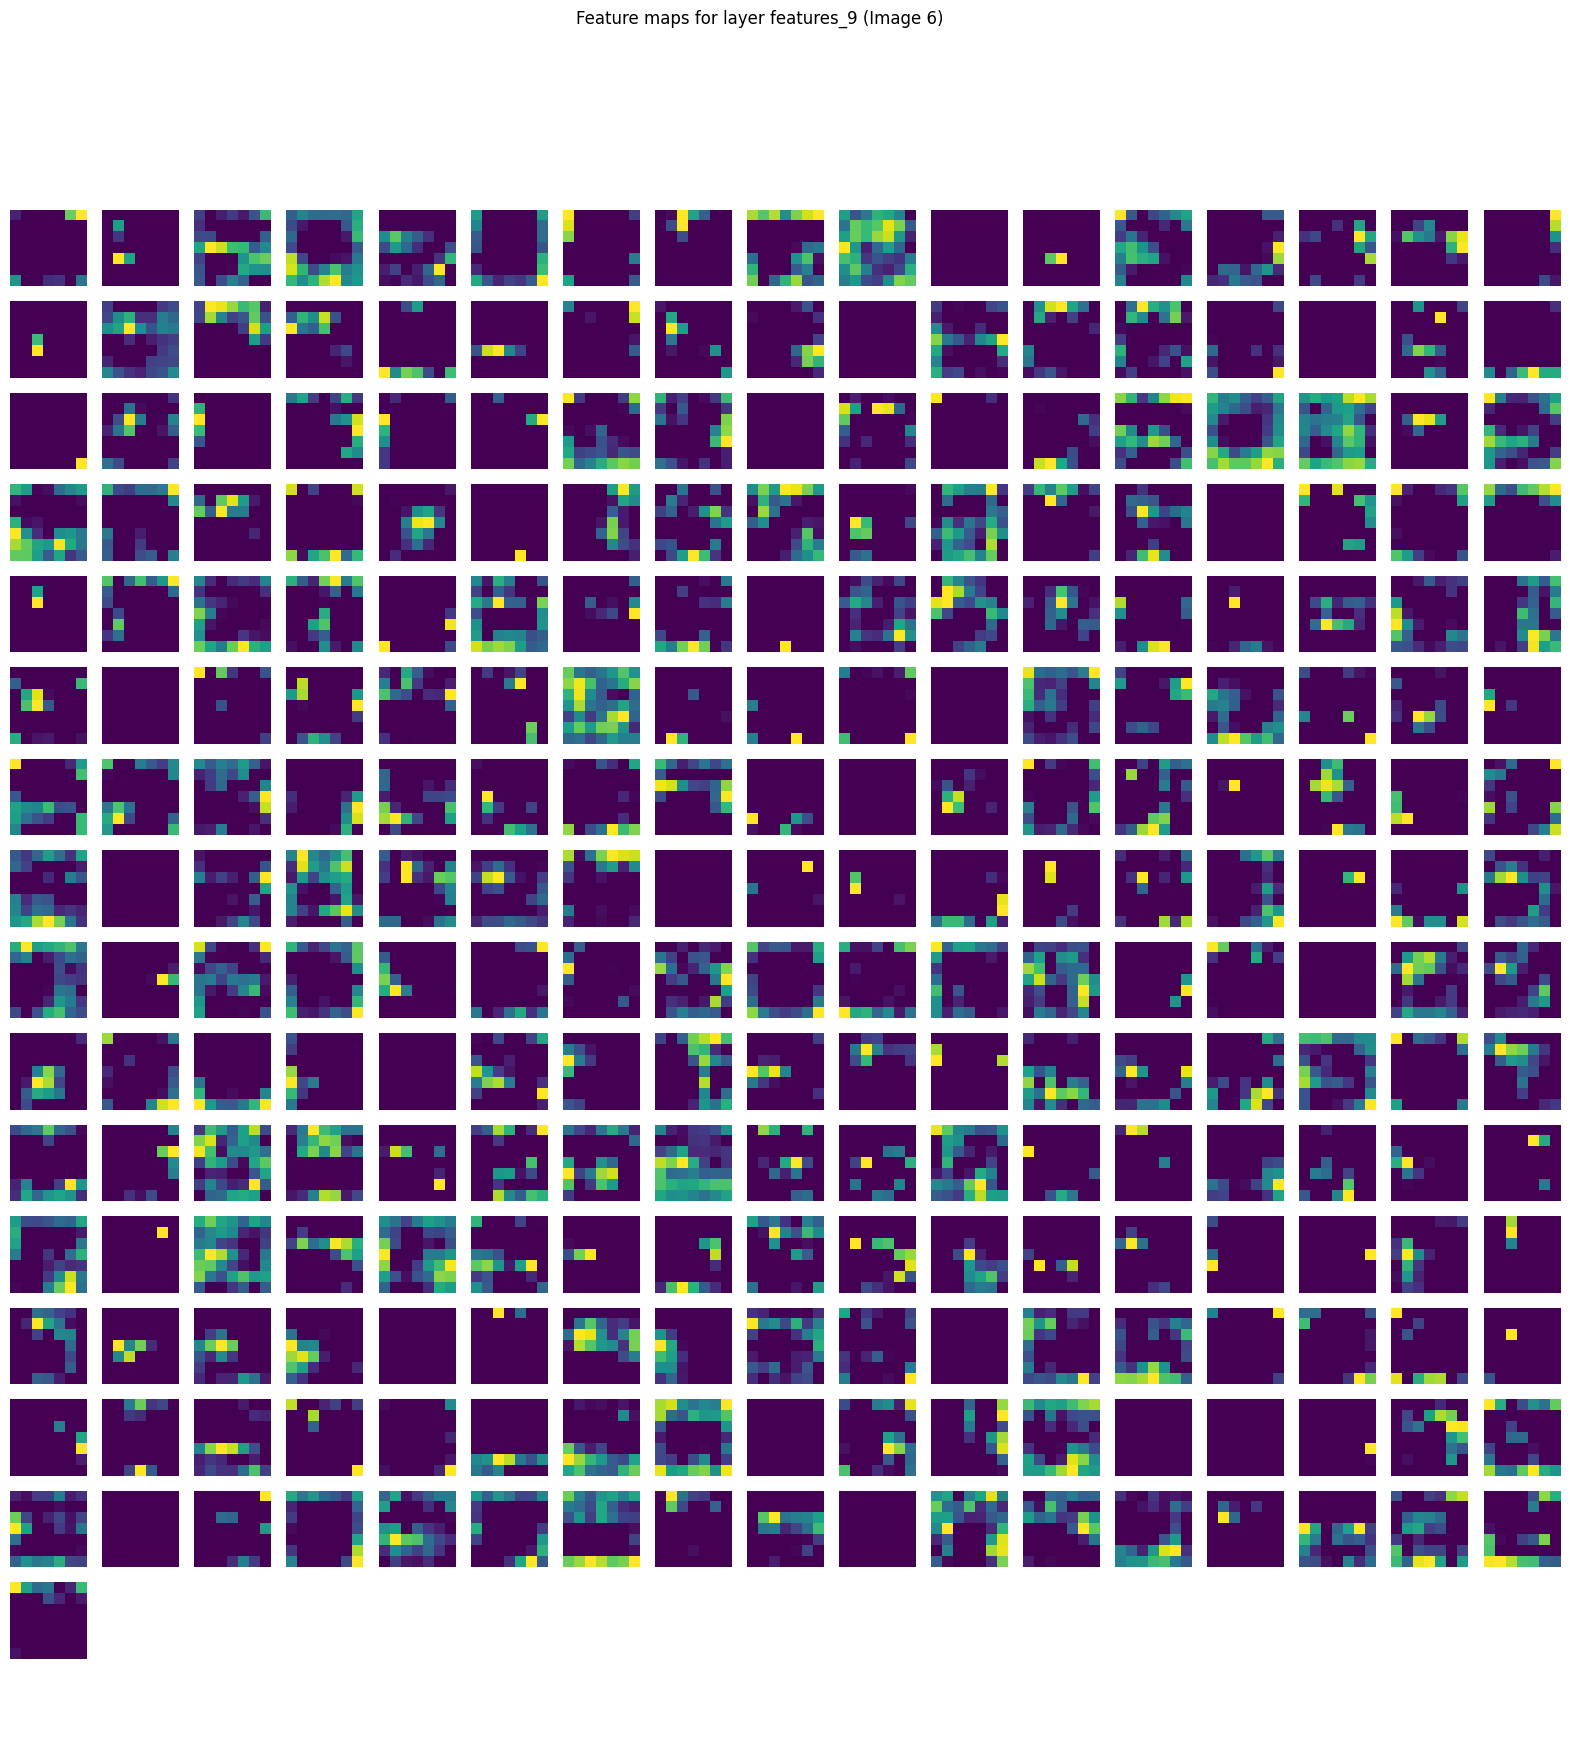

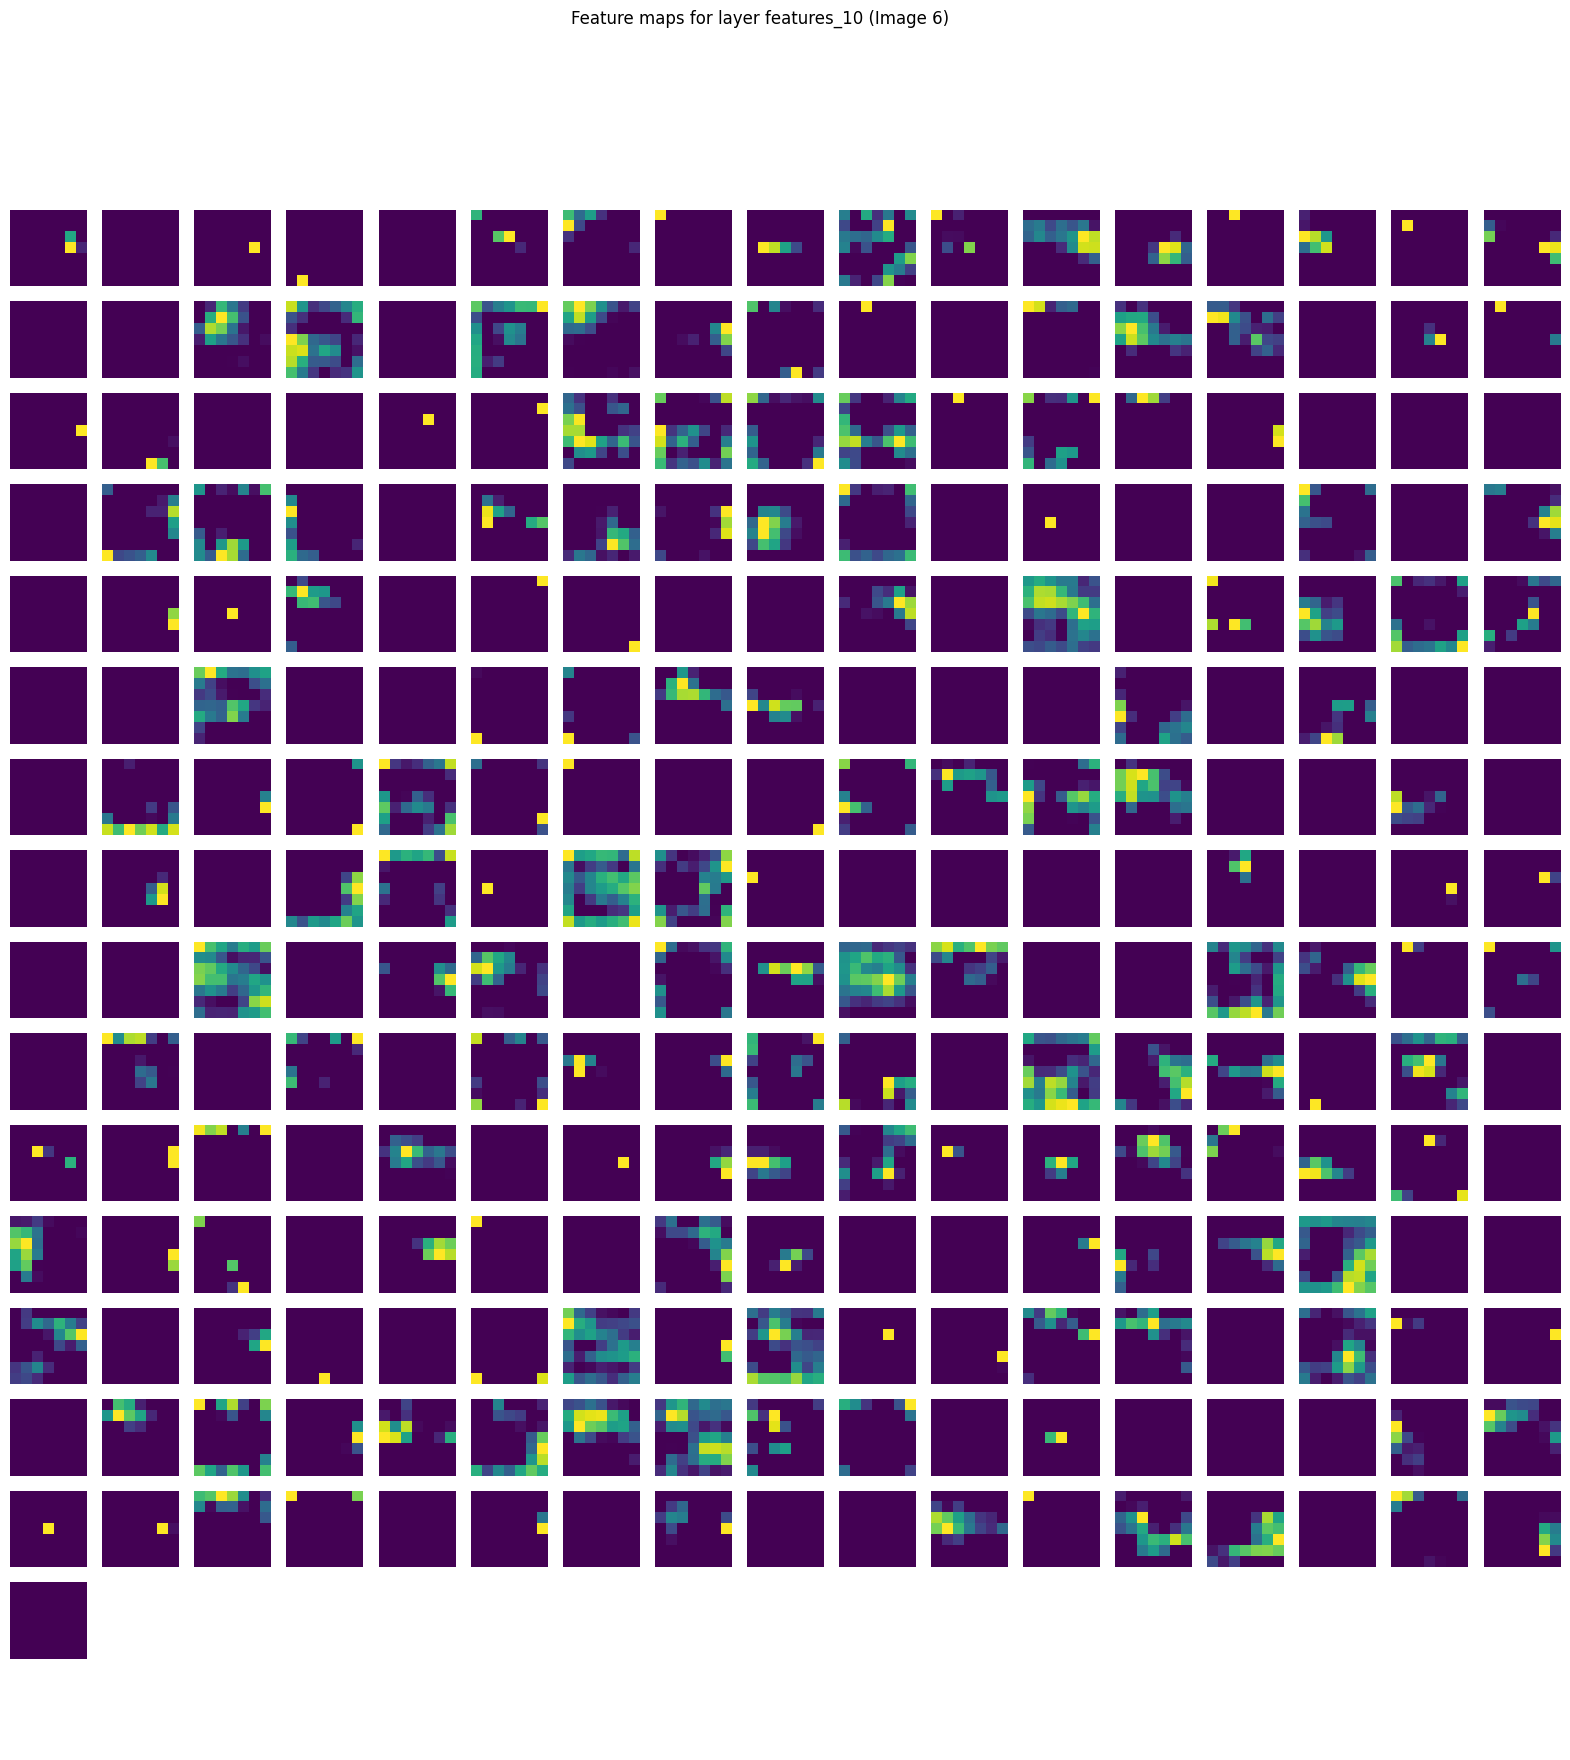

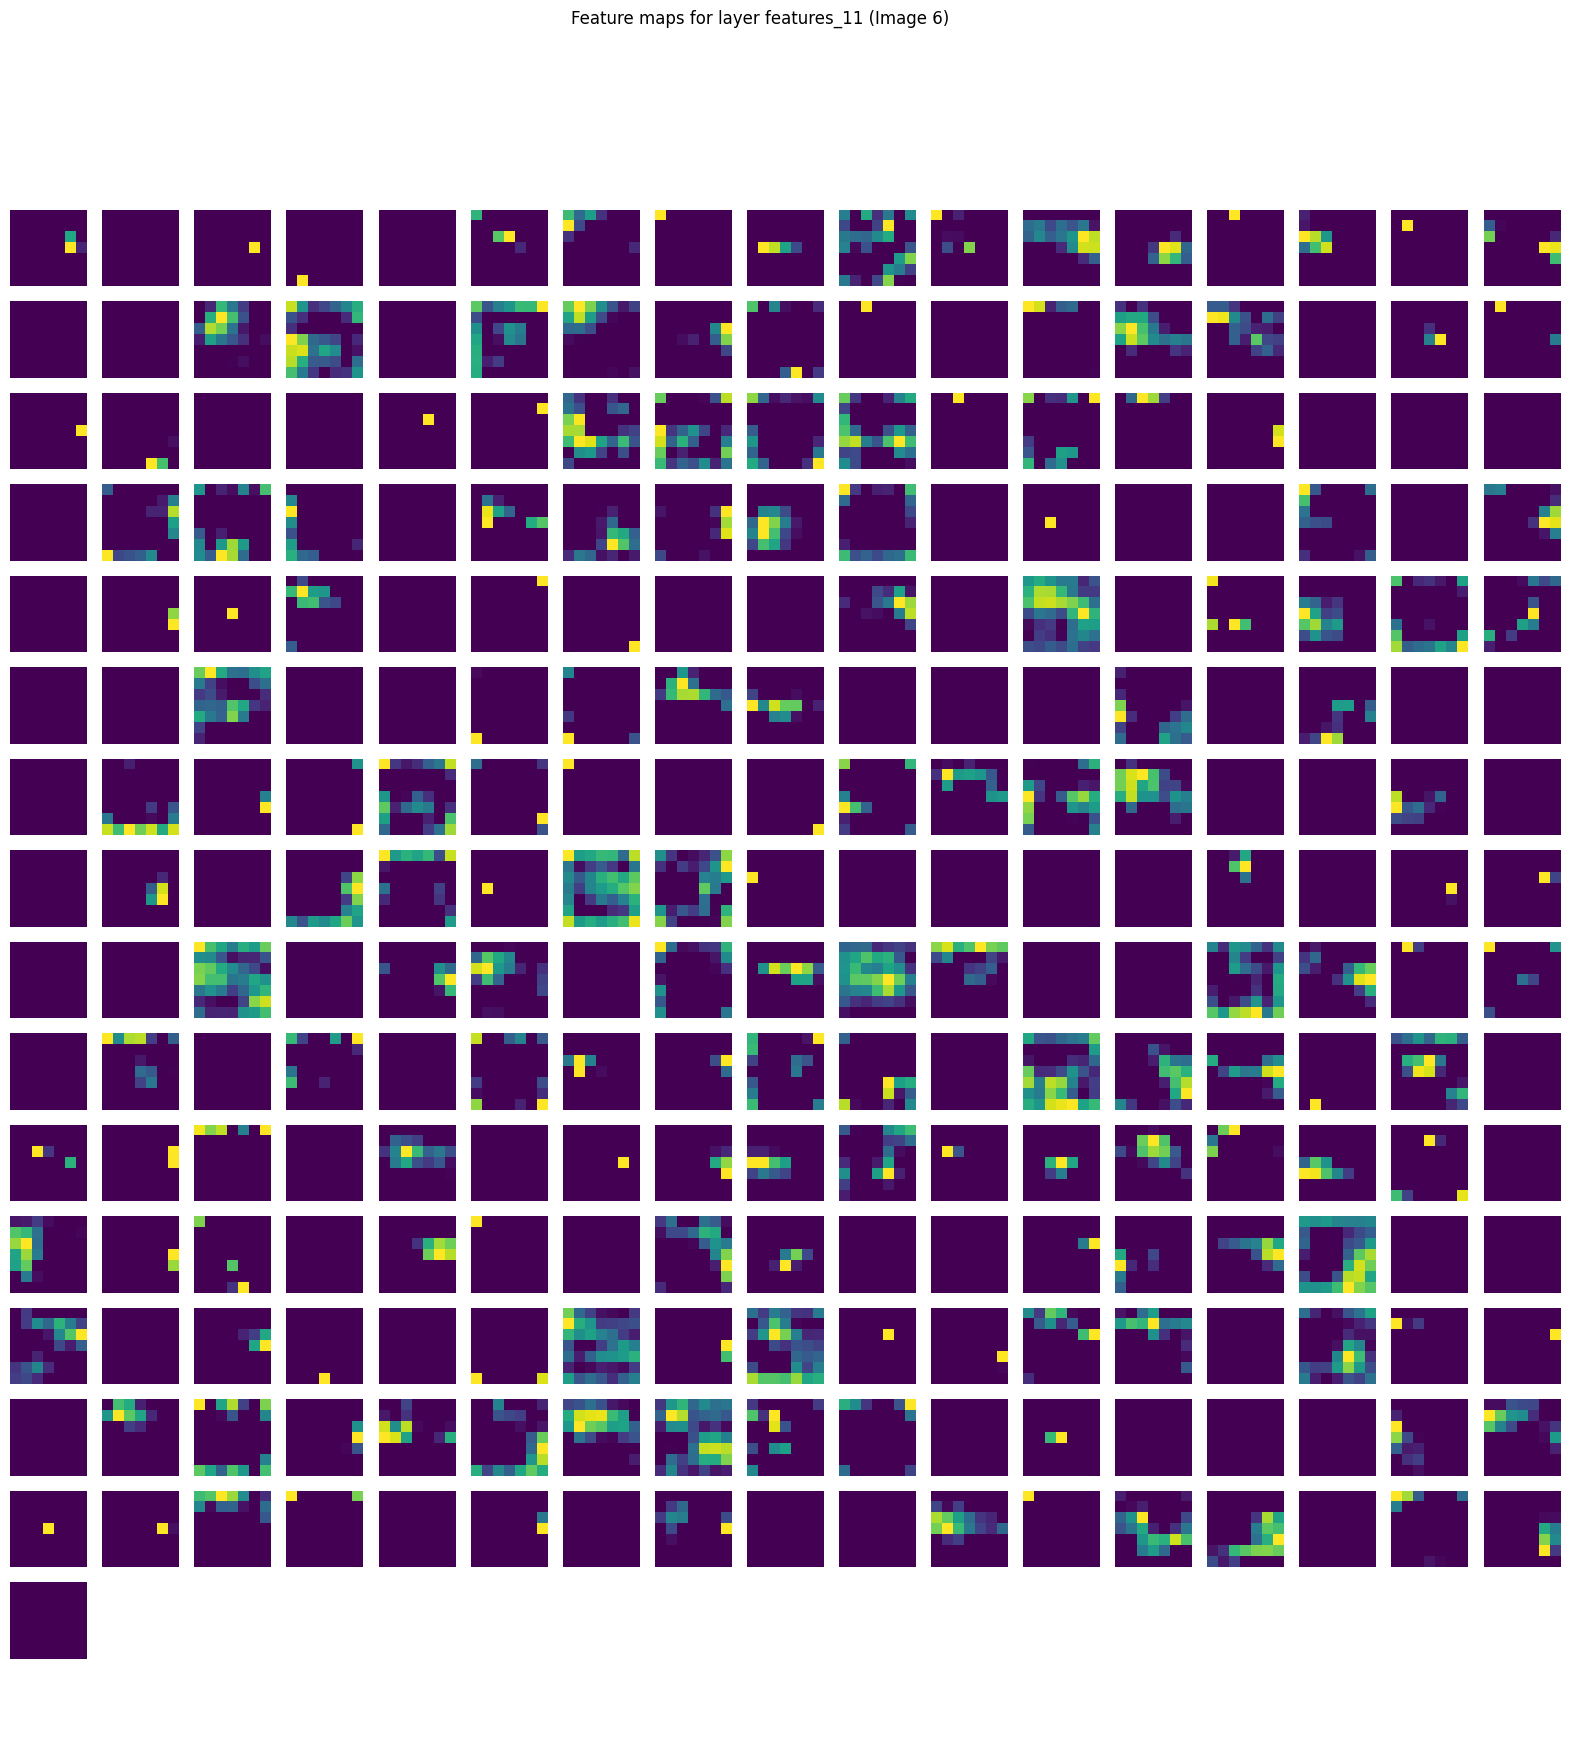

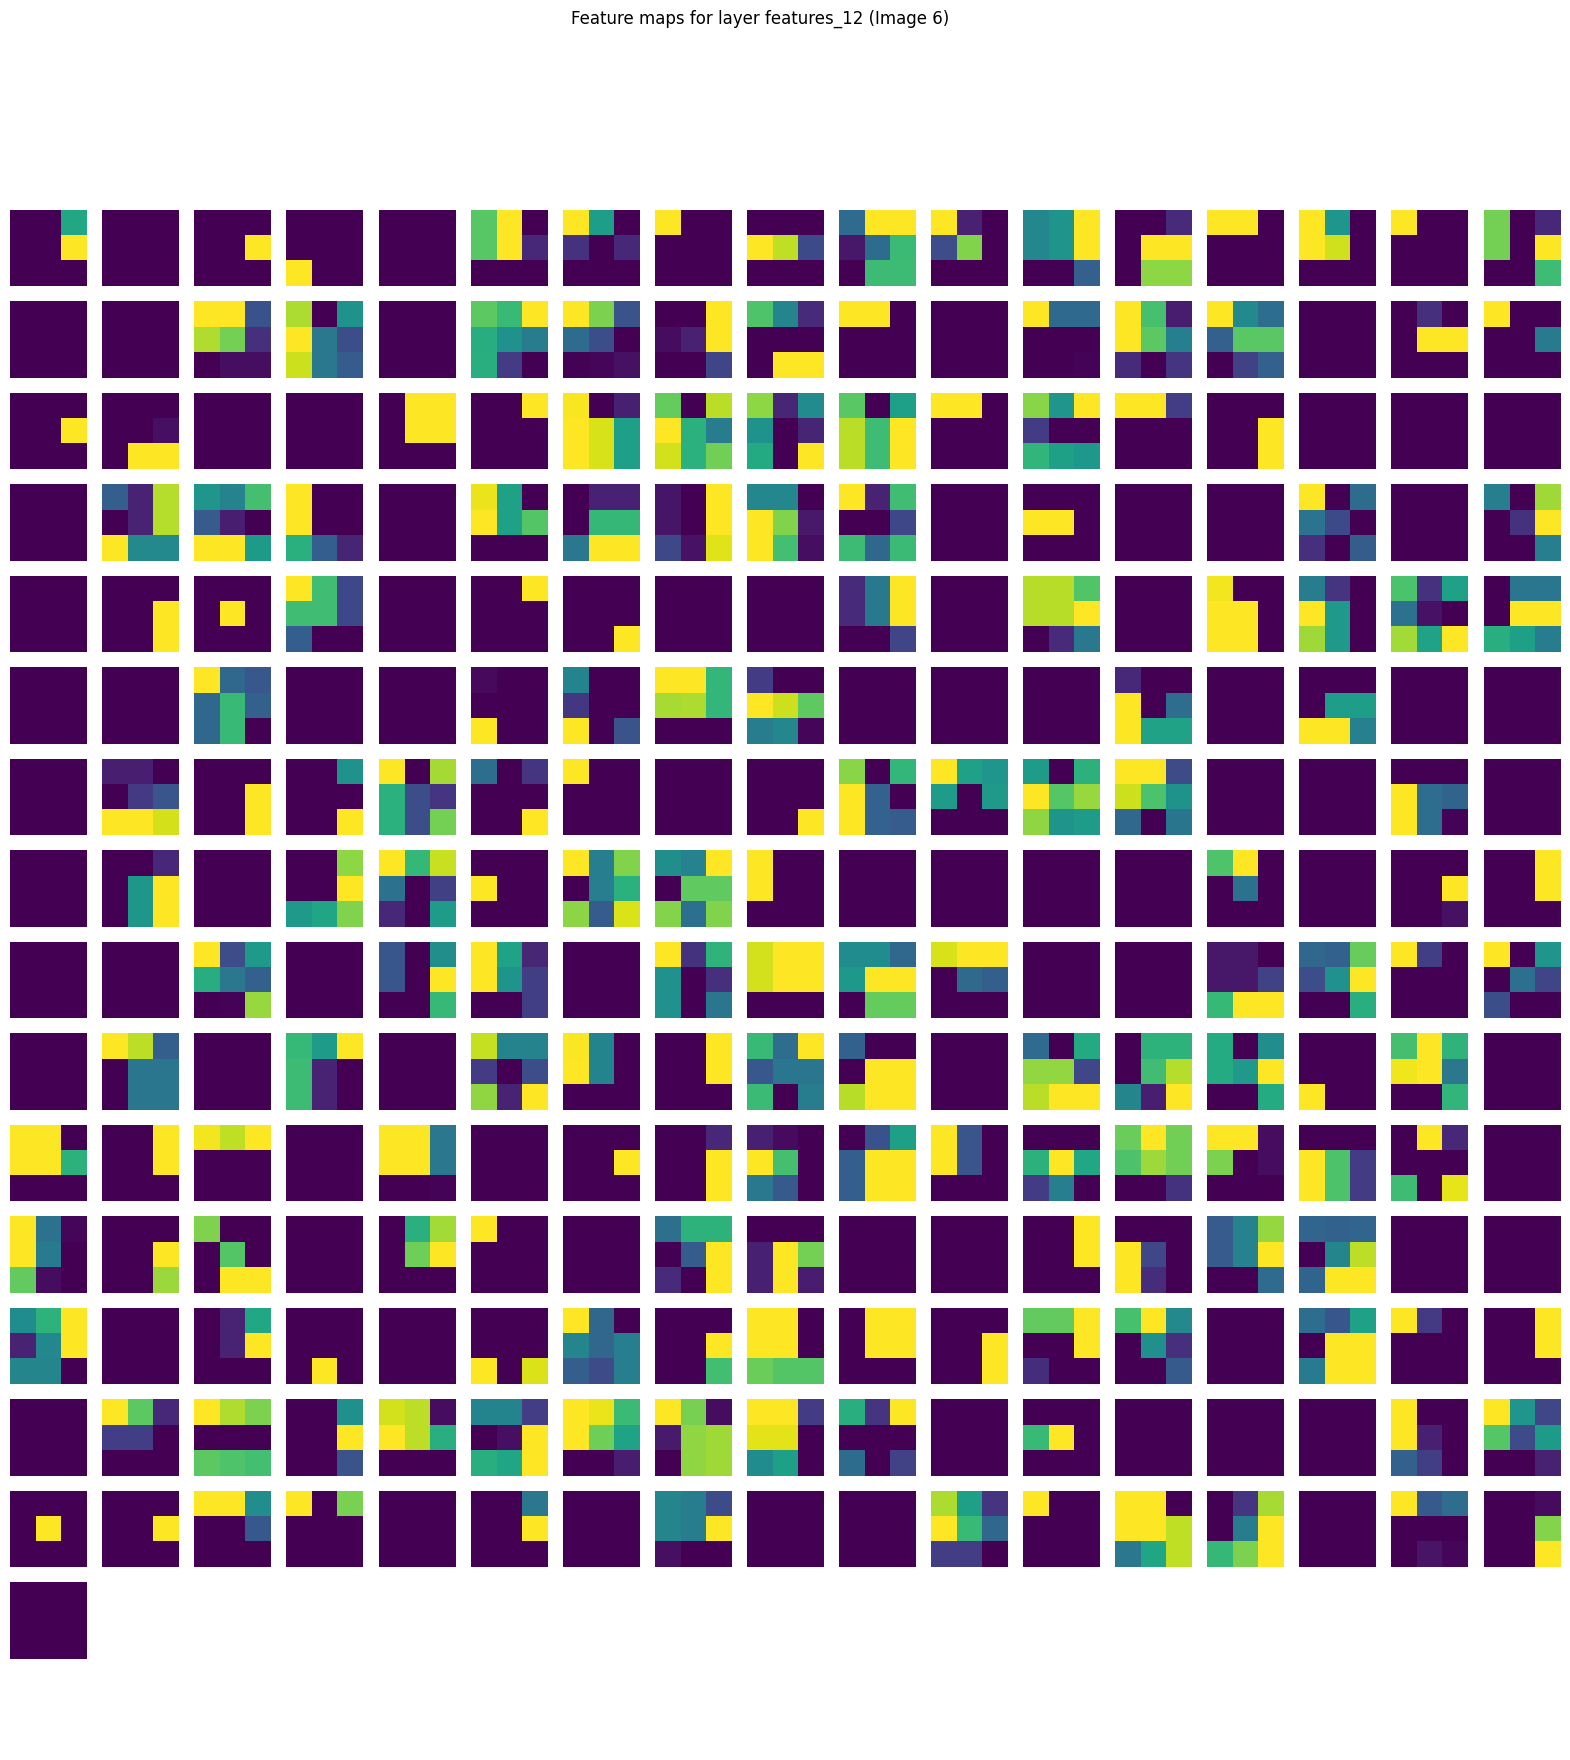

In [ ]:
import matplotlib.pyplot as plt

def visualize_activations(intermediate_outputs, image_idx=0):
    plt.imshow(test_inputs[image_idx])
    for layer_name, activation in intermediate_outputs.items():
        if 'classifier' in layer_name:
            # Classifier activations do not have spatial dimensions that can be visualized as images
            continue

        # Assuming the activation is a 4D tensor: [batch_size, num_feature_maps, height, width]
        num_feature_maps = activation.size(1)
        
        # Determine the grid size square that is large enough to display all feature maps
        grid_size = int(num_feature_maps ** 0.5) + 1
        fig, axes = plt.subplots(grid_size, grid_size, figsize=(20, 20))

        for i in range(grid_size ** 2):
            ax = axes[i // grid_size, i % grid_size]
            if i < num_feature_maps:
                # Extract the i-th feature map for the specified image index in the batch
                feature_map = activation[image_idx, i].detach().cpu()
                ax.imshow(feature_map, cmap='viridis')
            ax.axis('off')
        
        plt.suptitle(f'Feature maps for layer {layer_name} (Image {image_idx})')
        plt.show()

image_idx = 6  # Change this to the index of the image you want to visualize
visualize_activations(intermediate_outputs, image_idx=image_idx)
